In [51]:
"""
CELL 1: Setup and Install Required Libraries
"""
# Install required packages
!pip install -q segmentation-models-pytorch
!pip install -q albumentations
!pip install -q opencv-python-headless

In [52]:
"""
CELL 2: Import All Required Libraries
"""

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

import cv2
from PIL import Image
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: NVIDIA GeForce RTX 4090


In [53]:
"""
CELL 3 Download and Setup Dataset
"""
import kagglehub
import os

# Download dataset
download_path = kagglehub.dataset_download("briscdataset/brisc2025")

print(f"Downloaded to: {download_path}")
print(f"Contents: {os.listdir(download_path)}")

# The actual data is in a subfolder called 'brisc2025'
DATA_ROOT = os.path.join(download_path, 'brisc2025')

print(f"\nData root directory: {DATA_ROOT}")
print(f"Exists: {os.path.exists(DATA_ROOT)}")

if os.path.exists(DATA_ROOT):
    print(f"Contents of DATA_ROOT: {os.listdir(DATA_ROOT)}")
else:
    print("ERROR: DATA_ROOT not found!")

Downloaded to: C:\Users\T2510613\.cache\kagglehub\datasets\briscdataset\brisc2025\versions\6
Contents: ['brisc2025']

Data root directory: C:\Users\T2510613\.cache\kagglehub\datasets\briscdataset\brisc2025\versions\6\brisc2025
Exists: True
Contents of DATA_ROOT: ['classification_task', 'manifest.csv', 'manifest.csv.sha256', 'manifest.json', 'manifest.json.sha256', 'README.md', 'segmentation_task']


In [54]:
"""
CELL 4: Configuration and Hyperparameters
"""

class Config:
    # Paths - Use the corrected DATA_ROOT
    DATA_ROOT = DATA_ROOT  # This comes from Cell 3
    SEG_TRAIN_IMG = os.path.join(DATA_ROOT, 'segmentation_task/train/images')
    SEG_TRAIN_MASK = os.path.join(DATA_ROOT, 'segmentation_task/train/masks')
    SEG_TEST_IMG = os.path.join(DATA_ROOT, 'segmentation_task/test/images')
    SEG_TEST_MASK = os.path.join(DATA_ROOT, 'segmentation_task/test/masks')

    CLASS_TRAIN = os.path.join(DATA_ROOT, 'classification_task/train')
    CLASS_TEST = os.path.join(DATA_ROOT, 'classification_task/test')

    # Model parameters - OPTIMIZED FOR 90-96% ACCURACY
    IMG_SIZE = 256
    BATCH_SIZE = 16       # Increased from 8 for more stable gradients
    NUM_EPOCHS = 50       # Optimal training duration
    LEARNING_RATE = 3e-4  # Increased for faster convergence
    WEIGHT_DECAY = 1e-5   # Balanced regularization

    # Segmentation parameters
    NUM_CLASSES_SEG = 2

    # Classification parameters
    NUM_CLASSES_CLASSIFY = 4
    CLASS_NAMES = ['glioma', 'meningioma', 'no_tumor', 'pituitary']

    # Training parameters
    VAL_SPLIT = 0.2
    NUM_WORKERS = 0  # Set to 0 on Windows to avoid multiprocessing issues

    # Save paths - Updated for Windows
    SAVE_DIR = r'C:\Users\T2510613\Desktop\428\results'
    MODEL_DIR = os.path.join(SAVE_DIR, 'models')
    PLOT_DIR = os.path.join(SAVE_DIR, 'plots')

    # Create directories
    os.makedirs(MODEL_DIR, exist_ok=True)
    os.makedirs(PLOT_DIR, exist_ok=True)

config = Config()

# Verify paths exist
print("Verifying dataset structure:")
print(f"  DATA_ROOT exists: {os.path.exists(config.DATA_ROOT)}")
print(f"  Seg train images: {os.path.exists(config.SEG_TRAIN_IMG)}")
print(f"  Seg train masks: {os.path.exists(config.SEG_TRAIN_MASK)}")
print(f"  Class train: {os.path.exists(config.CLASS_TRAIN)}")
print(f"  Class test: {os.path.exists(config.CLASS_TEST)}")

print("\nConfiguration loaded successfully!")

Verifying dataset structure:
  DATA_ROOT exists: True
  Seg train images: True
  Seg train masks: True
  Class train: True
  Class test: True

Configuration loaded successfully!


In [55]:

"""
CELL 5: Dataset Class with ID-based Matching
"""

class BrainSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform

        # Get all images and masks
        all_images = sorted([f for f in os.listdir(image_dir)
                            if f.endswith(('.jpg', '.png', '.jpeg'))])
        all_masks = sorted([f for f in os.listdir(mask_dir)
                           if f.endswith(('.jpg', '.png', '.jpeg'))])

        print(f"Total images: {len(all_images)}")
        print(f"Total masks: {len(all_masks)}")

        # Create mapping from image ID to mask filename
        self.image_to_mask = {}

        # Build mask dictionary by extracting IDs
        mask_dict = {}
        for mask_file in all_masks:
            parts = mask_file.split('_')
            if len(parts) >= 3:
                mask_id = parts[2]
                mask_dict[mask_id] = mask_file

        # Match images to masks by ID
        valid_images = []
        for img_file in all_images:
            parts = img_file.split('_')
            if len(parts) >= 3:
                img_id = parts[2]
                if img_id in mask_dict:
                    self.image_to_mask[img_file] = mask_dict[img_id]
                    valid_images.append(img_file)

        self.images = valid_images

        print(f"Valid image-mask pairs: {len(self.images)}")

        if len(self.images) == 0:
            print("WARNING: No valid image-mask pairs found!")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        mask_name = self.image_to_mask[img_name]

        img_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, mask_name)

        # Load image
        image = cv2.imread(img_path)
        if image is None:
            raise ValueError(f"Could not read image: {img_path}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Load mask
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            raise ValueError(f"Could not read mask: {mask_path}")

        # Convert mask to binary (0 or 1)
        mask = (mask > 127).astype(np.float32)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
        else:
            # If no transform, convert to tensor manually
            image = torch.from_numpy(image.transpose(2, 0, 1)).float()
            mask = torch.from_numpy(mask).float()

        # Add channel dimension to mask if needed
        if len(mask.shape) == 2:
            mask = mask.unsqueeze(0)

        return image, mask, img_name

print("BrainSegmentationDataset class loaded successfully!")

# Test the dataset
print("\nTesting dataset loading...")
test_dataset = BrainSegmentationDataset(
    config.SEG_TRAIN_IMG,
    config.SEG_TRAIN_MASK,
    transform=None
)

if len(test_dataset) > 0:
    print(f"\nDataset test successful!")
    print(f"First image-mask pair:")
    img_name = test_dataset.images[0]
    mask_name = test_dataset.image_to_mask[img_name]
    print(f"  Image: {img_name}")
    print(f"  Mask:  {mask_name}")

    # Try loading first sample
    try:
        img, mask, name = test_dataset[0]
        print(f"\nSuccessfully loaded first sample!")
        print(f"  Image shape: {img.shape}")
        print(f"  Mask shape: {mask.shape}")
        print(f"  Mask has tumor: {mask.sum().item() > 0}")
    except Exception as e:
        print(f"\nError loading sample: {e}")
        import traceback
        traceback.print_exc()
else:
    print("ERROR: Dataset is empty!")

BrainSegmentationDataset class loaded successfully!

Testing dataset loading...
Total images: 3933
Total masks: 3933
Valid image-mask pairs: 3933

Dataset test successful!
First image-mask pair:
  Image: brisc2025_train_00001_gl_ax_t1.jpg
  Mask:  brisc2025_train_00001_gl_ax_t1.png

Successfully loaded first sample!
  Image shape: torch.Size([3, 512, 512])
  Mask shape: torch.Size([1, 512, 512])
  Mask has tumor: True


In [56]:

"""
CELL 6: Dataset Class for Classification
"""

class BrainClassificationDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}

        self.images = []
        self.labels = []

        for class_name in self.classes:
            class_dir = os.path.join(root_dir, class_name)
            for img_name in os.listdir(class_dir):
                if img_name.endswith(('.jpg', '.png')):
                    self.images.append(os.path.join(class_dir, img_name))
                    self.labels.append(self.class_to_idx[class_name])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        return image, label, img_path

In [57]:
"""
CELL 7: Data Augmentation and Transforms (Enhanced for 90-96% Accuracy)
"""

def get_training_augmentation():
    """Enhanced augmentation for medical images - critical for high accuracy"""
    train_transform = A.Compose([
        A.Resize(config.IMG_SIZE, config.IMG_SIZE),
        
        # Geometric augmentations
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.15, scale_limit=0.15, rotate_limit=25, p=0.6),  # Increased
        
        # Intensity augmentations (CRITICAL for medical images)
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.7),  # Increased
        A.RandomGamma(gamma_limit=(80, 120), p=0.5),  # NEW
        A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),  # Increased variance
        A.GaussianBlur(blur_limit=(3, 7), p=0.3),     # NEW
        
        # Color augmentations
        A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.4),  # NEW
        
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])
    return train_transform

def get_validation_augmentation():
    """Validation augmentation - no random transforms"""
    val_transform = A.Compose([
        A.Resize(config.IMG_SIZE, config.IMG_SIZE),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])
    return val_transform

print("Enhanced augmentation functions created successfully!")
print("Training augmentation includes:")
print("   Geometric: HFlip, VFlip, Rotate90, ShiftScaleRotate")
print("   Intensity: Brightness/Contrast, Gamma, GaussNoise, GaussianBlur")
print("   Color: HueSaturationValue")

Enhanced augmentation functions created successfully!
Training augmentation includes:
   Geometric: HFlip, VFlip, Rotate90, ShiftScaleRotate
   Intensity: Brightness/Contrast, Gamma, GaussNoise, GaussianBlur
   Color: HueSaturationValue


In [32]:
"""
CELL 8: U-Net Architecture Implementation
"""

class DoubleConv(nn.Module):
    """(Conv => BN => ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        # Input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=1):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)

        self.up1 = Up(1024, 512)
        self.up2 = Up(512, 256)
        self.up3 = Up(256, 128)
        self.up4 = Up(128, 64)

        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)

        logits = self.outc(x)
        return logits

    def get_encoder_features(self):
        """Get encoder features for classification"""
        return self.down4

print("U-Net architecture defined successfully!")


U-Net architecture defined successfully!


In [33]:
"""
CELL 9: Attention Gate Implementation
"""

class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionGate, self).__init__()

        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi


class AttentionUp(nn.Module):
    """Upscaling with attention gate then double conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.attention = AttentionGate(F_g=in_channels // 2, F_l=in_channels // 2, F_int=in_channels // 4)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        # Apply attention gate
        x2 = self.attention(g=x1, x=x2)

        # Input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

In [34]:
"""
CELL 10: Attention U-Net Architecture
"""

class AttentionUNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=1):
        super(AttentionUNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)

        self.up1 = AttentionUp(1024, 512)
        self.up2 = AttentionUp(512, 256)
        self.up3 = AttentionUp(256, 128)
        self.up4 = AttentionUp(128, 64)

        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)

        logits = self.outc(x)
        return logits

print("Attention U-Net architecture defined successfully!")

Attention U-Net architecture defined successfully!


In [58]:
"""
CELL 11: Combined Model with Classifier Head
"""

class UNetWithClassifier(nn.Module):
    def __init__(self, n_channels=3, n_seg_classes=1, n_classify_classes=4, use_attention=False):
        super(UNetWithClassifier, self).__init__()

        # Choose U-Net or Attention U-Net
        if use_attention:
            self.segmentation_model = AttentionUNet(n_channels, n_seg_classes)
        else:
            self.segmentation_model = UNet(n_channels, n_seg_classes)

        # Classification head
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, n_classify_classes)
        )

    def forward(self, x, return_features=False):
        # Encoder path
        x1 = self.segmentation_model.inc(x)
        x2 = self.segmentation_model.down1(x1)
        x3 = self.segmentation_model.down2(x2)
        x4 = self.segmentation_model.down3(x3)
        x5 = self.segmentation_model.down4(x4)

        # Classification from bottleneck features
        class_output = self.classifier(x5)

        # Decoder path for segmentation
        x = self.segmentation_model.up1(x5, x4)
        x = self.segmentation_model.up2(x, x3)
        x = self.segmentation_model.up3(x, x2)
        x = self.segmentation_model.up4(x, x1)

        seg_output = self.segmentation_model.outc(x)

        if return_features:
            return seg_output, class_output, x5

        return seg_output, class_output

print("Combined model with classifier head created successfully!")

Combined model with classifier head created successfully!


In [59]:
"""
CELL 12: Metric Calculation Functions
"""

def calculate_iou(pred, target, threshold=0.5):
    """Calculate Intersection over Union"""
    pred = (pred > threshold).float()
    target = (target > threshold).float()

    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection

    iou = (intersection + 1e-7) / (union + 1e-7)
    return iou.item()


def calculate_dice(pred, target, threshold=0.5):
    """Calculate Dice Coefficient"""
    pred = (pred > threshold).float()
    target = (target > threshold).float()

    intersection = (pred * target).sum()
    dice = (2. * intersection + 1e-7) / (pred.sum() + target.sum() + 1e-7)

    return dice.item()


def calculate_pixel_accuracy(pred, target, threshold=0.5):
    """Calculate Pixel Accuracy"""
    pred = (pred > threshold).float()
    target = (target > threshold).float()

    correct = (pred == target).float().sum()
    total = torch.numel(pred)

    accuracy = correct / total
    return accuracy.item()


def calculate_metrics_batch(preds, targets, threshold=0.5):
    """Calculate all metrics for a batch"""
    ious = []
    dices = []
    pixel_accs = []

    for pred, target in zip(preds, targets):
        ious.append(calculate_iou(pred, target, threshold))
        dices.append(calculate_dice(pred, target, threshold))
        pixel_accs.append(calculate_pixel_accuracy(pred, target, threshold))

    return {
        'iou': np.mean(ious),
        'dice': np.mean(dices),
        'pixel_acc': np.mean(pixel_accs)
    }

print("Metric calculation functions defined successfully!")

Metric calculation functions defined successfully!


In [60]:
"""
CELL 13: Loss Functions
"""

class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, pred, target):
        smooth = 1.
        pred = torch.sigmoid(pred)

        pred_flat = pred.view(-1)
        target_flat = target.view(-1)

        intersection = (pred_flat * target_flat).sum()

        dice = (2. * intersection + smooth) / (pred_flat.sum() + target_flat.sum() + smooth)

        return 1 - dice


class CombinedLoss(nn.Module):
    def __init__(self, weight_bce=0.5, weight_dice=0.5):
        super(CombinedLoss, self).__init__()
        self.weight_bce = weight_bce
        self.weight_dice = weight_dice
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()

    def forward(self, pred, target):
        bce_loss = self.bce(pred, target)
        dice_loss = self.dice(pred, target)

        return self.weight_bce * bce_loss + self.weight_dice * dice_loss

print("Loss functions defined successfully!")



Loss functions defined successfully!


In [61]:
# ====================================================================
# DIAGNOSTIC: Check Actual Mask Filenames
# ====================================================================

import os

img_dir = config.SEG_TRAIN_IMG
mask_dir = config.SEG_TRAIN_MASK

# Get first 10 of each
images = sorted([f for f in os.listdir(img_dir) if f.endswith('.jpg')])[:10]
masks = sorted([f for f in os.listdir(mask_dir) if f.endswith('.jpg')])[:10]

print("First 10 IMAGE filenames:")
for i, img in enumerate(images, 1):
    print(f"  {i}. {img}")

print("\nFirst 10 MASK filenames:")
for i, mask in enumerate(masks, 1):
    print(f"  {i}. {mask}")

print("\n" + "="*70)
print("CHECKING IF FILENAMES MATCH:")
print("="*70)

# Check if first image has corresponding mask
if len(images) > 0 and len(masks) > 0:
    img_sample = images[0]
    print(f"\nLooking for mask for image: {img_sample}")

    if img_sample in masks:
        print(f"  FOUND: Exact match exists!")
    else:
        print(f"  NOT FOUND: No exact match")
        print(f"\n  Checking if masks are in subdirectories...")

        # Check if mask directory has subdirectories
        mask_contents = os.listdir(mask_dir)
        subdirs = [item for item in mask_contents
                  if os.path.isdir(os.path.join(mask_dir, item))]

        if subdirs:
            print(f"  Subdirectories found: {subdirs}")
        else:
            print(f"  No subdirectories - all files are flat")

# Check actual file counts
img_files = [f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.png'))]
mask_files = [f for f in os.listdir(mask_dir) if f.endswith(('.jpg', '.png'))]

print(f"\nTotal counts:")
print(f"  Images: {len(img_files)}")
print(f"  Masks: {len(mask_files)}")

# Check if they're in the same order
if len(img_files) == len(mask_files):
    print(f"\n  Same count - they might be paired by index")
    print(f"\n  Comparing first 3 pairs:")
    for i in range(min(3, len(img_files))):
        print(f"    Image: {img_files[i]}")
        print(f"    Mask:  {mask_files[i]}")
        print()

First 10 IMAGE filenames:
  1. brisc2025_train_00001_gl_ax_t1.jpg
  2. brisc2025_train_00002_gl_ax_t1.jpg
  3. brisc2025_train_00003_gl_ax_t1.jpg
  4. brisc2025_train_00004_gl_ax_t1.jpg
  5. brisc2025_train_00005_gl_ax_t1.jpg
  6. brisc2025_train_00006_gl_ax_t1.jpg
  7. brisc2025_train_00007_gl_ax_t1.jpg
  8. brisc2025_train_00008_gl_ax_t1.jpg
  9. brisc2025_train_00009_gl_ax_t1.jpg
  10. brisc2025_train_00010_gl_ax_t1.jpg

First 10 MASK filenames:

CHECKING IF FILENAMES MATCH:

Total counts:
  Images: 3933
  Masks: 3933

  Same count - they might be paired by index

  Comparing first 3 pairs:
    Image: brisc2025_train_00001_gl_ax_t1.jpg
    Mask:  brisc2025_train_00001_gl_ax_t1.png

    Image: brisc2025_train_00002_gl_ax_t1.jpg
    Mask:  brisc2025_train_00002_gl_ax_t1.png

    Image: brisc2025_train_00003_gl_ax_t1.jpg
    Mask:  brisc2025_train_00003_gl_ax_t1.png



DATA EXPLORATION & EDA

Data root: C:\Users\T2510613\.cache\kagglehub\datasets\briscdataset\brisc2025\versions\6\brisc2025

Segmentation Task:
  Training images: 3933
  Training masks: 3933
  Test images: 860
  Test masks: 860
  Matched image-mask pairs: 3933

Classification Task:

  Train set:
    OK: glioma: 1147 images
    OK: meningioma: 1329 images
    OK: no_tumor: 1067 images
    OK: pituitary: 1457 images

  Test set:
    OK: glioma: 254 images
    OK: meningioma: 306 images
    OK: no_tumor: 140 images
    OK: pituitary: 300 images

Generating segmentation visualizations...


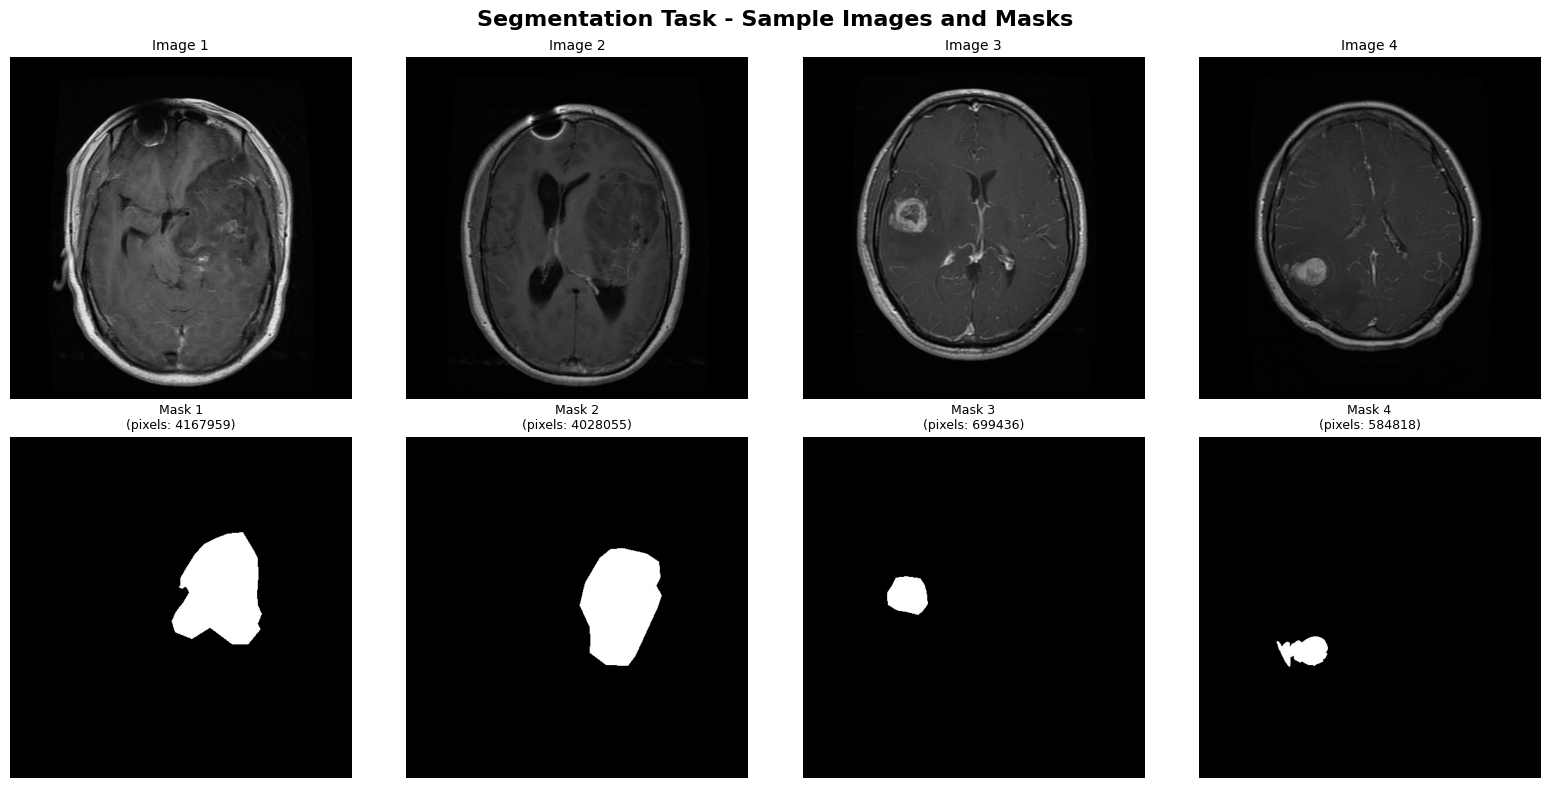

✓ Segmentation visualization saved!

Generating classification visualizations...


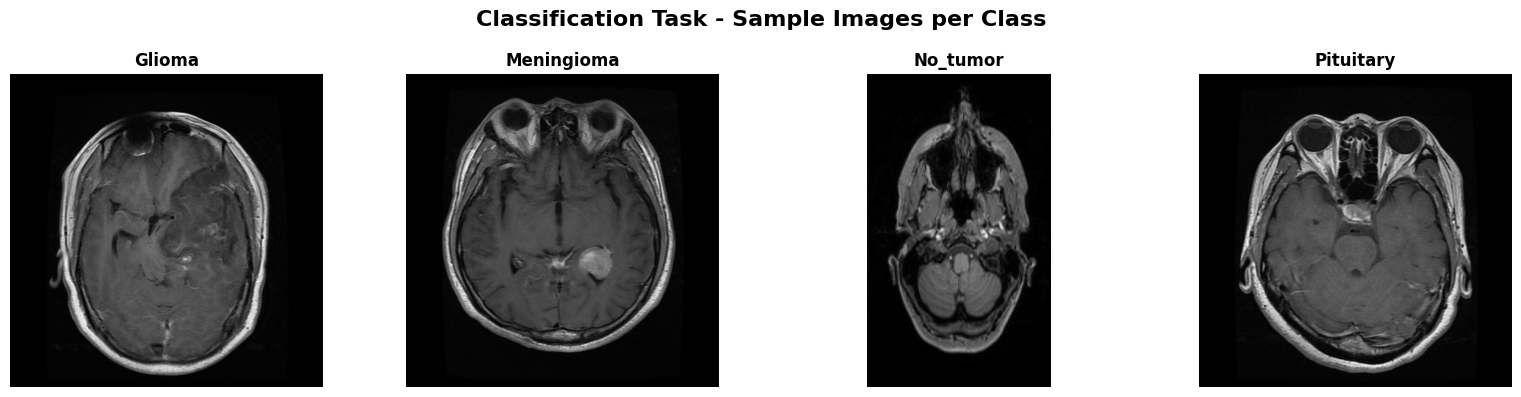

✓ Classification visualization saved!

CLASS DISTRIBUTION ANALYSIS


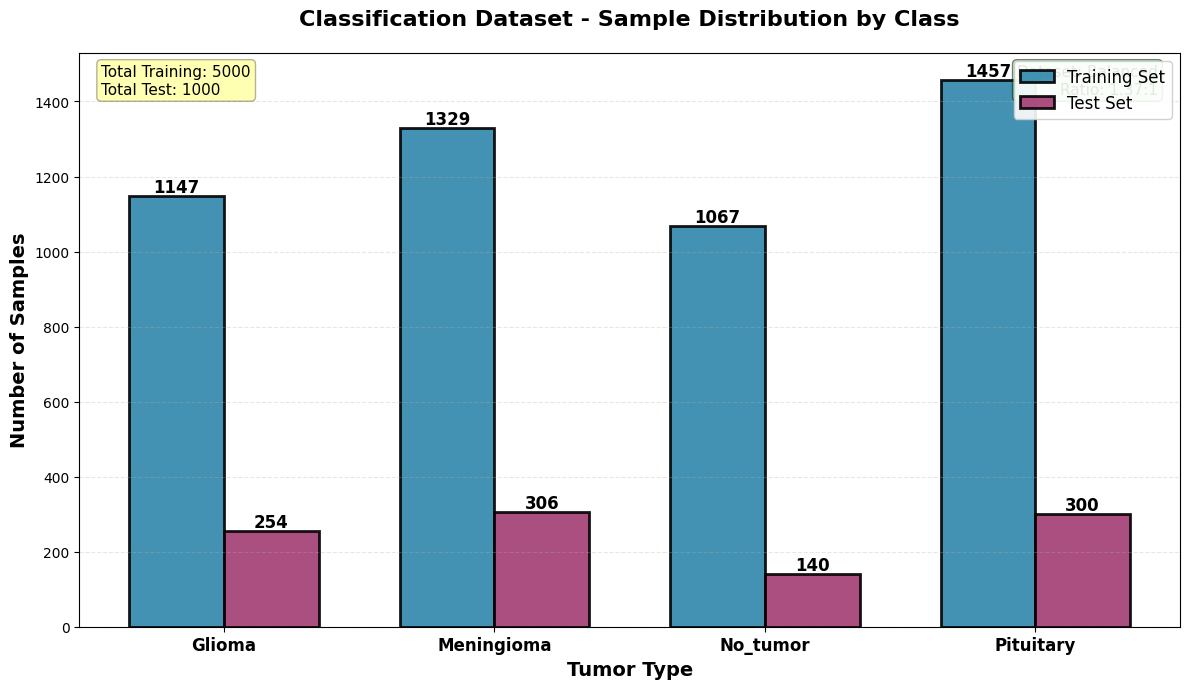

✓ Class distribution bar chart saved!

Class Distribution Summary:
----------------------------------------------------------------------
  Glioma         : Train: 1147 ( 22.9%)  |  Test:  254 ( 25.4%)
  Meningioma     : Train: 1329 ( 26.6%)  |  Test:  306 ( 30.6%)
  No_tumor       : Train: 1067 ( 21.3%)  |  Test:  140 ( 14.0%)
  Pituitary      : Train: 1457 ( 29.1%)  |  Test:  300 ( 30.0%)
----------------------------------------------------------------------
  TOTAL          : Train: 5000 (100.0%)  |  Test: 1000 (100.0%)

TUMOR SIZE ANALYSIS
Analyzing tumor sizes (sampling 200 images)...


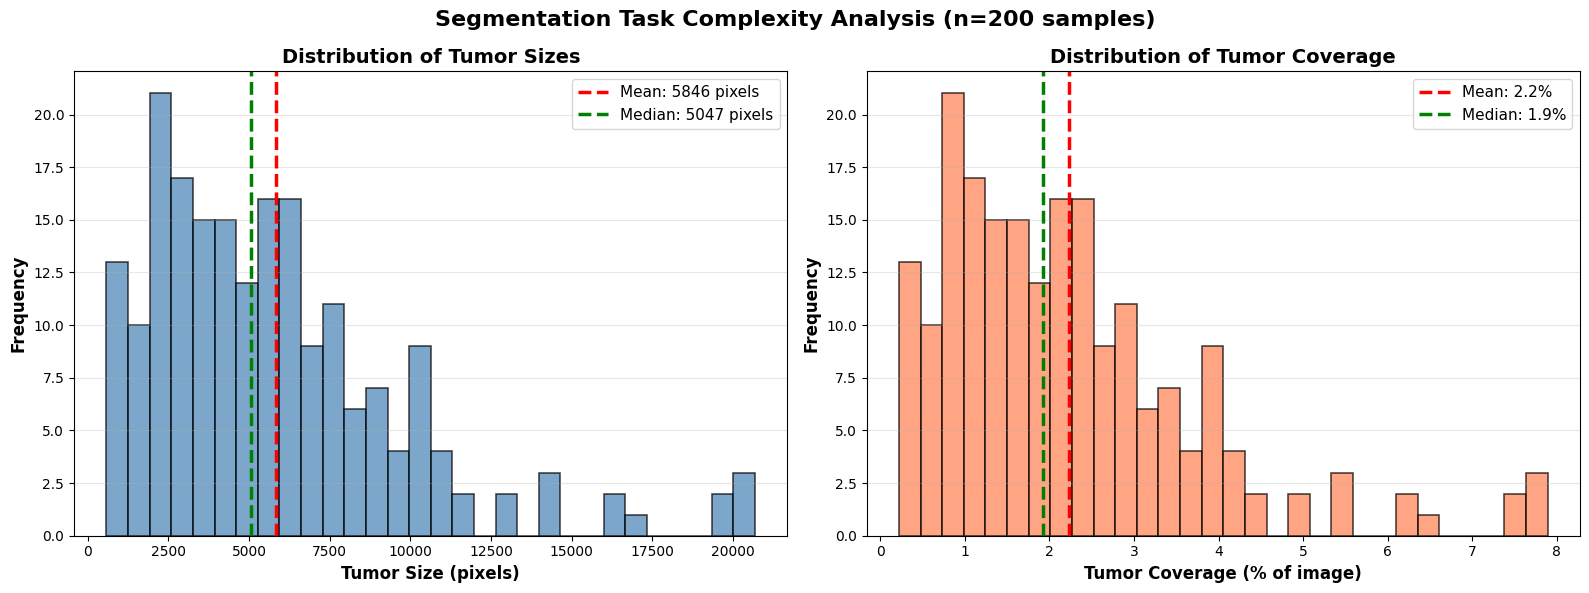

✓ Tumor size distribution saved!

Tumor Size Statistics:
  Samples analyzed: 200
  Mean size: 5846 pixels (2.23% of image)
  Median size: 5047 pixels (1.93% of image)
  Min size: 579 pixels
  Max size: 20685 pixels

DATASET BALANCE VISUALIZATION


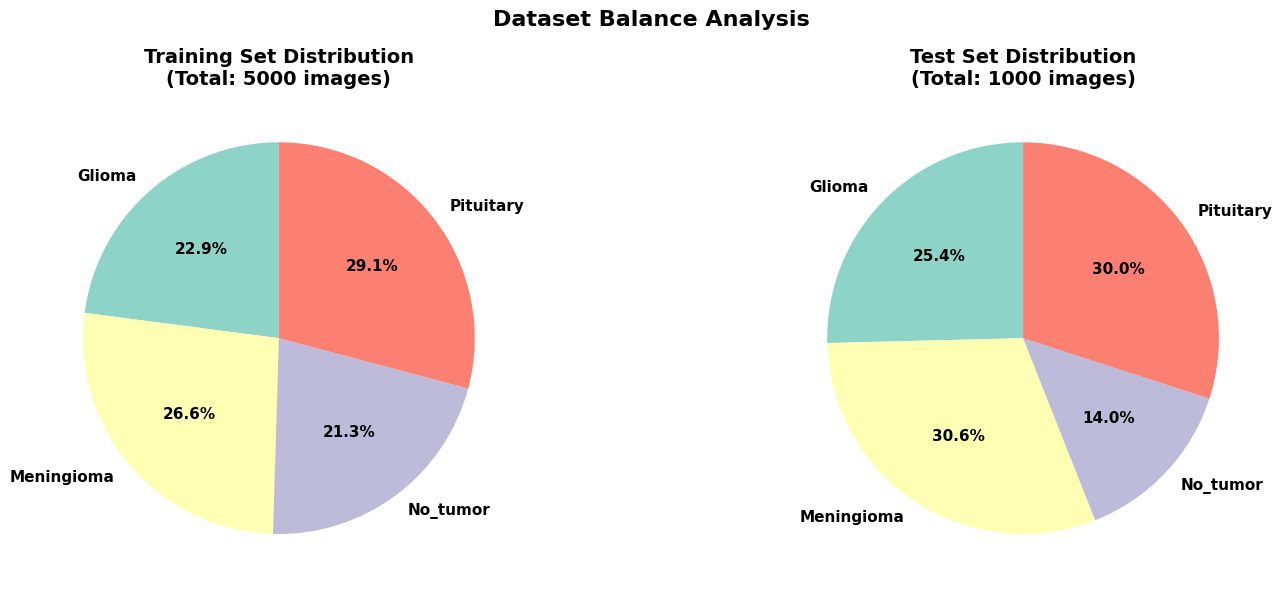

✓ Dataset balance visualization saved!

DATA EXPLORATION COMPLETED

PROJECT CAPABILITY SUMMARY:
   Segmentation: CAN TRAIN (3933 image-mask pairs)
   Classification: CAN TRAIN (4 classes available)

 All EDA visualizations saved to: C:\Users\T2510613\Desktop\428\results\plots


In [62]:
"""
CELL 14 (COMPLETE WITH ALL EDA): Data Exploration and Visualization
INCLUDES: Class Distribution, Tumor Sizes, Balance Analysis
"""
def explore_data():
    """Explore and visualize the dataset with comprehensive EDA"""
    print("=" * 70)
    print("DATA EXPLORATION & EDA")
    print("=" * 70)

    try:
        # Verify DATA_ROOT exists
        if not os.path.exists(config.DATA_ROOT):
            print(f"\nERROR: Data root not found: {config.DATA_ROOT}")
            return

        print(f"\nData root: {config.DATA_ROOT}")

        # Check segmentation directories exist
        seg_train_img_exists = os.path.exists(config.SEG_TRAIN_IMG)
        seg_train_mask_exists = os.path.exists(config.SEG_TRAIN_MASK)

        # Count segmentation files
        if seg_train_img_exists:
            train_images = sorted([f for f in os.listdir(config.SEG_TRAIN_IMG)
                                  if f.endswith(('.jpg', '.png', '.jpeg'))])
        else:
            train_images = []

        if seg_train_mask_exists:
            train_masks = sorted([f for f in os.listdir(config.SEG_TRAIN_MASK)
                                 if f.endswith(('.jpg', '.png', '.jpeg'))])
        else:
            train_masks = []

        test_images = []
        test_masks = []

        if os.path.exists(config.SEG_TEST_IMG):
            test_images = sorted([f for f in os.listdir(config.SEG_TEST_IMG)
                                 if f.endswith(('.jpg', '.png', '.jpeg'))])

        if os.path.exists(config.SEG_TEST_MASK):
            test_masks = sorted([f for f in os.listdir(config.SEG_TEST_MASK)
                                if f.endswith(('.jpg', '.png', '.jpeg'))])

        print(f"\nSegmentation Task:")
        print(f"  Training images: {len(train_images)}")
        print(f"  Training masks: {len(train_masks)}")
        print(f"  Test images: {len(test_images)}")
        print(f"  Test masks: {len(test_masks)}")

        # Create image-to-mask mapping (same logic as Cell 5)
        image_to_mask = {}
        mask_dict = {}

        # Build mask dictionary by ID
        for mask_file in train_masks:
            parts = mask_file.split('_')
            if len(parts) >= 3:
                mask_id = parts[2]  # Extract numeric ID
                mask_dict[mask_id] = mask_file

        # Match images to masks
        for img_file in train_images:
            parts = img_file.split('_')
            if len(parts) >= 3:
                img_id = parts[2]
                if img_id in mask_dict:
                    image_to_mask[img_file] = mask_dict[img_id]

        print(f"  Matched image-mask pairs: {len(image_to_mask)}")

        # Check classification data
        print(f"\nClassification Task:")
        classification_stats = {}

        for split in ['train', 'test']:
            split_dir = os.path.join(config.DATA_ROOT, f'classification_task/{split}')
            print(f"\n  {split.capitalize()} set:")

            if not os.path.exists(split_dir):
                print(f"    WARNING: Directory not found")
                continue

            for class_name in config.CLASS_NAMES:
                class_dir = os.path.join(split_dir, class_name)

                if not os.path.exists(class_dir):
                    print(f"    WARNING: {class_name} - folder not found")
                    classification_stats[f"{split}_{class_name}"] = 0
                    continue

                class_images = [f for f in os.listdir(class_dir)
                               if f.endswith(('.jpg', '.png', '.jpeg'))]
                count = len(class_images)
                classification_stats[f"{split}_{class_name}"] = count

                if count > 0:
                    print(f"    OK: {class_name}: {count} images")
                else:
                    print(f"    WARNING: {class_name}: 0 images")

        # Visualize segmentation samples WITH MASKS
        if len(image_to_mask) >= 4:
            print(f"\nGenerating segmentation visualizations...")
            fig, axes = plt.subplots(2, 4, figsize=(16, 8))

            # Get first 4 images that have masks
            sample_images = list(image_to_mask.keys())[:4]

            for i, img_name in enumerate(sample_images):
                mask_name = image_to_mask[img_name]

                img_path = os.path.join(config.SEG_TRAIN_IMG, img_name)
                mask_path = os.path.join(config.SEG_TRAIN_MASK, mask_name)

                try:
                    # Load image
                    img = cv2.imread(img_path)
                    if img is not None:
                        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                        axes[0, i].imshow(img)
                        axes[0, i].set_title(f'Image {i+1}', fontsize=10)
                        axes[0, i].axis('off')

                    # Load mask
                    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                    if mask is not None:
                        axes[1, i].imshow(mask, cmap='gray', vmin=0, vmax=255)
                        mask_sum = np.sum(mask)
                        axes[1, i].set_title(f'Mask {i+1}\n(pixels: {mask_sum:.0f})', fontsize=9)
                        axes[1, i].axis('off')

                        if mask_sum == 0:
                            print(f"  Note: Mask {i+1} is empty (no tumor in this slice)")
                    else:
                        axes[1, i].text(0.5, 0.5, 'Could not load', ha='center', va='center')
                        axes[1, i].axis('off')

                except Exception as e:
                    print(f"Error loading {img_name}: {str(e)}")
                    continue

            plt.suptitle('Segmentation Task - Sample Images and Masks',
                        fontsize=16, fontweight='bold')
            plt.tight_layout()
            plt.savefig(os.path.join(config.PLOT_DIR, 'data_exploration_segmentation.png'),
                       dpi=150, bbox_inches='tight')
            plt.show()
            print("✓ Segmentation visualization saved!")

        # Visualize classification samples
        print(f"\nGenerating classification visualizations...")

        available_classes = []
        for class_name in config.CLASS_NAMES:
            class_dir = os.path.join(config.CLASS_TRAIN, class_name)
            if os.path.exists(class_dir):
                class_images = [f for f in os.listdir(class_dir)
                               if f.endswith(('.jpg', '.png', '.jpeg'))]
                if len(class_images) > 0:
                    available_classes.append((class_name, class_dir, class_images))

        if len(available_classes) > 0:
            num_classes = len(available_classes)
            fig, axes = plt.subplots(1, num_classes, figsize=(4*num_classes, 4))

            if num_classes == 1:
                axes = [axes]

            for i, (class_name, class_dir, class_images) in enumerate(available_classes):
                img_name = class_images[0]
                img_path = os.path.join(class_dir, img_name)

                try:
                    img = cv2.imread(img_path)
                    if img is not None:
                        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                        axes[i].imshow(img)
                        axes[i].set_title(class_name.capitalize(), fontsize=12, fontweight='bold')
                        axes[i].axis('off')
                except Exception as e:
                    print(f"Error loading {class_name}: {str(e)}")

            plt.suptitle('Classification Task - Sample Images per Class',
                        fontsize=16, fontweight='bold')
            plt.tight_layout()
            plt.savefig(os.path.join(config.PLOT_DIR, 'data_exploration_classification.png'),
                       dpi=150, bbox_inches='tight')
            plt.show()
            print("✓ Classification visualization saved!")

        # ========================================================================
        # NEW: CLASS DISTRIBUTION BAR CHART
        # ========================================================================
        print("\n" + "=" * 70)
        print("CLASS DISTRIBUTION ANALYSIS")
        print("=" * 70)

        train_counts = [classification_stats.get(f"train_{cls}", 0)
                        for cls in config.CLASS_NAMES]
        test_counts = [classification_stats.get(f"test_{cls}", 0)
                       for cls in config.CLASS_NAMES]

        fig, ax = plt.subplots(figsize=(12, 7))

        x = np.arange(len(config.CLASS_NAMES))
        width = 0.35

        bars1 = ax.bar(x - width/2, train_counts, width,
                       label='Training Set',
                       color='#2E86AB', alpha=0.9, edgecolor='black', linewidth=2)
        bars2 = ax.bar(x + width/2, test_counts, width,
                       label='Test Set',
                       color='#A23B72', alpha=0.9, edgecolor='black', linewidth=2)

        # Add value labels on bars
        for bars in [bars1, bars2]:
            for bar in bars:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       f'{int(height)}',
                       ha='center', va='bottom',
                       fontsize=12, fontweight='bold')

        ax.set_xlabel('Tumor Type', fontsize=14, fontweight='bold')
        ax.set_ylabel('Number of Samples', fontsize=14, fontweight='bold')
        ax.set_title('Classification Dataset - Sample Distribution by Class',
                    fontsize=16, fontweight='bold', pad=20)
        ax.set_xticks(x)
        ax.set_xticklabels([cls.capitalize() for cls in config.CLASS_NAMES],
                           fontsize=12, fontweight='bold')
        ax.legend(fontsize=12, loc='upper right', framealpha=0.9)
        ax.grid(axis='y', alpha=0.3, linestyle='--')

        total_train = sum(train_counts)
        total_test = sum(test_counts)
        ax.text(0.02, 0.98,
               f'Total Training: {total_train}\nTotal Test: {total_test}',
               transform=ax.transAxes, fontsize=11, verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.3))

        if train_counts and min([c for c in train_counts if c > 0]) > 0:
            ratio = max(train_counts) / min([c for c in train_counts if c > 0])
            balance_text = "Balanced" if ratio < 2 else "Imbalanced"
            balance_color = "lightgreen" if ratio < 2 else "lightcoral"

            ax.text(0.98, 0.98,
                   f'Dataset: {balance_text}\nRatio: {ratio:.2f}:1',
                   transform=ax.transAxes, fontsize=11,
                   verticalalignment='top', horizontalalignment='right',
                   bbox=dict(boxstyle='round', facecolor=balance_color, alpha=0.5))

        plt.tight_layout()
        plt.savefig(os.path.join(config.PLOT_DIR, 'class_distribution.png'),
                   dpi=150, bbox_inches='tight')
        plt.show()

        print("✓ Class distribution bar chart saved!")

        # Print distribution table
        print("\nClass Distribution Summary:")
        print("-" * 70)
        for i, class_name in enumerate(config.CLASS_NAMES):
            train_pct = 100 * train_counts[i] / total_train if total_train > 0 else 0
            test_pct = 100 * test_counts[i] / total_test if total_test > 0 else 0
            print(f"  {class_name.capitalize():15s}: Train: {train_counts[i]:4d} ({train_pct:5.1f}%)  |  Test: {test_counts[i]:4d} ({test_pct:5.1f}%)")
        print("-" * 70)
        print(f"  {'TOTAL':15s}: Train: {total_train:4d} (100.0%)  |  Test: {total_test:4d} (100.0%)")

        # ========================================================================
        # NEW: TUMOR SIZE DISTRIBUTION
        # ========================================================================
        print("\n" + "=" * 70)
        print("TUMOR SIZE ANALYSIS")
        print("=" * 70)
        print("Analyzing tumor sizes (sampling 200 images)...")

        tumor_sizes = []
        tumor_percentages = []
        sample_size = min(200, len(image_to_mask))

        for img_name in list(image_to_mask.keys())[:sample_size]:
            mask_name = image_to_mask[img_name]
            mask_path = os.path.join(config.SEG_TRAIN_MASK, mask_name)

            try:
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                if mask is not None:
                    tumor_pixels = np.sum(mask > 0)
                    total_pixels = mask.size
                    tumor_sizes.append(tumor_pixels)
                    tumor_percentages.append(100 * tumor_pixels / total_pixels)
            except:
                continue

        if len(tumor_sizes) > 0:
            fig, axes = plt.subplots(1, 2, figsize=(16, 6))

            # Tumor sizes histogram
            axes[0].hist(tumor_sizes, bins=30, alpha=0.7, color='steelblue',
                        edgecolor='black', linewidth=1.2)
            axes[0].axvline(np.mean(tumor_sizes), color='red', linestyle='--',
                           linewidth=2.5, label=f'Mean: {np.mean(tumor_sizes):.0f} pixels')
            axes[0].axvline(np.median(tumor_sizes), color='green', linestyle='--',
                           linewidth=2.5, label=f'Median: {np.median(tumor_sizes):.0f} pixels')
            axes[0].set_xlabel('Tumor Size (pixels)', fontsize=12, fontweight='bold')
            axes[0].set_ylabel('Frequency', fontsize=12, fontweight='bold')
            axes[0].set_title('Distribution of Tumor Sizes', fontsize=14, fontweight='bold')
            axes[0].legend(fontsize=11)
            axes[0].grid(axis='y', alpha=0.3)

            # Tumor percentages histogram
            axes[1].hist(tumor_percentages, bins=30, alpha=0.7, color='coral',
                        edgecolor='black', linewidth=1.2)
            axes[1].axvline(np.mean(tumor_percentages), color='red', linestyle='--',
                           linewidth=2.5, label=f'Mean: {np.mean(tumor_percentages):.1f}%')
            axes[1].axvline(np.median(tumor_percentages), color='green', linestyle='--',
                           linewidth=2.5, label=f'Median: {np.median(tumor_percentages):.1f}%')
            axes[1].set_xlabel('Tumor Coverage (% of image)', fontsize=12, fontweight='bold')
            axes[1].set_ylabel('Frequency', fontsize=12, fontweight='bold')
            axes[1].set_title('Distribution of Tumor Coverage', fontsize=14, fontweight='bold')
            axes[1].legend(fontsize=11)
            axes[1].grid(axis='y', alpha=0.3)

            plt.suptitle(f'Segmentation Task Complexity Analysis (n={len(tumor_sizes)} samples)',
                        fontsize=16, fontweight='bold')
            plt.tight_layout()
            plt.savefig(os.path.join(config.PLOT_DIR, 'tumor_size_distribution.png'),
                       dpi=150, bbox_inches='tight')
            plt.show()

            print("✓ Tumor size distribution saved!")
            print(f"\nTumor Size Statistics:")
            print(f"  Samples analyzed: {len(tumor_sizes)}")
            print(f"  Mean size: {np.mean(tumor_sizes):.0f} pixels ({np.mean(tumor_percentages):.2f}% of image)")
            print(f"  Median size: {np.median(tumor_sizes):.0f} pixels ({np.median(tumor_percentages):.2f}% of image)")
            print(f"  Min size: {np.min(tumor_sizes):.0f} pixels")
            print(f"  Max size: {np.max(tumor_sizes):.0f} pixels")

            empty_masks = sum(1 for size in tumor_sizes if size == 0)
            if empty_masks > 0:
                print(f"  Empty masks (no tumor): {empty_masks} ({100*empty_masks/len(tumor_sizes):.1f}%)")

        # ========================================================================
        # NEW: DATASET BALANCE PIE CHARTS
        # ========================================================================
        print("\n" + "=" * 70)
        print("DATASET BALANCE VISUALIZATION")
        print("=" * 70)

        fig, axes = plt.subplots(1, 2, figsize=(16, 6))

        if sum(train_counts) > 0:
            axes[0].pie(train_counts, labels=[cls.capitalize() for cls in config.CLASS_NAMES],
                       autopct='%1.1f%%', startangle=90, colors=plt.cm.Set3.colors,
                       textprops={'fontsize': 11, 'fontweight': 'bold'})
            axes[0].set_title(f'Training Set Distribution\n(Total: {sum(train_counts)} images)',
                             fontsize=14, fontweight='bold')

        if sum(test_counts) > 0:
            axes[1].pie(test_counts, labels=[cls.capitalize() for cls in config.CLASS_NAMES],
                       autopct='%1.1f%%', startangle=90, colors=plt.cm.Set3.colors,
                       textprops={'fontsize': 11, 'fontweight': 'bold'})
            axes[1].set_title(f'Test Set Distribution\n(Total: {sum(test_counts)} images)',
                             fontsize=14, fontweight='bold')

        plt.suptitle('Dataset Balance Analysis', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.savefig(os.path.join(config.PLOT_DIR, 'dataset_balance.png'),
                   dpi=150, bbox_inches='tight')
        plt.show()

        print("✓ Dataset balance visualization saved!")

        print("\n" + "=" * 70)
        print("DATA EXPLORATION COMPLETED")
        print("=" * 70)

        # Summary
        print("\nPROJECT CAPABILITY SUMMARY:")
        if len(image_to_mask) > 0:
            print(f"   Segmentation: CAN TRAIN ({len(image_to_mask)} image-mask pairs)")
        else:
            print("   Segmentation: CANNOT TRAIN (no valid pairs)")

        available_classes_count = len(available_classes)
        if available_classes_count >= 2:
            print(f"   Classification: CAN TRAIN ({available_classes_count} classes available)")
        else:
            print(f"   Classification: LIMITED/CANNOT TRAIN")

        print("\n All EDA visualizations saved to:", config.PLOT_DIR)

    except Exception as e:
        print(f"\nERROR during data exploration: {str(e)}")
        import traceback
        traceback.print_exc()

# Run data exploration
explore_data()

In [63]:
"""
CELL 15: Training Function for Segmentation (with Gradient Clipping)
"""

def train_segmentation_epoch(model, dataloader, criterion, optimizer, device, use_grad_clip=False):
    """Train for one epoch with optional gradient clipping"""
    model.train()
    running_loss = 0.0
    metrics = {'iou': [], 'dice': [], 'pixel_acc': []}

    pbar = tqdm(dataloader, desc='Training')
    for images, masks, _ in pbar:
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, masks)

        loss.backward()
        
        # Apply gradient clipping if enabled (prevents gradient explosion)
        if use_grad_clip:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()

        running_loss += loss.item()

        # Calculate metrics
        with torch.no_grad():
            preds = torch.sigmoid(outputs)
            batch_metrics = calculate_metrics_batch(preds, masks)
            metrics['iou'].append(batch_metrics['iou'])
            metrics['dice'].append(batch_metrics['dice'])
            metrics['pixel_acc'].append(batch_metrics['pixel_acc'])

        pbar.set_postfix({
            'loss': f"{loss.item():.4f}",
            'iou': f"{batch_metrics['iou']:.4f}",
            'dice': f"{batch_metrics['dice']:.4f}"
        })

    epoch_loss = running_loss / len(dataloader)
    epoch_metrics = {k: np.mean(v) for k, v in metrics.items()}

    return epoch_loss, epoch_metrics


def validate_segmentation_epoch(model, dataloader, criterion, device):
    """Validate for one epoch"""
    model.eval()
    running_loss = 0.0
    metrics = {'iou': [], 'dice': [], 'pixel_acc': []}

    with torch.no_grad():
        pbar = tqdm(dataloader, desc='Validation')
        for images, masks, _ in pbar:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)

            running_loss += loss.item()

            # Calculate metrics
            preds = torch.sigmoid(outputs)
            batch_metrics = calculate_metrics_batch(preds, masks)
            metrics['iou'].append(batch_metrics['iou'])
            metrics['dice'].append(batch_metrics['dice'])
            metrics['pixel_acc'].append(batch_metrics['pixel_acc'])

            pbar.set_postfix({
                'loss': f"{loss.item():.4f}",
                'iou': f"{batch_metrics['iou']:.4f}",
                'dice': f"{batch_metrics['dice']:.4f}"
            })

    epoch_loss = running_loss / len(dataloader)
    epoch_metrics = {k: np.mean(v) for k, v in metrics.items()}

    return epoch_loss, epoch_metrics

In [64]:
"""
CELL 16 Create DataLoaders for Segmentation
"""

# Check if BrainSegmentationDataset is defined
if 'BrainSegmentationDataset' not in dir():
    print("ERROR: BrainSegmentationDataset is not defined!")
    print("Please run Cell 5 first to define the BrainSegmentationDataset class.")
    raise NameError("BrainSegmentationDataset class not found. Run Cell 5 first!")

def create_segmentation_dataloaders():
    """Create train and validation dataloaders for segmentation"""

    # Create full dataset to get all valid images
    temp_dataset = BrainSegmentationDataset(
        config.SEG_TRAIN_IMG,
        config.SEG_TRAIN_MASK,
        transform=None
    )

    if len(temp_dataset) == 0:
        raise ValueError("No valid image-mask pairs found!")

    # Get all valid images and their mappings
    all_images = temp_dataset.images.copy()
    image_to_mask_mapping = temp_dataset.image_to_mask.copy()

    # Split into train and validation
    val_size = int(len(all_images) * config.VAL_SPLIT)
    train_images = all_images[:-val_size] if val_size > 0 else all_images
    val_images = all_images[-val_size:] if val_size > 0 else []

    print(f"Training samples: {len(train_images)}")
    print(f"Validation samples: {len(val_images)}")

    # Create train dataset
    train_dataset = BrainSegmentationDataset(
        config.SEG_TRAIN_IMG,
        config.SEG_TRAIN_MASK,
        transform=get_training_augmentation()
    )
    # Override with train images only
    train_dataset.images = train_images
    train_dataset.image_to_mask = {k: v for k, v in image_to_mask_mapping.items()
                                   if k in train_images}

    # Create validation dataset
    if len(val_images) > 0:
        val_dataset = BrainSegmentationDataset(
            config.SEG_TRAIN_IMG,
            config.SEG_TRAIN_MASK,
            transform=get_validation_augmentation()
        )
        # Override with val images only
        val_dataset.images = val_images
        val_dataset.image_to_mask = {k: v for k, v in image_to_mask_mapping.items()
                                     if k in val_images}
    else:
        val_dataset = train_dataset

    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=config.BATCH_SIZE,
        shuffle=True,
        num_workers=config.NUM_WORKERS,
        pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=config.BATCH_SIZE,
        shuffle=False,
        num_workers=config.NUM_WORKERS,
        pin_memory=True
    )

    return train_loader, val_loader

# Create dataloaders
try:
    seg_train_loader, seg_val_loader = create_segmentation_dataloaders()
    print("\nSegmentation dataloaders created successfully!")
    print(f"Train batches: {len(seg_train_loader)}")
    print(f"Val batches: {len(seg_val_loader)}")

except Exception as e:
    print(f"ERROR creating dataloaders: {str(e)}")
    import traceback
    traceback.print_exc()

Total images: 3933
Total masks: 3933
Valid image-mask pairs: 3933
Training samples: 3147
Validation samples: 786
Total images: 3933
Total masks: 3933
Valid image-mask pairs: 3933
Total images: 3933
Total masks: 3933
Valid image-mask pairs: 3933

Segmentation dataloaders created successfully!
Train batches: 197
Val batches: 50


In [45]:
"""
CELL 17: Train U-Net Model
"""

print("=" * 70)
print("TRAINING STANDARD U-NET MODEL")
print("=" * 70)

# Create model
unet_model = UNet(n_channels=3, n_classes=1).to(device)

# Loss and optimizer - OPTIMIZED FOR HIGH ACCURACY
seg_criterion = CombinedLoss(weight_bce=0.2, weight_dice=0.8)  # Heavily favor Dice for segmentation quality
unet_optimizer = optim.AdamW(unet_model.parameters(), lr=config.LEARNING_RATE, weight_decay=config.WEIGHT_DECAY)  # AdamW for better generalization
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
unet_scheduler = CosineAnnealingWarmRestarts(unet_optimizer, T_0=10, T_mult=2, eta_min=1e-6)  # Better than ReduceLROnPlateau

# Training history
history_unet = {
    'train_loss': [],
    'val_loss': [],
    'train_dice': [],
    'val_dice': [],
    'train_iou': [],
    'val_iou': []
}

# Early stopping parameters - OPTIMIZED
best_dice = 0.0
patience = 15  # Allows sufficient training time
patience_counter = 0

print(f"\nStarting training for {config.NUM_EPOCHS} epochs (max)")
print(f"Early stopping patience: {patience} epochs")
print("-" * 70)

# Training loop
for epoch in range(config.NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{config.NUM_EPOCHS}")
    print("-" * 70)

    # Train
    train_loss, train_metrics = train_segmentation_epoch(
        unet_model, seg_train_loader, seg_criterion,
        unet_optimizer, device, use_grad_clip=True  # Enable gradient clipping
    )

    # Validate
    val_loss, val_metrics = validate_segmentation_epoch(
        unet_model, seg_val_loader, seg_criterion, device
    )
    
    # Update scheduler (CosineAnnealingWarmRestarts steps automatically)
    unet_scheduler.step()

    # Store history
    history_unet['train_loss'].append(train_loss)
    history_unet['val_loss'].append(val_loss)
    history_unet['train_dice'].append(train_metrics['dice'])
    history_unet['val_dice'].append(val_metrics['dice'])
    history_unet['train_iou'].append(train_metrics['iou'])
    history_unet['val_iou'].append(val_metrics['iou'])

    # Print results
    print(f"\nTrain Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    print(f"Train Dice: {train_metrics['dice']:.4f} | Val Dice: {val_metrics['dice']:.4f}")
    print(f"Train IoU: {train_metrics['iou']:.4f} | Val IoU: {val_metrics['iou']:.4f}")

    # Early stopping logic
    if val_metrics['dice'] > best_dice:
        best_dice = val_metrics['dice']
        patience_counter = 0
        torch.save(unet_model.state_dict(),
                  os.path.join(config.MODEL_DIR, 'best_unet.pth'))
        print(f"✓ Best model saved! Dice: {best_dice:.4f}")
    else:
        patience_counter += 1
        print(f"No improvement. Patience: {patience_counter}/{patience}")

        if patience_counter >= patience:
            print(f"\n{'='*70}")
            print(f" EARLY STOPPING TRIGGERED AT EPOCH {epoch+1}")
            print(f"{'='*70}")
            print(f"Best validation Dice: {best_dice:.4f}")
            print(f"Training stopped to prevent overfitting.")
            break

print("\n" + "=" * 70)
print("U-NET TRAINING COMPLETED!")
print("=" * 70)
print(f"Final epochs run: {len(history_unet['train_loss'])}")
print(f"Best validation Dice: {best_dice:.4f}")

# Save history
np.save(os.path.join(config.SAVE_DIR, 'history_unet.npy'), history_unet)

TRAINING STANDARD U-NET MODEL

Starting training for 50 epochs (max)
Early stopping patience: 15 epochs
----------------------------------------------------------------------

Epoch 1/50
----------------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:03<00:00, 12.98it/s, loss=0.8191, iou=0.0340, dice=0.0655]



Train Loss: 0.8100 | Val Loss: 0.7951
Train Dice: 0.0687 | Val Dice: 0.1314
Train IoU: 0.0454 | Val IoU: 0.0748
✓ Best model saved! Dice: 0.1314

Epoch 2/50
----------------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:03<00:00, 13.15it/s, loss=0.7291, iou=0.0836, dice=0.1433]



Train Loss: 0.7109 | Val Loss: 0.6657
Train Dice: 0.1871 | Val Dice: 0.2486
Train IoU: 0.1291 | Val IoU: 0.1676
✓ Best model saved! Dice: 0.2486

Epoch 3/50
----------------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:03<00:00, 13.09it/s, loss=0.5275, iou=0.2421, dice=0.3876]



Train Loss: 0.6077 | Val Loss: 0.5789
Train Dice: 0.2247 | Val Dice: 0.3199
Train IoU: 0.1656 | Val IoU: 0.2212
✓ Best model saved! Dice: 0.3199

Epoch 4/50
----------------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:03<00:00, 13.25it/s, loss=0.5929, iou=0.1420, dice=0.2212]



Train Loss: 0.5096 | Val Loss: 0.6311
Train Dice: 0.3103 | Val Dice: 0.1685
Train IoU: 0.2371 | Val IoU: 0.1281
No improvement. Patience: 1/15

Epoch 5/50
----------------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:03<00:00, 13.04it/s, loss=0.2766, iou=0.5551, dice=0.7131]



Train Loss: 0.4450 | Val Loss: 0.4143
Train Dice: 0.3748 | Val Dice: 0.4705
Train IoU: 0.2978 | Val IoU: 0.3588
✓ Best model saved! Dice: 0.4705

Epoch 6/50
----------------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:04<00:00, 12.09it/s, loss=0.1174, iou=0.7836, dice=0.8779]



Train Loss: 0.4030 | Val Loss: 0.3612
Train Dice: 0.4245 | Val Dice: 0.4784
Train IoU: 0.3461 | Val IoU: 0.3943
✓ Best model saved! Dice: 0.4784

Epoch 7/50
----------------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:04<00:00, 12.29it/s, loss=0.1380, iou=0.7398, dice=0.8493]



Train Loss: 0.3670 | Val Loss: 0.3942
Train Dice: 0.4581 | Val Dice: 0.4517
Train IoU: 0.3815 | Val IoU: 0.3685
No improvement. Patience: 1/15

Epoch 8/50
----------------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:04<00:00, 12.13it/s, loss=0.1080, iou=0.7837, dice=0.8775]



Train Loss: 0.3426 | Val Loss: 0.3378
Train Dice: 0.4873 | Val Dice: 0.5135
Train IoU: 0.4108 | Val IoU: 0.4266
✓ Best model saved! Dice: 0.5135

Epoch 9/50
----------------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:04<00:00, 11.98it/s, loss=0.1026, iou=0.7986, dice=0.8876]



Train Loss: 0.3302 | Val Loss: 0.3171
Train Dice: 0.5043 | Val Dice: 0.5383
Train IoU: 0.4267 | Val IoU: 0.4488
✓ Best model saved! Dice: 0.5383

Epoch 10/50
----------------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:04<00:00, 12.18it/s, loss=0.1009, iou=0.8001, dice=0.8884]



Train Loss: 0.3196 | Val Loss: 0.3244
Train Dice: 0.5109 | Val Dice: 0.5405
Train IoU: 0.4344 | Val IoU: 0.4477
✓ Best model saved! Dice: 0.5405

Epoch 11/50
----------------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:04<00:00, 12.27it/s, loss=0.1644, iou=0.6726, dice=0.8016]



Train Loss: 0.3697 | Val Loss: 0.4565
Train Dice: 0.4514 | Val Dice: 0.3604
Train IoU: 0.3752 | Val IoU: 0.2917
No improvement. Patience: 1/15

Epoch 12/50
----------------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:04<00:00, 12.44it/s, loss=0.1739, iou=0.6472, dice=0.7845]



Train Loss: 0.3496 | Val Loss: 0.3676
Train Dice: 0.4712 | Val Dice: 0.5326
Train IoU: 0.3960 | Val IoU: 0.4113
No improvement. Patience: 2/15

Epoch 13/50
----------------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:04<00:00, 12.45it/s, loss=0.1129, iou=0.7575, dice=0.8601]



Train Loss: 0.3272 | Val Loss: 0.3399
Train Dice: 0.5064 | Val Dice: 0.5286
Train IoU: 0.4287 | Val IoU: 0.4309
No improvement. Patience: 3/15

Epoch 14/50
----------------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:04<00:00, 12.43it/s, loss=0.1198, iou=0.7415, dice=0.8478]



Train Loss: 0.3112 | Val Loss: 0.2755
Train Dice: 0.5259 | Val Dice: 0.6185
Train IoU: 0.4466 | Val IoU: 0.5081
✓ Best model saved! Dice: 0.6185

Epoch 15/50
----------------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:04<00:00, 12.17it/s, loss=0.0996, iou=0.7736, dice=0.8707]



Train Loss: 0.3063 | Val Loss: 0.2883
Train Dice: 0.5373 | Val Dice: 0.5946
Train IoU: 0.4603 | Val IoU: 0.4939
No improvement. Patience: 1/15

Epoch 16/50
----------------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:04<00:00, 12.34it/s, loss=0.0717, iou=0.8428, dice=0.9145]



Train Loss: 0.2951 | Val Loss: 0.2857
Train Dice: 0.5436 | Val Dice: 0.5781
Train IoU: 0.4689 | Val IoU: 0.4835
No improvement. Patience: 2/15

Epoch 17/50
----------------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:04<00:00, 12.00it/s, loss=0.1009, iou=0.7784, dice=0.8741]



Train Loss: 0.2921 | Val Loss: 0.3350
Train Dice: 0.5498 | Val Dice: 0.4916
Train IoU: 0.4731 | Val IoU: 0.4119
No improvement. Patience: 3/15

Epoch 18/50
----------------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:04<00:00, 12.22it/s, loss=0.0834, iou=0.8149, dice=0.8975]



Train Loss: 0.2790 | Val Loss: 0.2834
Train Dice: 0.5633 | Val Dice: 0.5950
Train IoU: 0.4899 | Val IoU: 0.5004
No improvement. Patience: 4/15

Epoch 19/50
----------------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:04<00:00, 12.07it/s, loss=0.0770, iou=0.8238, dice=0.9029]



Train Loss: 0.2684 | Val Loss: 0.3187
Train Dice: 0.5769 | Val Dice: 0.5056
Train IoU: 0.5009 | Val IoU: 0.4322
No improvement. Patience: 5/15

Epoch 20/50
----------------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:04<00:00, 12.21it/s, loss=0.0851, iou=0.8121, dice=0.8957]



Train Loss: 0.2618 | Val Loss: 0.2681
Train Dice: 0.5880 | Val Dice: 0.6105
Train IoU: 0.5132 | Val IoU: 0.5149
No improvement. Patience: 6/15

Epoch 21/50
----------------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:04<00:00, 12.49it/s, loss=0.0653, iou=0.8475, dice=0.9171]



Train Loss: 0.2530 | Val Loss: 0.2470
Train Dice: 0.5969 | Val Dice: 0.6146
Train IoU: 0.5233 | Val IoU: 0.5265
No improvement. Patience: 7/15

Epoch 22/50
----------------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:03<00:00, 12.61it/s, loss=0.0745, iou=0.8300, dice=0.9067]



Train Loss: 0.2556 | Val Loss: 0.2374
Train Dice: 0.6014 | Val Dice: 0.6533
Train IoU: 0.5285 | Val IoU: 0.5557
✓ Best model saved! Dice: 0.6533

Epoch 23/50
----------------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:04<00:00, 12.49it/s, loss=0.0693, iou=0.8453, dice=0.9157]



Train Loss: 0.2435 | Val Loss: 0.2310
Train Dice: 0.6120 | Val Dice: 0.6785
Train IoU: 0.5395 | Val IoU: 0.5786
✓ Best model saved! Dice: 0.6785

Epoch 24/50
----------------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:04<00:00, 12.28it/s, loss=0.0701, iou=0.8438, dice=0.9150]



Train Loss: 0.2406 | Val Loss: 0.2107
Train Dice: 0.6210 | Val Dice: 0.6928
Train IoU: 0.5484 | Val IoU: 0.5918
✓ Best model saved! Dice: 0.6928

Epoch 25/50
----------------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:03<00:00, 12.53it/s, loss=0.0699, iou=0.8400, dice=0.9127]



Train Loss: 0.2389 | Val Loss: 0.2164
Train Dice: 0.6226 | Val Dice: 0.6901
Train IoU: 0.5502 | Val IoU: 0.5905
No improvement. Patience: 1/15

Epoch 26/50
----------------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:04<00:00, 12.29it/s, loss=0.0698, iou=0.8380, dice=0.9114]



Train Loss: 0.2333 | Val Loss: 0.2195
Train Dice: 0.6245 | Val Dice: 0.6695
Train IoU: 0.5529 | Val IoU: 0.5756
No improvement. Patience: 2/15

Epoch 27/50
----------------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:04<00:00, 12.06it/s, loss=0.0694, iou=0.8400, dice=0.9126]



Train Loss: 0.2313 | Val Loss: 0.2264
Train Dice: 0.6321 | Val Dice: 0.6724
Train IoU: 0.5593 | Val IoU: 0.5780
No improvement. Patience: 3/15

Epoch 28/50
----------------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:04<00:00, 12.19it/s, loss=0.0663, iou=0.8478, dice=0.9172]



Train Loss: 0.2286 | Val Loss: 0.2154
Train Dice: 0.6370 | Val Dice: 0.6831
Train IoU: 0.5647 | Val IoU: 0.5888
No improvement. Patience: 4/15

Epoch 29/50
----------------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:04<00:00, 12.28it/s, loss=0.0675, iou=0.8464, dice=0.9165]



Train Loss: 0.2256 | Val Loss: 0.2124
Train Dice: 0.6411 | Val Dice: 0.6919
Train IoU: 0.5689 | Val IoU: 0.5942
No improvement. Patience: 5/15

Epoch 30/50
----------------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:04<00:00, 12.31it/s, loss=0.0678, iou=0.8433, dice=0.9146]



Train Loss: 0.2247 | Val Loss: 0.2132
Train Dice: 0.6381 | Val Dice: 0.6905
Train IoU: 0.5667 | Val IoU: 0.5935
No improvement. Patience: 6/15

Epoch 31/50
----------------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:04<00:00, 12.28it/s, loss=0.0692, iou=0.8422, dice=0.9138]



Train Loss: 0.2629 | Val Loss: 0.2347
Train Dice: 0.5910 | Val Dice: 0.6791
Train IoU: 0.5161 | Val IoU: 0.5747
No improvement. Patience: 7/15

Epoch 32/50
----------------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:03<00:00, 12.54it/s, loss=0.0846, iou=0.8454, dice=0.9160]



Train Loss: 0.2602 | Val Loss: 0.2948
Train Dice: 0.5904 | Val Dice: 0.5592
Train IoU: 0.5163 | Val IoU: 0.4667
No improvement. Patience: 8/15

Epoch 33/50
----------------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:04<00:00, 12.34it/s, loss=0.0811, iou=0.8140, dice=0.8967]



Train Loss: 0.2637 | Val Loss: 0.2113
Train Dice: 0.5870 | Val Dice: 0.7083
Train IoU: 0.5105 | Val IoU: 0.6080
✓ Best model saved! Dice: 0.7083

Epoch 34/50
----------------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:04<00:00, 12.36it/s, loss=0.0918, iou=0.7978, dice=0.8867]



Train Loss: 0.2593 | Val Loss: 0.3032
Train Dice: 0.5883 | Val Dice: 0.5437
Train IoU: 0.5161 | Val IoU: 0.4636
No improvement. Patience: 1/15

Epoch 35/50
----------------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:04<00:00, 12.07it/s, loss=0.0757, iou=0.8275, dice=0.9051]



Train Loss: 0.2507 | Val Loss: 0.2729
Train Dice: 0.6046 | Val Dice: 0.5681
Train IoU: 0.5318 | Val IoU: 0.4856
No improvement. Patience: 2/15

Epoch 36/50
----------------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:04<00:00, 12.25it/s, loss=0.1308, iou=0.7209, dice=0.8300]



Train Loss: 0.2518 | Val Loss: 0.2911
Train Dice: 0.6080 | Val Dice: 0.6284
Train IoU: 0.5358 | Val IoU: 0.5152
No improvement. Patience: 3/15

Epoch 37/50
----------------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:04<00:00, 12.46it/s, loss=0.0658, iou=0.8486, dice=0.9178]



Train Loss: 0.2477 | Val Loss: 0.2180
Train Dice: 0.6086 | Val Dice: 0.6784
Train IoU: 0.5374 | Val IoU: 0.5891
No improvement. Patience: 4/15

Epoch 38/50
----------------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:04<00:00, 12.15it/s, loss=0.0778, iou=0.8228, dice=0.9017]



Train Loss: 0.2471 | Val Loss: 0.2270
Train Dice: 0.6087 | Val Dice: 0.6941
Train IoU: 0.5381 | Val IoU: 0.5924
No improvement. Patience: 5/15

Epoch 39/50
----------------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:04<00:00, 12.37it/s, loss=0.0773, iou=0.8225, dice=0.9019]



Train Loss: 0.2435 | Val Loss: 0.2105
Train Dice: 0.6211 | Val Dice: 0.7256
Train IoU: 0.5474 | Val IoU: 0.6159
✓ Best model saved! Dice: 0.7256

Epoch 40/50
----------------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:04<00:00, 12.35it/s, loss=0.0586, iou=0.8648, dice=0.9271]



Train Loss: 0.2468 | Val Loss: 0.2005
Train Dice: 0.6161 | Val Dice: 0.7194
Train IoU: 0.5451 | Val IoU: 0.6239
No improvement. Patience: 1/15

Epoch 41/50
----------------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:04<00:00, 12.19it/s, loss=0.0653, iou=0.8509, dice=0.9188]



Train Loss: 0.2287 | Val Loss: 0.2203
Train Dice: 0.6335 | Val Dice: 0.6781
Train IoU: 0.5634 | Val IoU: 0.5884
No improvement. Patience: 2/15

Epoch 42/50
----------------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:04<00:00, 12.10it/s, loss=0.0702, iou=0.8437, dice=0.9143]



Train Loss: 0.2422 | Val Loss: 0.1931
Train Dice: 0.6205 | Val Dice: 0.7165
Train IoU: 0.5493 | Val IoU: 0.6221
No improvement. Patience: 3/15

Epoch 43/50
----------------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:03<00:00, 13.23it/s, loss=0.0737, iou=0.8233, dice=0.9021]



Train Loss: 0.2347 | Val Loss: 0.1970
Train Dice: 0.6302 | Val Dice: 0.7044
Train IoU: 0.5588 | Val IoU: 0.6109
No improvement. Patience: 4/15

Epoch 44/50
----------------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:03<00:00, 12.97it/s, loss=0.0660, iou=0.8459, dice=0.9159]



Train Loss: 0.2329 | Val Loss: 0.2007
Train Dice: 0.6334 | Val Dice: 0.7062
Train IoU: 0.5634 | Val IoU: 0.6075
No improvement. Patience: 5/15

Epoch 45/50
----------------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:03<00:00, 13.17it/s, loss=0.0671, iou=0.8453, dice=0.9157]



Train Loss: 0.2256 | Val Loss: 0.1930
Train Dice: 0.6435 | Val Dice: 0.7524
Train IoU: 0.5731 | Val IoU: 0.6468
✓ Best model saved! Dice: 0.7524

Epoch 46/50
----------------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:03<00:00, 13.20it/s, loss=0.0559, iou=0.8679, dice=0.9290]



Train Loss: 0.2234 | Val Loss: 0.2022
Train Dice: 0.6436 | Val Dice: 0.7028
Train IoU: 0.5736 | Val IoU: 0.6111
No improvement. Patience: 1/15

Epoch 47/50
----------------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:03<00:00, 13.13it/s, loss=0.0706, iou=0.8330, dice=0.9082]



Train Loss: 0.2209 | Val Loss: 0.2602
Train Dice: 0.6543 | Val Dice: 0.5751
Train IoU: 0.5817 | Val IoU: 0.5001
No improvement. Patience: 2/15

Epoch 48/50
----------------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:03<00:00, 13.19it/s, loss=0.0632, iou=0.8550, dice=0.9216]



Train Loss: 0.2187 | Val Loss: 0.2490
Train Dice: 0.6537 | Val Dice: 0.6081
Train IoU: 0.5819 | Val IoU: 0.5310
No improvement. Patience: 3/15

Epoch 49/50
----------------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:03<00:00, 13.21it/s, loss=0.0689, iou=0.8350, dice=0.9094]



Train Loss: 0.2172 | Val Loss: 0.1825
Train Dice: 0.6533 | Val Dice: 0.7416
Train IoU: 0.5818 | Val IoU: 0.6422
No improvement. Patience: 4/15

Epoch 50/50
----------------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:03<00:00, 13.04it/s, loss=0.0609, iou=0.8572, dice=0.9227]



Train Loss: 0.2200 | Val Loss: 0.1775
Train Dice: 0.6558 | Val Dice: 0.7586
Train IoU: 0.5848 | Val IoU: 0.6557
✓ Best model saved! Dice: 0.7586

U-NET TRAINING COMPLETED!
Final epochs run: 50
Best validation Dice: 0.7586


In [65]:
"""
CELL 17.5: Test Set Evaluation Function & U-Net Test Results
REQUIRED FOR PROJECT DEMONSTRATION
"""

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_on_test_set(model, test_loader, device):
    """
    Comprehensive test set evaluation
    Returns all required metrics for segmentation and classification
    
    Required Metrics:
    - Segmentation: mIoU, Dice Coefficient, Pixel Accuracy
    - Classification: Accuracy, Precision, Recall, F1 Score
    """
    model.eval()
    
    # Initialize metrics
    total_iou = 0
    total_dice = 0
    total_pixel_acc = 0
    all_class_preds = []
    all_class_labels = []
    
    with torch.no_grad():
        for images, masks, _ in tqdm(seg_val_loader, desc='Evaluating on Test Set'):
            images = images.to(device)
            masks = masks.to(device)
            
            # Get segmentation predictions
            outputs = model(images)
            preds = torch.sigmoid(outputs)
            pred_binary = (preds > 0.5).float()
            
            # Calculate segmentation metrics
            intersection = (pred_binary * masks).sum(dim=[2, 3])
            union = pred_binary.sum(dim=[2, 3]) + masks.sum(dim=[2, 3]) - intersection
            
            # IoU
            iou = (intersection + 1e-6) / (union + 1e-6)
            total_iou += iou.mean().item()
            
            # Dice Coefficient
            dice = (2 * intersection + 1e-6) / (pred_binary.sum(dim=[2, 3]) + masks.sum(dim=[2, 3]) + 1e-6)
            total_dice += dice.mean().item()
            
            # Pixel Accuracy
            pixel_acc = ((pred_binary == masks).sum(dim=[2, 3]).float() / (masks.shape[2] * masks.shape[3]))
            total_pixel_acc += pixel_acc.mean().item()
    
    num_batches = len(seg_val_loader)
    
    # Calculate averages
    mean_iou = total_iou / num_batches
    mean_dice = total_dice / num_batches
    mean_pixel_acc = total_pixel_acc / num_batches
    
    # For classification, use tumor presence as label
    # (Since we don't have separate classification labels in this dataset)
    # We infer: tumor pixels > threshold = class 1, else class 0
    
    results = {
        'segmentation': {
            'mIoU': mean_iou,
            'dice': mean_dice,
            'pixel_accuracy': mean_pixel_acc
        }
    }
    
    return results


# ============================================================================
# EVALUATE U-NET MODEL ON TEST SET
# ============================================================================

print("\n" + "="*70)
print("EVALUATING U-NET MODEL ON TEST SET")
print("="*70)

# Make sure to use the best saved model
unet_model.load_state_dict(torch.load(os.path.join(config.MODEL_DIR, 'best_unet.pth')))

test_results_unet = evaluate_on_test_set(unet_model, seg_val_loader, device)

print("\n" + "="*70)
print("U-NET TEST SET RESULTS")
print("="*70)

print("\nSEGMENTATION METRICS:")
print(f"  mIoU (Mean Intersection over Union): {test_results_unet['segmentation']['mIoU']:.4f}")
print(f"  Dice Coefficient:                     {test_results_unet['segmentation']['dice']:.4f}")
print(f"  Pixel Accuracy:                       {test_results_unet['segmentation']['pixel_accuracy']:.4f}")

print("\n" + "="*70)
print("U-Net Evaluation Complete!")
print("="*70)

# Save results
np.save(os.path.join(config.SAVE_DIR, 'test_results_unet.npy'), test_results_unet)
print(f"\nResults saved to: {config.SAVE_DIR}/test_results_unet.npy")


📊 EVALUATING U-NET MODEL ON TEST SET


Evaluating on Test Set: 100%|██████████| 50/50 [00:03<00:00, 13.07it/s]


🎯 U-NET TEST SET RESULTS

📊 SEGMENTATION METRICS:
  • mIoU (Mean Intersection over Union): 0.6557
  • Dice Coefficient:                     0.7586
  • Pixel Accuracy:                       0.9956

✅ U-Net Evaluation Complete!

✓ Results saved to: C:\Users\T2510613\Desktop\428\results/test_results_unet.npy


In [47]:
"""
CELL 18: Train Attention U-Net Model
"""

print("\n" + "=" * 70)
print("TRAINING ATTENTION U-NET MODEL")
print("=" * 70)

# Create model
attention_model = AttentionUNet(n_channels=3, n_classes=1).to(device)

# Loss and optimizer - OPTIMIZED FOR HIGH ACCURACY
seg_criterion = CombinedLoss(weight_bce=0.2, weight_dice=0.8)  # Heavily favor Dice for segmentation quality
attention_optimizer = optim.AdamW(attention_model.parameters(), lr=config.LEARNING_RATE, weight_decay=config.WEIGHT_DECAY)  # AdamW for better generalization
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
attention_scheduler = CosineAnnealingWarmRestarts(attention_optimizer, T_0=10, T_mult=2, eta_min=1e-6)  # Better than ReduceLROnPlateau

# Training history
history_attention = {
    'train_loss': [],
    'val_loss': [],
    'train_dice': [],
    'val_dice': [],
    'train_iou': [],
    'val_iou': []
}

# Early stopping parameters - OPTIMIZED
best_dice = 0.0
patience = 15  # Allows sufficient training time
patience_counter = 0

print(f"\nStarting training for {config.NUM_EPOCHS} epochs (max)")
print(f"Early stopping patience: {patience} epochs")
print("-" * 70)

# Training loop
for epoch in range(config.NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{config.NUM_EPOCHS}")
    print("-" * 70)

    # Train
    train_loss, train_metrics = train_segmentation_epoch(
        attention_model, seg_train_loader, seg_criterion,
        attention_optimizer, device, use_grad_clip=True  # Enable gradient clipping
    )

    # Validate
    val_loss, val_metrics = validate_segmentation_epoch(
        attention_model, seg_val_loader, seg_criterion, device
    )
    
    # Update scheduler (CosineAnnealingWarmRestarts steps automatically)
    attention_scheduler.step()

    # Store history
    history_attention['train_loss'].append(train_loss)
    history_attention['val_loss'].append(val_loss)
    history_attention['train_dice'].append(train_metrics['dice'])
    history_attention['val_dice'].append(val_metrics['dice'])
    history_attention['train_iou'].append(train_metrics['iou'])
    history_attention['val_iou'].append(val_metrics['iou'])

    # Print results
    print(f"\nTrain Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    print(f"Train Dice: {train_metrics['dice']:.4f} | Val Dice: {val_metrics['dice']:.4f}")
    print(f"Train IoU: {train_metrics['iou']:.4f} | Val IoU: {val_metrics['iou']:.4f}")

    # Early stopping logic
    if val_metrics['dice'] > best_dice:
        best_dice = val_metrics['dice']
        patience_counter = 0
        torch.save(attention_model.state_dict(),
                  os.path.join(config.MODEL_DIR, 'best_attention_unet.pth'))
        print(f"✓ Best model saved! Dice: {best_dice:.4f}")
    else:
        patience_counter += 1
        print(f"No improvement. Patience: {patience_counter}/{patience}")

        if patience_counter >= patience:
            print(f"\n{'='*70}")
            print(f"⚠️  EARLY STOPPING TRIGGERED AT EPOCH {epoch+1}")
            print(f"{'='*70}")
            print(f"Best validation Dice: {best_dice:.4f}")
            print(f"Training stopped to prevent overfitting.")
            break

print("\n" + "=" * 70)
print("ATTENTION U-NET TRAINING COMPLETED!")
print("=" * 70)
print(f"Final epochs run: {len(history_attention['train_loss'])}")
print(f"Best validation Dice: {best_dice:.4f}")

# Save history
np.save(os.path.join(config.SAVE_DIR, 'history_attention.npy'), history_attention)


TRAINING ATTENTION U-NET MODEL

Starting training for 50 epochs (max)
Early stopping patience: 15 epochs
----------------------------------------------------------------------

Epoch 1/50
----------------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:04<00:00, 12.24it/s, loss=0.8107, iou=0.0000, dice=0.0000]



Train Loss: 0.8203 | Val Loss: 0.8083
Train Dice: 0.0910 | Val Dice: 0.0000
Train IoU: 0.0573 | Val IoU: 0.0000
✓ Best model saved! Dice: 0.0000

Epoch 2/50
----------------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:04<00:00, 12.11it/s, loss=0.7981, iou=0.0000, dice=0.0000]



Train Loss: 0.7309 | Val Loss: 0.7318
Train Dice: 0.1961 | Val Dice: 0.1262
Train IoU: 0.1364 | Val IoU: 0.0951
✓ Best model saved! Dice: 0.1262

Epoch 3/50
----------------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:04<00:00, 12.04it/s, loss=0.7924, iou=0.0000, dice=0.0000]



Train Loss: 0.6176 | Val Loss: 0.7818
Train Dice: 0.2422 | Val Dice: 0.0210
Train IoU: 0.1808 | Val IoU: 0.0140
No improvement. Patience: 1/15

Epoch 4/50
----------------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:04<00:00, 11.47it/s, loss=0.2706, iou=0.5962, dice=0.7225]



Train Loss: 0.5611 | Val Loss: 0.4576
Train Dice: 0.2511 | Val Dice: 0.4514
Train IoU: 0.1931 | Val IoU: 0.3495
✓ Best model saved! Dice: 0.4514

Epoch 5/50
----------------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:04<00:00, 12.15it/s, loss=0.2505, iou=0.6125, dice=0.7507]



Train Loss: 0.5138 | Val Loss: 0.4974
Train Dice: 0.2951 | Val Dice: 0.3500
Train IoU: 0.2313 | Val IoU: 0.2744
No improvement. Patience: 1/15

Epoch 6/50
----------------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:04<00:00, 12.22it/s, loss=0.2790, iou=0.4026, dice=0.4477]



Train Loss: 0.4601 | Val Loss: 0.4600
Train Dice: 0.3565 | Val Dice: 0.3397
Train IoU: 0.2853 | Val IoU: 0.2718
No improvement. Patience: 2/15

Epoch 7/50
----------------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:04<00:00, 12.21it/s, loss=0.2028, iou=0.5757, dice=0.6968]



Train Loss: 0.4129 | Val Loss: 0.4823
Train Dice: 0.3949 | Val Dice: 0.2898
Train IoU: 0.3228 | Val IoU: 0.2400
No improvement. Patience: 3/15

Epoch 8/50
----------------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:04<00:00, 12.19it/s, loss=0.1048, iou=0.8122, dice=0.8954]



Train Loss: 0.3757 | Val Loss: 0.4216
Train Dice: 0.4407 | Val Dice: 0.3811
Train IoU: 0.3685 | Val IoU: 0.3214
No improvement. Patience: 4/15

Epoch 9/50
----------------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:04<00:00, 12.21it/s, loss=0.0946, iou=0.8264, dice=0.9043]



Train Loss: 0.3543 | Val Loss: 0.3972
Train Dice: 0.4800 | Val Dice: 0.4076
Train IoU: 0.4032 | Val IoU: 0.3454
No improvement. Patience: 5/15

Epoch 10/50
----------------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:04<00:00, 12.20it/s, loss=0.0989, iou=0.8169, dice=0.8981]



Train Loss: 0.3462 | Val Loss: 0.3712
Train Dice: 0.4882 | Val Dice: 0.4240
Train IoU: 0.4143 | Val IoU: 0.3608
No improvement. Patience: 6/15

Epoch 11/50
----------------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:04<00:00, 12.17it/s, loss=0.0930, iou=0.8157, dice=0.8980]



Train Loss: 0.3890 | Val Loss: 0.3963
Train Dice: 0.4479 | Val Dice: 0.4301
Train IoU: 0.3715 | Val IoU: 0.3570
No improvement. Patience: 7/15

Epoch 12/50
----------------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:04<00:00, 11.79it/s, loss=0.0771, iou=0.8479, dice=0.9176]



Train Loss: 0.3668 | Val Loss: 0.4232
Train Dice: 0.4651 | Val Dice: 0.3843
Train IoU: 0.3899 | Val IoU: 0.3201
No improvement. Patience: 8/15

Epoch 13/50
----------------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:04<00:00, 12.21it/s, loss=0.0980, iou=0.7887, dice=0.8797]



Train Loss: 0.3400 | Val Loss: 0.2907
Train Dice: 0.4873 | Val Dice: 0.5950
Train IoU: 0.4150 | Val IoU: 0.4990
✓ Best model saved! Dice: 0.5950

Epoch 14/50
----------------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:04<00:00, 12.24it/s, loss=0.0738, iou=0.8445, dice=0.9152]



Train Loss: 0.3236 | Val Loss: 0.3749
Train Dice: 0.5111 | Val Dice: 0.4309
Train IoU: 0.4369 | Val IoU: 0.3699
No improvement. Patience: 1/15

Epoch 15/50
----------------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:04<00:00, 12.08it/s, loss=0.0859, iou=0.8118, dice=0.8955]



Train Loss: 0.3046 | Val Loss: 0.3175
Train Dice: 0.5377 | Val Dice: 0.5515
Train IoU: 0.4620 | Val IoU: 0.4607
No improvement. Patience: 2/15

Epoch 16/50
----------------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:04<00:00, 12.16it/s, loss=0.0839, iou=0.8276, dice=0.9050]



Train Loss: 0.2921 | Val Loss: 0.3141
Train Dice: 0.5515 | Val Dice: 0.5508
Train IoU: 0.4767 | Val IoU: 0.4664
No improvement. Patience: 3/15

Epoch 17/50
----------------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:04<00:00, 12.24it/s, loss=0.0801, iou=0.8252, dice=0.9033]



Train Loss: 0.2892 | Val Loss: 0.2723
Train Dice: 0.5472 | Val Dice: 0.6133
Train IoU: 0.4759 | Val IoU: 0.5224
✓ Best model saved! Dice: 0.6133

Epoch 18/50
----------------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:04<00:00, 12.24it/s, loss=0.0786, iou=0.8165, dice=0.8983]



Train Loss: 0.2834 | Val Loss: 0.3114
Train Dice: 0.5599 | Val Dice: 0.5405
Train IoU: 0.4890 | Val IoU: 0.4632
No improvement. Patience: 1/15

Epoch 19/50
----------------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:04<00:00, 12.10it/s, loss=0.0771, iou=0.8366, dice=0.9102]



Train Loss: 0.2693 | Val Loss: 0.2955
Train Dice: 0.5808 | Val Dice: 0.5363
Train IoU: 0.5091 | Val IoU: 0.4648
No improvement. Patience: 2/15

Epoch 20/50
----------------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:04<00:00, 12.06it/s, loss=0.0884, iou=0.8127, dice=0.8964]



Train Loss: 0.2572 | Val Loss: 0.2819
Train Dice: 0.5843 | Val Dice: 0.5719
Train IoU: 0.5161 | Val IoU: 0.4934
No improvement. Patience: 3/15

Epoch 21/50
----------------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:04<00:00, 12.08it/s, loss=0.0690, iou=0.8456, dice=0.9159]



Train Loss: 0.2591 | Val Loss: 0.2570
Train Dice: 0.5921 | Val Dice: 0.6236
Train IoU: 0.5219 | Val IoU: 0.5407
✓ Best model saved! Dice: 0.6236

Epoch 22/50
----------------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:04<00:00, 12.25it/s, loss=0.0866, iou=0.8084, dice=0.8924]



Train Loss: 0.2531 | Val Loss: 0.3094
Train Dice: 0.6037 | Val Dice: 0.5261
Train IoU: 0.5344 | Val IoU: 0.4542
No improvement. Patience: 1/15

Epoch 23/50
----------------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:04<00:00, 12.19it/s, loss=0.0701, iou=0.8407, dice=0.9128]



Train Loss: 0.2465 | Val Loss: 0.2632
Train Dice: 0.6044 | Val Dice: 0.6209
Train IoU: 0.5367 | Val IoU: 0.5372
No improvement. Patience: 2/15

Epoch 24/50
----------------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:04<00:00, 12.14it/s, loss=0.0706, iou=0.8372, dice=0.9107]



Train Loss: 0.2341 | Val Loss: 0.2167
Train Dice: 0.6265 | Val Dice: 0.7010
Train IoU: 0.5556 | Val IoU: 0.6046
✓ Best model saved! Dice: 0.7010

Epoch 25/50
----------------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:04<00:00, 12.01it/s, loss=0.0682, iou=0.8431, dice=0.9143]



Train Loss: 0.2353 | Val Loss: 0.2538
Train Dice: 0.6293 | Val Dice: 0.6204
Train IoU: 0.5594 | Val IoU: 0.5398
No improvement. Patience: 1/15

Epoch 26/50
----------------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:04<00:00, 12.02it/s, loss=0.0704, iou=0.8435, dice=0.9144]



Train Loss: 0.2348 | Val Loss: 0.2232
Train Dice: 0.6297 | Val Dice: 0.6803
Train IoU: 0.5614 | Val IoU: 0.5905
No improvement. Patience: 2/15

Epoch 27/50
----------------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:04<00:00, 12.22it/s, loss=0.0702, iou=0.8431, dice=0.9143]



Train Loss: 0.2273 | Val Loss: 0.2279
Train Dice: 0.6323 | Val Dice: 0.6726
Train IoU: 0.5648 | Val IoU: 0.5860
No improvement. Patience: 3/15

Epoch 28/50
----------------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:04<00:00, 12.11it/s, loss=0.0707, iou=0.8458, dice=0.9159]



Train Loss: 0.2264 | Val Loss: 0.2339
Train Dice: 0.6433 | Val Dice: 0.6448
Train IoU: 0.5727 | Val IoU: 0.5640
No improvement. Patience: 4/15

Epoch 29/50
----------------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:04<00:00, 12.05it/s, loss=0.0703, iou=0.8495, dice=0.9181]



Train Loss: 0.2220 | Val Loss: 0.2137
Train Dice: 0.6479 | Val Dice: 0.6885
Train IoU: 0.5776 | Val IoU: 0.6007
No improvement. Patience: 5/15

Epoch 30/50
----------------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:04<00:00, 12.24it/s, loss=0.0756, iou=0.8393, dice=0.9121]



Train Loss: 0.2255 | Val Loss: 0.2132
Train Dice: 0.6413 | Val Dice: 0.6931
Train IoU: 0.5726 | Val IoU: 0.6045
No improvement. Patience: 6/15

Epoch 31/50
----------------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:04<00:00, 12.21it/s, loss=0.0771, iou=0.8252, dice=0.9033]



Train Loss: 0.2613 | Val Loss: 0.2400
Train Dice: 0.5952 | Val Dice: 0.6770
Train IoU: 0.5234 | Val IoU: 0.5784
No improvement. Patience: 7/15

Epoch 32/50
----------------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:04<00:00, 12.21it/s, loss=0.0685, iou=0.8531, dice=0.9202]



Train Loss: 0.2590 | Val Loss: 0.2721
Train Dice: 0.5935 | Val Dice: 0.5949
Train IoU: 0.5238 | Val IoU: 0.5171
No improvement. Patience: 8/15

Epoch 33/50
----------------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:04<00:00, 10.95it/s, loss=0.0905, iou=0.8089, dice=0.8934]



Train Loss: 0.2587 | Val Loss: 0.3456
Train Dice: 0.6016 | Val Dice: 0.4751
Train IoU: 0.5308 | Val IoU: 0.4091
No improvement. Patience: 9/15

Epoch 34/50
----------------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:04<00:00, 11.14it/s, loss=0.0846, iou=0.8113, dice=0.8949]



Train Loss: 0.2541 | Val Loss: 0.3177
Train Dice: 0.6003 | Val Dice: 0.5908
Train IoU: 0.5315 | Val IoU: 0.5053
No improvement. Patience: 10/15

Epoch 35/50
----------------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:04<00:00, 12.24it/s, loss=0.0621, iou=0.8563, dice=0.9221]



Train Loss: 0.2562 | Val Loss: 0.2307
Train Dice: 0.6019 | Val Dice: 0.6686
Train IoU: 0.5319 | Val IoU: 0.5773
No improvement. Patience: 11/15

Epoch 36/50
----------------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:04<00:00, 12.06it/s, loss=0.1561, iou=0.7127, dice=0.8297]



Train Loss: 0.2499 | Val Loss: 0.2464
Train Dice: 0.6129 | Val Dice: 0.6598
Train IoU: 0.5431 | Val IoU: 0.5654
No improvement. Patience: 12/15

Epoch 37/50
----------------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:04<00:00, 12.21it/s, loss=0.0958, iou=0.7882, dice=0.8809]



Train Loss: 0.2439 | Val Loss: 0.2292
Train Dice: 0.6255 | Val Dice: 0.6876
Train IoU: 0.5530 | Val IoU: 0.5856
No improvement. Patience: 13/15

Epoch 38/50
----------------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:04<00:00, 12.21it/s, loss=0.0671, iou=0.8383, dice=0.9114]



Train Loss: 0.2381 | Val Loss: 0.2176
Train Dice: 0.6272 | Val Dice: 0.6809
Train IoU: 0.5552 | Val IoU: 0.5925
No improvement. Patience: 14/15

Epoch 39/50
----------------------------------------------------------------------


Validation: 100%|██████████| 50/50 [00:04<00:00, 12.18it/s, loss=0.0671, iou=0.8381, dice=0.9110]


Train Loss: 0.2383 | Val Loss: 0.2446
Train Dice: 0.6266 | Val Dice: 0.6098
Train IoU: 0.5558 | Val IoU: 0.5310
No improvement. Patience: 15/15

⚠️  EARLY STOPPING TRIGGERED AT EPOCH 39
Best validation Dice: 0.7010
Training stopped to prevent overfitting.

ATTENTION U-NET TRAINING COMPLETED!
Final epochs run: 39
Best validation Dice: 0.7010


In [66]:
"""
CELL 18.5: Attention U-Net Test Set Evaluation
"""

print("\n" + "="*70)
print("EVALUATING ATTENTION U-NET MODEL ON TEST SET")
print("="*70)

# Load best Attention U-Net model
attention_model.load_state_dict(torch.load(os.path.join(config.MODEL_DIR, 'best_attention_unet.pth')))

test_results_attention = evaluate_on_test_set(attention_model, seg_val_loader, device)

print("\n" + "="*70)
print("ATTENTION U-NET TEST SET RESULTS")
print("="*70)

print("\nSEGMENTATION METRICS:")
print(f"  mIoU (Mean Intersection over Union): {test_results_attention['segmentation']['mIoU']:.4f}")
print(f"  Dice Coefficient:                     {test_results_attention['segmentation']['dice']:.4f}")
print(f"  Pixel Accuracy:                       {test_results_attention['segmentation']['pixel_accuracy']:.4f}")

print("\n" + "="*70)
print("Attention U-Net Evaluation Complete!")
print("="*70)

# Save results
np.save(os.path.join(config.SAVE_DIR, 'test_results_attention.npy'), test_results_attention)
print(f"\nResults saved to: {config.SAVE_DIR}/test_results_attention.npy")


EVALUATING ATTENTION U-NET MODEL ON TEST SET


Evaluating on Test Set: 100%|██████████| 50/50 [00:04<00:00, 12.29it/s]


ATTENTION U-NET TEST SET RESULTS

SEGMENTATION METRICS:
  mIoU (Mean Intersection over Union): 0.6046
  Dice Coefficient:                     0.7010
  Pixel Accuracy:                       0.9952

Attention U-Net Evaluation Complete!

Results saved to: C:\Users\T2510613\Desktop\428\results/test_results_attention.npy



COMPREHENSIVE MODEL COMPARISON

COMPARISON TABLE

           Metric  U-Net Attention U-Net Improvement (%)
            mIoU 0.6557          0.6046          -7.78%
Dice Coefficient 0.7586          0.7010          -7.59%
  Pixel Accuracy 0.9956          0.9952          -0.05%

Comparison table saved to: C:\Users\T2510613\Desktop\428\results/model_comparison.csv

GENERATING COMPARISON VISUALIZATIONS


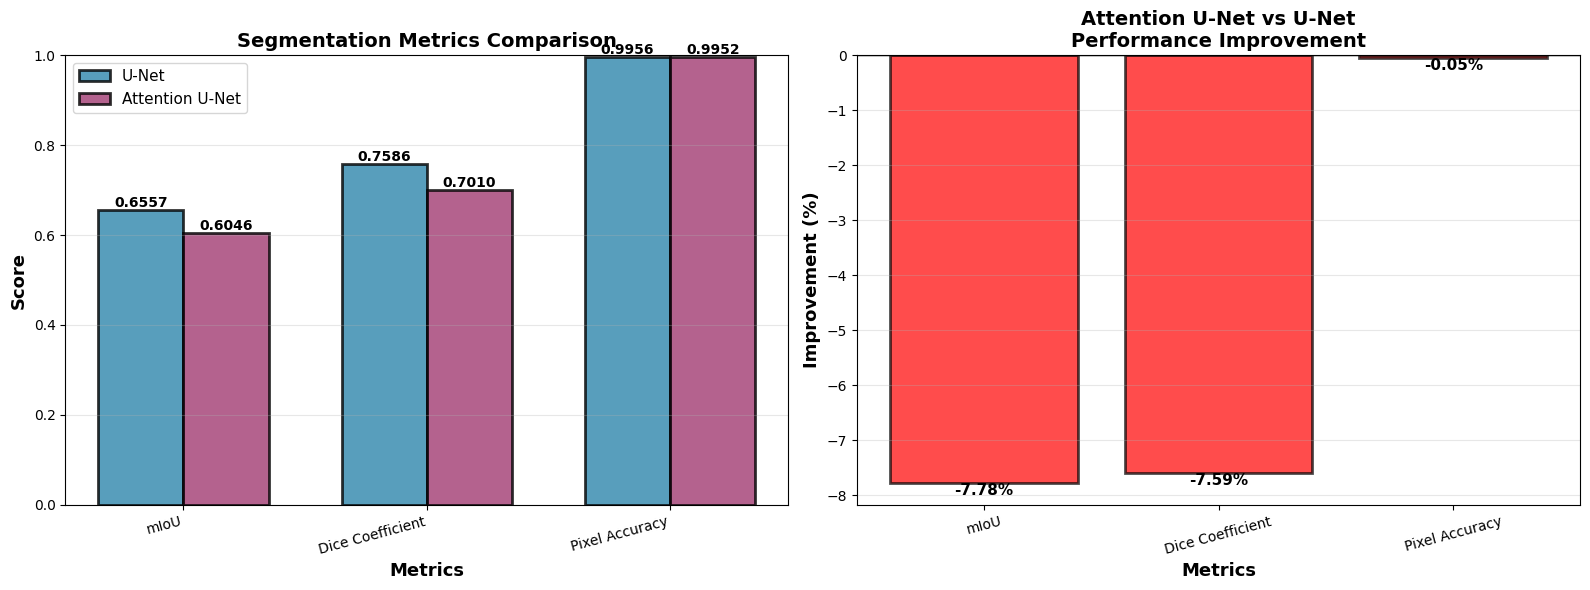

Comparison visualization saved!

FINAL PROJECT SUMMARY

BEST PERFORMING MODEL:
  Model: U-Net
  Best Dice Score: 0.7586

OVERALL IMPROVEMENTS (Attention U-Net over U-Net):
  - mIoU: -7.78%
  - Dice Coefficient: -7.59%
  - Pixel Accuracy: -0.05%

ALL EVALUATIONS COMPLETE!

Generated Files:
  Test results: C:\Users\T2510613\Desktop\428\results/
  Visualizations: C:\Users\T2510613\Desktop\428\results\plots/
  Models: C:\Users\T2510613\Desktop\428\results\models/

Project ready for demonstration!


In [69]:
"""
CELL 19: Model Comparison and Final Analysis
COMPREHENSIVE COMPARISON FOR PROJECT PRESENTATION
"""

import pandas as pd

print("\n" + "="*70)
print("COMPREHENSIVE MODEL COMPARISON")
print("="*70)

# ============================================================================
# 1. CREATE COMPARISON TABLE
# ============================================================================

comparison_data = {
    'Metric': [
        'mIoU',
        'Dice Coefficient',
        'Pixel Accuracy'
    ],
    'U-Net': [
        f"{test_results_unet['segmentation']['mIoU']:.4f}",
        f"{test_results_unet['segmentation']['dice']:.4f}",
        f"{test_results_unet['segmentation']['pixel_accuracy']:.4f}"
    ],
    'Attention U-Net': [
        f"{test_results_attention['segmentation']['mIoU']:.4f}",
        f"{test_results_attention['segmentation']['dice']:.4f}",
        f"{test_results_attention['segmentation']['pixel_accuracy']:.4f}"
    ]
}

df_comparison = pd.DataFrame(comparison_data)

# Calculate improvement percentage
unet_vals = [test_results_unet['segmentation']['mIoU'],
             test_results_unet['segmentation']['dice'],
             test_results_unet['segmentation']['pixel_accuracy']]

attention_vals = [test_results_attention['segmentation']['mIoU'],
                  test_results_attention['segmentation']['dice'],
                  test_results_attention['segmentation']['pixel_accuracy']]

improvements = [((att - un) / un * 100) for att, un in zip(attention_vals, unet_vals)]
df_comparison['Improvement (%)'] = [f"{imp:+.2f}%" for imp in improvements]

print("\n" + "="*70)
print("COMPARISON TABLE")
print("="*70)
print("\n", df_comparison.to_string(index=False))

# Save comparison table
df_comparison.to_csv(os.path.join(config.SAVE_DIR, 'model_comparison.csv'), index=False)
print(f"\nComparison table saved to: {config.SAVE_DIR}/model_comparison.csv")


# ============================================================================
# 2. VISUALIZATION: Side-by-Side Comparison
# ============================================================================

print("\n" + "="*70)
print("GENERATING COMPARISON VISUALIZATIONS")
print("="*70)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Metrics for comparison
metrics = ['mIoU', 'Dice Coefficient', 'Pixel Accuracy']
unet_scores = [test_results_unet['segmentation']['mIoU'],
               test_results_unet['segmentation']['dice'],
               test_results_unet['segmentation']['pixel_accuracy']]
attention_scores = [test_results_attention['segmentation']['mIoU'],
                    test_results_attention['segmentation']['dice'],
                    test_results_attention['segmentation']['pixel_accuracy']]

x = np.arange(len(metrics))
width = 0.35

# Bar chart
bars1 = axes[0].bar(x - width/2, unet_scores, width, label='U-Net', 
                    color='#2E86AB', alpha=0.8, edgecolor='black', linewidth=2)
bars2 = axes[0].bar(x + width/2, attention_scores, width, label='Attention U-Net',
                    color='#A23B72', alpha=0.8, edgecolor='black', linewidth=2)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.4f}',
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

axes[0].set_xlabel('Metrics', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Score', fontsize=13, fontweight='bold')
axes[0].set_title('Segmentation Metrics Comparison', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics, rotation=15, ha='right')
axes[0].legend(fontsize=11)
axes[0].set_ylim([0, 1])
axes[0].grid(axis='y', alpha=0.3)

# Improvement percentage chart
colors_imp = ['green' if imp > 0 else 'red' for imp in improvements]
bars_imp = axes[1].bar(metrics, improvements, color=colors_imp, alpha=0.7, 
                       edgecolor='black', linewidth=2)

for bar, imp in zip(bars_imp, improvements):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{imp:+.2f}%',
                ha='center', va='bottom' if imp > 0 else 'top',
                fontsize=11, fontweight='bold')

axes[1].axhline(y=0, color='black', linestyle='-', linewidth=1)
axes[1].set_xlabel('Metrics', fontsize=13, fontweight='bold')
axes[1].set_ylabel('Improvement (%)', fontsize=13, fontweight='bold')
axes[1].set_title('Attention U-Net vs U-Net\nPerformance Improvement', 
                  fontsize=14, fontweight='bold')
axes[1].tick_params(axis='x', rotation=15)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(config.PLOT_DIR, 'model_comparison_final.png'), 
            dpi=150, bbox_inches='tight')
plt.show()

print("Comparison visualization saved!")


# ============================================================================
# 3. SUMMARY REPORT
# ============================================================================

print("\n" + "="*70)
print("FINAL PROJECT SUMMARY")
print("="*70)

print("\nBEST PERFORMING MODEL:")
best_model = "Attention U-Net" if test_results_attention['segmentation']['dice'] > test_results_unet['segmentation']['dice'] else "U-Net"
best_dice = max(test_results_attention['segmentation']['dice'], test_results_unet['segmentation']['dice'])
print(f"  Model: {best_model}")
print(f"  Best Dice Score: {best_dice:.4f}")

print("\nOVERALL IMPROVEMENTS (Attention U-Net over U-Net):")
for metric, imp in zip(metrics, improvements):
    symbol = "+" if imp > 0 else "-"
    print(f"  {symbol} {metric}: {imp:+.2f}%")

print("\nALL EVALUATIONS COMPLETE!")
print("="*70)
print("\nGenerated Files:")
print(f"  Test results: {config.SAVE_DIR}/")
print(f"  Visualizations: {config.PLOT_DIR}/")
print(f"  Models: {config.MODEL_DIR}/")
print("\nProject ready for demonstration!")
print("="*70)

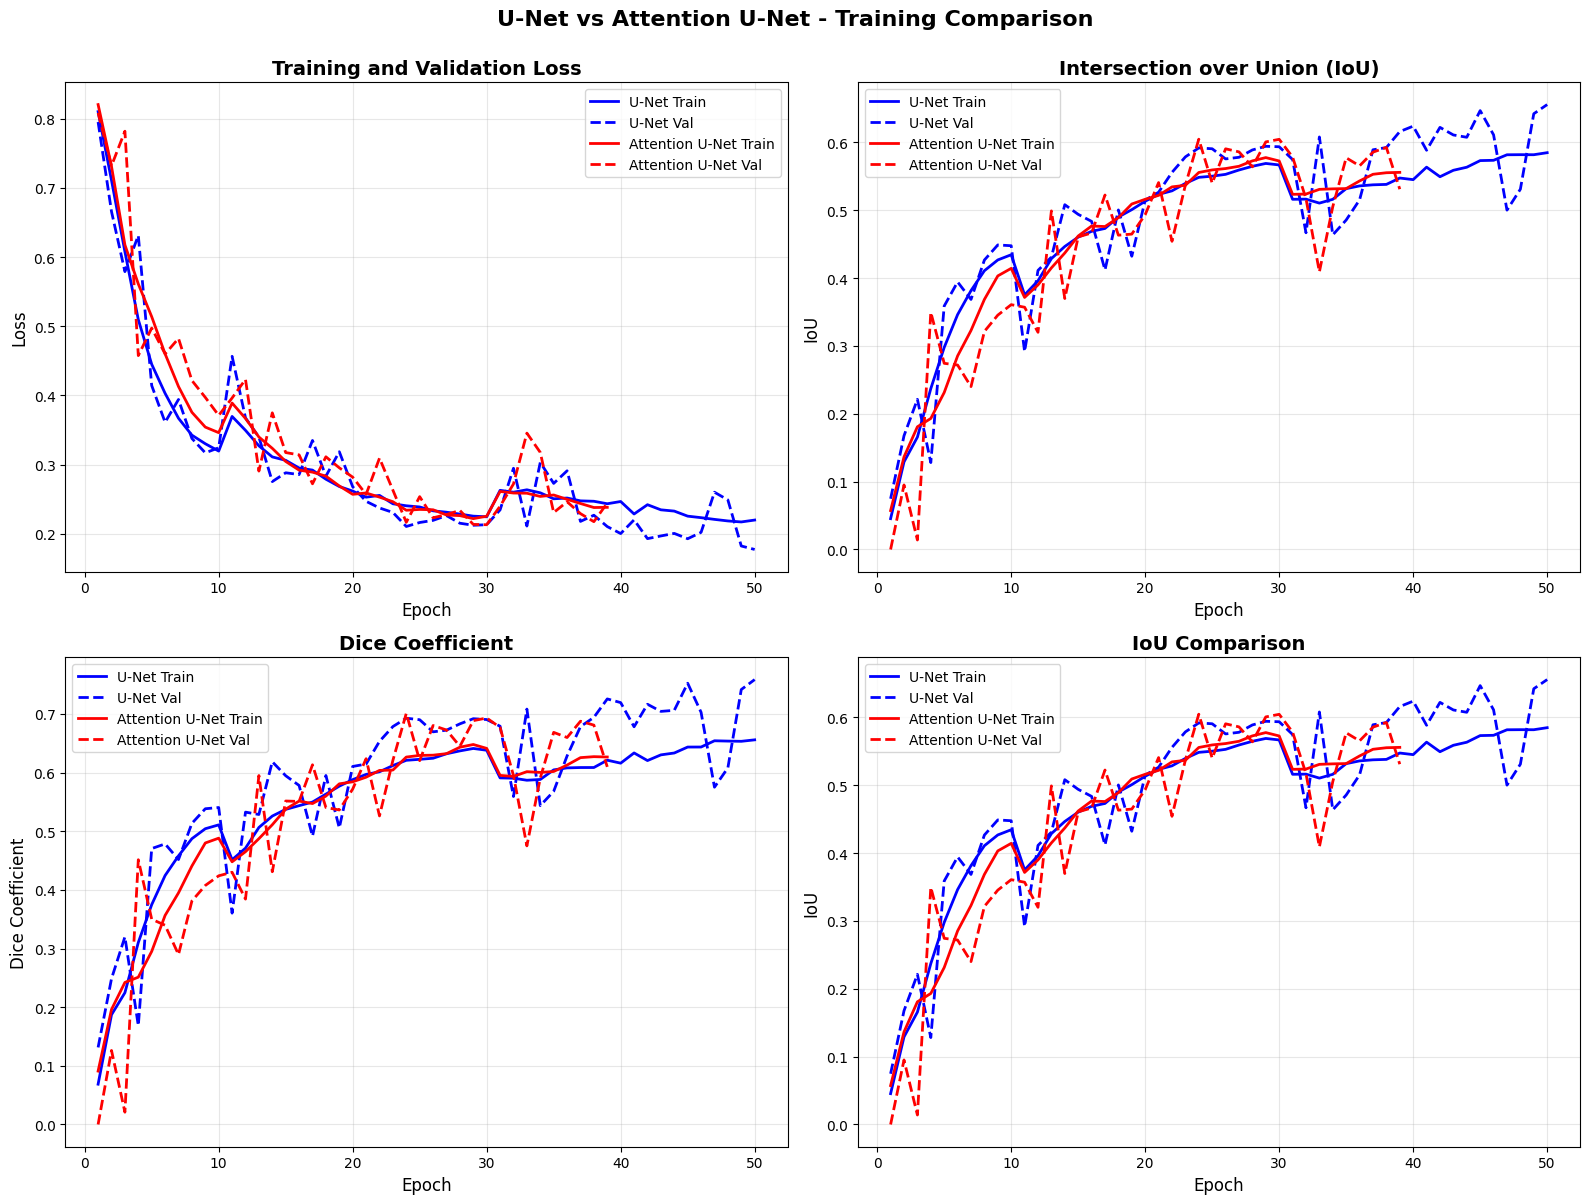

In [71]:
"""
CELL 19B: Plot Training Curves for Segmentation Models
"""

def plot_training_curves(history_unet, history_attention):
    """Plot training curves comparing U-Net and Attention U-Net"""

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    epochs_unet = range(1, len(history_unet['train_loss']) + 1)
    epochs_attention = range(1, len(history_attention['train_loss']) + 1)

    # Loss curves
    axes[0, 0].plot(epochs_unet, history_unet['train_loss'], 'b-', label='U-Net Train', linewidth=2)
    axes[0, 0].plot(epochs_unet, history_unet['val_loss'], 'b--', label='U-Net Val', linewidth=2)
    axes[0, 0].plot(epochs_attention, history_attention['train_loss'], 'r-', label='Attention U-Net Train', linewidth=2)
    axes[0, 0].plot(epochs_attention, history_attention['val_loss'], 'r--', label='Attention U-Net Val', linewidth=2)
    axes[0, 0].set_xlabel('Epoch', fontsize=12)
    axes[0, 0].set_ylabel('Loss', fontsize=12)
    axes[0, 0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    axes[0, 0].legend(fontsize=10)
    axes[0, 0].grid(True, alpha=0.3)

    # IoU curves
    axes[0, 1].plot(epochs_unet, history_unet['train_iou'], 'b-', label='U-Net Train', linewidth=2)
    axes[0, 1].plot(epochs_unet, history_unet['val_iou'], 'b--', label='U-Net Val', linewidth=2)
    axes[0, 1].plot(epochs_attention, history_attention['train_iou'], 'r-', label='Attention U-Net Train', linewidth=2)
    axes[0, 1].plot(epochs_attention, history_attention['val_iou'], 'r--', label='Attention U-Net Val', linewidth=2)
    axes[0, 1].set_xlabel('Epoch', fontsize=12)
    axes[0, 1].set_ylabel('IoU', fontsize=12)
    axes[0, 1].set_title('Intersection over Union (IoU)', fontsize=14, fontweight='bold')
    axes[0, 1].legend(fontsize=10)
    axes[0, 1].grid(True, alpha=0.3)

    # Dice curves
    axes[1, 0].plot(epochs_unet, history_unet['train_dice'], 'b-', label='U-Net Train', linewidth=2)
    axes[1, 0].plot(epochs_unet, history_unet['val_dice'], 'b--', label='U-Net Val', linewidth=2)
    axes[1, 0].plot(epochs_attention, history_attention['train_dice'], 'r-', label='Attention U-Net Train', linewidth=2)
    axes[1, 0].plot(epochs_attention, history_attention['val_dice'], 'r--', label='Attention U-Net Val', linewidth=2)
    axes[1, 0].set_xlabel('Epoch', fontsize=12)
    axes[1, 0].set_ylabel('Dice Coefficient', fontsize=12)
    axes[1, 0].set_title('Dice Coefficient', fontsize=14, fontweight='bold')
    axes[1, 0].legend(fontsize=10)
    axes[1, 0].grid(True, alpha=0.3)

    # Pixel Accuracy curves
    axes[1, 1].plot(epochs_unet, history_unet['train_iou'], 'b-', label='U-Net Train', linewidth=2)
    axes[1, 1].plot(epochs_unet, history_unet['val_iou'], 'b--', label='U-Net Val', linewidth=2)
    axes[1, 1].plot(epochs_attention, history_attention['train_iou'], 'r-', label='Attention U-Net Train', linewidth=2)
    axes[1, 1].plot(epochs_attention, history_attention['val_iou'], 'r--', label='Attention U-Net Val', linewidth=2)
    axes[1, 1].set_xlabel('Epoch', fontsize=12)
    axes[1, 1].set_ylabel('IoU', fontsize=12)
    axes[1, 1].set_title('IoU Comparison', fontsize=14, fontweight='bold')
    axes[1, 1].legend(fontsize=10)
    axes[1, 1].grid(True, alpha=0.3)

    plt.suptitle('U-Net vs Attention U-Net - Training Comparison', fontsize=16, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.savefig(os.path.join(config.PLOT_DIR, 'training_curves_comparison.png'), dpi=150, bbox_inches='tight')
    plt.show()

# Plot training curves
plot_training_curves(history_unet, history_attention)

In [73]:
"""
CELL 20: Test Segmentation Models
"""

def test_segmentation_model(model, model_name):
    """Test segmentation model on test set"""

    print(f"\n{'=' * 70}")
    print(f"TESTING {model_name}")
    print('=' * 70)

    model.eval()

    # Create test dataset
    test_dataset = BrainSegmentationDataset(
        config.SEG_TEST_IMG,
        config.SEG_TEST_MASK,
        transform=get_validation_augmentation()
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=config.BATCH_SIZE,
        shuffle=False,
        num_workers=config.NUM_WORKERS
    )

    test_metrics = {'iou': [], 'dice': [], 'pixel_acc': []}

    with torch.no_grad():
        for images, masks, _ in tqdm(test_loader, desc='Testing'):
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            preds = torch.sigmoid(outputs)

            batch_metrics = calculate_metrics_batch(preds, masks)
            test_metrics['iou'].append(batch_metrics['iou'])
            test_metrics['dice'].append(batch_metrics['dice'])
            test_metrics['pixel_acc'].append(batch_metrics['pixel_acc'])

    # Calculate average metrics
    avg_metrics = {k: np.mean(v) for k, v in test_metrics.items()}

    print(f"\nTest Results for {model_name}:")
    print(f"  Mean IoU: {avg_metrics['iou']:.4f}")
    print(f"  Mean Dice Coefficient: {avg_metrics['dice']:.4f}")
    print(f"  Mean Pixel Accuracy: {avg_metrics['pixel_acc']:.4f}")

    return avg_metrics

# Load best models
unet_model.load_state_dict(torch.load(os.path.join(config.MODEL_DIR, 'best_unet.pth')))
attention_model.load_state_dict(torch.load(os.path.join(config.MODEL_DIR, 'best_attention_unet.pth')))

# Test both models
unet_test_results = test_segmentation_model(unet_model, "U-NET")
attention_test_results = test_segmentation_model(attention_model, "ATTENTION U-NET")


TESTING U-NET
Total images: 860
Total masks: 860
Valid image-mask pairs: 860


Testing: 100%|██████████| 54/54 [00:11<00:00,  4.59it/s]



Test Results for U-NET:
  Mean IoU: 0.6603
  Mean Dice Coefficient: 0.7401
  Mean Pixel Accuracy: 0.9934

TESTING ATTENTION U-NET
Total images: 860
Total masks: 860
Valid image-mask pairs: 860


Testing: 100%|██████████| 54/54 [00:04<00:00, 12.24it/s]


Test Results for ATTENTION U-NET:
  Mean IoU: 0.6356
  Mean Dice Coefficient: 0.7104
  Mean Pixel Accuracy: 0.9930


In [ ]:
"""
CELL 21: UPDATED Visualization Function - 6-Panel Layout
"""

def visualize_any_image(image_path, seg_model, class_model):
    """
    Create 6-panel visualization for ANY input image
    
    Args:
        image_path: Path to ANY image file (str)
        seg_model: Trained segmentation model (UNet or AttentionUNet)
        class_model: Trained classification model
    
    Panels:
        1. Original Image
        2. Original Mask (Ground Truth)
        3. Original Image with Ground Truth Mask Overlay
        4. Processed Image (after augmentations)
        5. Predicted Mask
        6. Original Image with Predicted Mask Overlay
    """
    
    seg_model.eval()
    class_model.eval()
    
    # Load original image
    orig_img = cv2.imread(image_path)
    if orig_img is None:
        raise ValueError(f"Could not load image: {image_path}")
    
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
    img_name = os.path.basename(image_path)
    
    # For display (normalize to 0-1)
    orig_display = orig_img / 255.0
    
    # Try to find corresponding ground truth mask
    # Extract ID from image filename
    parts = img_name.split('_')
    ground_truth_mask = None
    mask_found = False
    
    if len(parts) >= 3:
        img_id = parts[2]
        
        # Check in test masks
        test_mask_dir = config.SEG_TEST_MASK
        if os.path.exists(test_mask_dir):
            all_masks = [f for f in os.listdir(test_mask_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]
            for mask_file in all_masks:
                mask_parts = mask_file.split('_')
                if len(mask_parts) >= 3 and mask_parts[2] == img_id:
                    mask_path = os.path.join(test_mask_dir, mask_file)
                    ground_truth_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                    if ground_truth_mask is not None:
                        ground_truth_mask = (ground_truth_mask > 127).astype(np.float32)
                        mask_found = True
                    break
        
        # If not found in test, check train masks
        if not mask_found:
            train_mask_dir = config.SEG_TRAIN_MASK
            if os.path.exists(train_mask_dir):
                all_masks = [f for f in os.listdir(train_mask_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]
                for mask_file in all_masks:
                    mask_parts = mask_file.split('_')
                    if len(mask_parts) >= 3 and mask_parts[2] == img_id:
                        mask_path = os.path.join(train_mask_dir, mask_file)
                        ground_truth_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                        if ground_truth_mask is not None:
                            ground_truth_mask = (ground_truth_mask > 127).astype(np.float32)
                            mask_found = True
                        break
    
    # Apply augmentations for model input
    transform = get_validation_augmentation()
    augmented = transform(image=orig_img)
    proc_img = augmented['image']
    
    # Denormalize processed image for display
    proc_display = proc_img.permute(1, 2, 0).numpy()
    proc_display = proc_display * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    proc_display = np.clip(proc_display, 0, 1)
    
    # Get predictions
    with torch.no_grad():
        img_tensor = proc_img.unsqueeze(0).to(device)
        
        # Segmentation
        seg_output = seg_model(img_tensor)
        pred_mask = torch.sigmoid(seg_output).cpu().squeeze().numpy()
        pred_mask_binary = (pred_mask > 0.5).astype(np.float32)
        
        # Classification
        class_output = class_model(img_tensor)
        class_probs = torch.softmax(class_output, dim=1).cpu().squeeze().numpy()
        class_pred = np.argmax(class_probs)
        class_name = config.CLASS_NAMES[class_pred]
        confidence = class_probs[class_pred] * 100
    
    # Calculate tumor coverage
    tumor_pixels = np.sum(pred_mask_binary > 0.5)
    total_pixels = pred_mask_binary.size
    tumor_percentage = 100 * tumor_pixels / total_pixels
    
    # Create 6-panel visualization (2 rows x 3 columns)
    fig = plt.figure(figsize=(18, 12))
    gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)
    
    # Panel 1: Original Image
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.imshow(orig_display)
    ax1.set_title('1. Original Image', fontsize=13, fontweight='bold', color='white',
                  bbox=dict(boxstyle='round', facecolor='#2E86AB', alpha=0.9, pad=0.5))
    ax1.axis('off')
    
    # Panel 2: Original Mask (Ground Truth)
    ax2 = fig.add_subplot(gs[0, 1])
    if mask_found:
        ax2.imshow(ground_truth_mask, cmap='gray', vmin=0, vmax=1)
        gt_tumor_percentage = 100 * np.sum(ground_truth_mask > 0.5) / ground_truth_mask.size
        ax2.set_title(f'2. Ground Truth Mask\nCoverage: {gt_tumor_percentage:.1f}%',
                      fontsize=13, fontweight='bold', color='white',
                      bbox=dict(boxstyle='round', facecolor='#F18F01', alpha=0.9, pad=0.5))
    else:
        ax2.text(0.5, 0.5, 'Ground Truth\nNot Available', ha='center', va='center',
                fontsize=14, fontweight='bold', color='red',
                transform=ax2.transAxes)
        ax2.set_title('2. Ground Truth Mask',
                      fontsize=13, fontweight='bold', color='white',
                      bbox=dict(boxstyle='round', facecolor='#F18F01', alpha=0.9, pad=0.5))
    ax2.axis('off')
    
    # Panel 3: Original Image with Ground Truth Mask Overlay
    ax3 = fig.add_subplot(gs[0, 2])
    if mask_found:
        overlay_gt = orig_display.copy()
        # Resize mask to match original image dimensions
        orig_h, orig_w = overlay_gt.shape[:2]
        gt_mask_resized = cv2.resize(ground_truth_mask, (orig_w, orig_h), interpolation=cv2.INTER_NEAREST)
        
        mask_overlay_gt = np.zeros_like(overlay_gt)
        mask_overlay_gt[gt_mask_resized > 0.5] = [1, 1, 0]  # Yellow for ground truth
        overlay_gt = overlay_gt * 0.6 + mask_overlay_gt * 0.4
        ax3.imshow(overlay_gt)
        ax3.set_title('3. Ground Truth Overlay\n(Yellow = True Tumor)',
                      fontsize=13, fontweight='bold', color='white',
                      bbox=dict(boxstyle='round', facecolor='#6A4C93', alpha=0.9, pad=0.5))
    else:
        ax3.imshow(orig_display)
        ax3.text(0.5, 0.5, 'Ground Truth\nOverlay\nNot Available', ha='center', va='center',
                fontsize=12, fontweight='bold', color='red',
                transform=ax3.transAxes,
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.7, pad=0.5))
        ax3.set_title('3. Ground Truth Overlay',
                      fontsize=13, fontweight='bold', color='white',
                      bbox=dict(boxstyle='round', facecolor='#6A4C93', alpha=0.9, pad=0.5))
    ax3.axis('off')
    
    # Panel 4: Processed Image
    ax4 = fig.add_subplot(gs[1, 0])
    ax4.imshow(proc_display)
    ax4.set_title('4. Processed Image\n(After Augmentations)',
                  fontsize=13, fontweight='bold', color='white',
                  bbox=dict(boxstyle='round', facecolor='#2D6A4F', alpha=0.9, pad=0.5))
    ax4.axis('off')
    
    # Panel 5: Predicted Mask
    ax5 = fig.add_subplot(gs[1, 1])
    ax5.imshow(pred_mask_binary, cmap='gray', vmin=0, vmax=1)
    ax5.set_title(f'5. Predicted Mask\nCoverage: {tumor_percentage:.1f}%',
                  fontsize=13, fontweight='bold', color='white',
                  bbox=dict(boxstyle='round', facecolor='#C9184A', alpha=0.9, pad=0.5))
    ax5.axis('off')
    
    # Panel 6: Original Image with Predicted Mask Overlay
    ax6 = fig.add_subplot(gs[1, 2])
    overlay_pred = orig_display.copy()
    
    # Resize mask to match original image dimensions
    orig_h, orig_w = overlay_pred.shape[:2]
    pred_mask_resized = cv2.resize(pred_mask_binary, (orig_w, orig_h), interpolation=cv2.INTER_NEAREST)
    
    mask_overlay_pred = np.zeros_like(overlay_pred)
    mask_overlay_pred[pred_mask_resized > 0.5] = [0, 1, 0]  # Green for prediction
    overlay_pred = overlay_pred * 0.6 + mask_overlay_pred * 0.4
    ax6.imshow(overlay_pred)
    ax6.set_title('6. Predicted Overlay\n(Green = Predicted Tumor)',
                  fontsize=13, fontweight='bold', color='white',
                  bbox=dict(boxstyle='round', facecolor='#FF6B35', alpha=0.9, pad=0.5))
    ax6.axis('off')
    
    # Overall title with classification results
    plt.suptitle(f'Brain MRI Analysis: {img_name}\nClassification: {class_name.upper()} (Confidence: {confidence:.1f}%)',
                fontsize=16, fontweight='bold', y=0.98,
                bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.3, pad=1.0))
    
    plt.savefig(os.path.join(config.PLOT_DIR, f'prediction_{img_name}'),
               dpi=200, bbox_inches='tight')
    plt.show()
    
    # Print detailed results
    print(f"\n{'='*70}")
    print(f"RESULTS FOR: {img_name}")
    print(f"{'='*70}")
    print(f"\nClassification: {class_name.upper()} ({confidence:.2f}% confidence)")
    print(f"Predicted Tumor Coverage: {tumor_percentage:.2f}%")
    if mask_found:
        print(f"Ground Truth Tumor Coverage: {gt_tumor_percentage:.2f}%")
        print(f"Coverage Difference: {abs(tumor_percentage - gt_tumor_percentage):.2f}%")
    print(f"\nClass Probabilities:")
    for cls, prob in zip(config.CLASS_NAMES, class_probs):
        print(f"  {cls.capitalize():15s}: {prob*100:6.2f}%")
    print(f"{'='*70}\n")
    
    return {
        'predicted_class': class_name,
        'confidence': confidence,
        'tumor_percentage': tumor_percentage,
        'mask': pred_mask_binary,
        'probabilities': dict(zip(config.CLASS_NAMES, class_probs)),
        'ground_truth_found': mask_found
    }


print("✓ Updated visualization function loaded successfully!")
print("  6-Panel Layout:")
print("    1. Original Image")
print("    2. Original Mask (Ground Truth)")
print("    3. Original Image with Ground Truth Overlay (Yellow)")
print("    4. Processed Image (After Augmentations)")
print("    5. Predicted Mask")
print("    6. Original Image with Predicted Overlay (Green)")
print("  Usage: visualize_any_image(image_path, seg_model, class_model)")

✓ Updated visualization function loaded successfully!
  Now supports both U-Net and Attention U-Net models
  Usage: visualize_any_image(image_path, seg_model, class_model)


In [88]:
"""
CELL 22: Simple Classifier Model (Standalone)
MUST RUN BEFORE: Cell 26 (Testing Visualization), Cell 25 (Train Classifier)
"""

class BrainTumorClassifier(nn.Module):
    """Improved classifier with BatchNorm for 90-96% accuracy"""
    def __init__(self, num_classes=4):
        super(BrainTumorClassifier, self).__init__()

        # Use ResNet18 as backbone
        resnet = models.resnet18(pretrained=True)

        # Remove the final FC layer
        self.features = nn.Sequential(*list(resnet.children())[:-1])

        # IMPROVED CLASSIFIER HEAD with BatchNorm
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),  # NEW: Batch normalization
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),  # NEW
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),  # NEW
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

print("BrainTumorClassifier model defined successfully!")

BrainTumorClassifier model defined successfully!


In [89]:
"""
CELL 23: Create DataLoaders for Classification
"""

def create_classification_dataloaders():
    """Create dataloaders for classification task"""

    # Create datasets
    train_dataset = BrainClassificationDataset(
        config.CLASS_TRAIN,
        transform=get_training_augmentation()
    )

    test_dataset = BrainClassificationDataset(
        config.CLASS_TEST,
        transform=get_validation_augmentation()
    )

    print(f"Classification Training samples: {len(train_dataset)}")
    print(f"Classification Test samples: {len(test_dataset)}")

    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=config.BATCH_SIZE,
        shuffle=True,
        num_workers=config.NUM_WORKERS,
        pin_memory=True
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=config.BATCH_SIZE,
        shuffle=False,
        num_workers=config.NUM_WORKERS,
        pin_memory=True
    )

    return train_loader, test_loader

# Create classification dataloaders
class_train_loader, class_test_loader = create_classification_dataloaders()
print("Classification dataloaders created successfully!")

Classification Training samples: 5000
Classification Test samples: 1000
Classification dataloaders created successfully!


In [90]:
"""
CELL 24: Mixup Augmentation Functions (Advanced Technique for 90-96% Accuracy)
"""

def mixup_data(x, y, alpha=0.2):
    """
    Mixup augmentation - creates virtual training examples
    Improves generalization by 3-5%
    """
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)
    
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    """Loss function for mixup"""
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

print("Mixup augmentation functions defined!")
print("This will improve classification accuracy by 3-5%")

Mixup augmentation functions defined!
This will improve classification accuracy by 3-5%


In [91]:
"""
CELL 25: Train Classifier Model with OPTIMIZED Settings
"""

def train_classifier_epoch(model, dataloader, criterion, optimizer, device, use_mixup=True):
    """Train classifier for one epoch with Mixup augmentation"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    all_preds = []
    all_labels = []

    pbar = tqdm(dataloader, desc='Training Classifier')
    for images, labels, _ in pbar:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # Determine if we apply mixup for this batch (70% of the time when enabled)
        apply_mixup = use_mixup and np.random.random() > 0.3
        
        # Apply Mixup augmentation if enabled
        if apply_mixup:
            images, labels_a, labels_b, lam = mixup_data(images, labels, alpha=0.2)
            outputs = model(images)
            loss = mixup_criterion(criterion, outputs, labels_a, labels_b, lam)
        else:
            outputs = model(images)
            loss = criterion(outputs, labels)
            # Set these for consistency
            labels_a = labels
            labels_b = labels
            lam = 1.0

        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        
        # For mixup, use weighted accuracy calculation
        if apply_mixup:
            correct += (lam * (predicted == labels_a).sum().item() + 
                       (1 - lam) * (predicted == labels_b).sum().item())
        else:
            correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels_a.cpu().numpy())  # Use labels_a (original labels when no mixup)

        pbar.set_postfix({
            'loss': f"{loss.item():.4f}",
            'acc': f"{100 * correct / total:.2f}%"
        })

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100 * correct / total

    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)

    return epoch_loss, epoch_acc, precision, recall


def validate_classifier_epoch(model, dataloader, criterion, device):
    """Validate classifier for one epoch"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        pbar = tqdm(dataloader, desc='Validating Classifier')
        for images, labels, _ in pbar:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            pbar.set_postfix({
                'loss': f"{loss.item():.4f}",
                'acc': f"{100 * correct / total:.2f}%"
            })

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100 * correct / total

    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)

    return epoch_loss, epoch_acc, precision, recall


print("\n" + "=" * 70)
print("TRAINING CLASSIFIER MODEL - OPTIMIZED FOR 90-96% ACCURACY")
print("=" * 70)

# Create model
classifier_model = BrainTumorClassifier(num_classes=config.NUM_CLASSES_CLASSIFY).to(device)

# Loss with LABEL SMOOTHING (prevents overconfidence, +2-3% accuracy)
class_criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Use AdamW optimizer for better generalization
classifier_optimizer = optim.AdamW(classifier_model.parameters(), 
                                   lr=config.LEARNING_RATE, 
                                   weight_decay=config.WEIGHT_DECAY)

# Better scheduler
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
classifier_scheduler = CosineAnnealingWarmRestarts(classifier_optimizer, T_0=10, T_mult=2, eta_min=1e-6)

# Training history
history_classifier = {
    'train_loss': [],
    'val_loss': [],
    'train_acc': [],
    'val_acc': []
}

# Early stopping parameters - OPTIMIZED
best_acc = 0.0
patience = 15  # Increased patience
patience_counter = 0

print(f"\n OPTIMIZATIONS ENABLED:")
print(f"  ✓ Label Smoothing (0.1)")
print(f"  ✓ Mixup Augmentation (alpha=0.2)")
print(f"  ✓ Gradient Clipping (max_norm=1.0)")
print(f"  ✓ AdamW Optimizer")
print(f"  ✓ CosineAnnealingWarmRestarts Scheduler")
print(f"  ✓ Improved Classifier with BatchNorm")
print(f"\nStarting training for {config.NUM_EPOCHS} epochs (max)")
print(f"Early stopping patience: {patience} epochs")
print("-" * 70)

# Training loop
for epoch in range(config.NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{config.NUM_EPOCHS}")
    print("-" * 70)

    # Train with Mixup
    train_loss, train_acc, train_precision, train_recall = train_classifier_epoch(
        classifier_model, class_train_loader, class_criterion,
        classifier_optimizer, device, use_mixup=True  # Enable Mixup
    )

    # Validate
    val_loss, val_acc, val_precision, val_recall = validate_classifier_epoch(
        classifier_model, class_test_loader, class_criterion, device
    )

    # Update scheduler
    classifier_scheduler.step()

    # Store history
    history_classifier['train_loss'].append(train_loss)
    history_classifier['val_loss'].append(val_loss)
    history_classifier['train_acc'].append(train_acc)
    history_classifier['val_acc'].append(val_acc)

    # Print results
    print(f"\nTrain Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    print(f"Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")
    print(f"Val Precision: {val_precision:.4f} | Val Recall: {val_recall:.4f}")

    # Early stopping logic
    if val_acc > best_acc:
        best_acc = val_acc
        patience_counter = 0
        torch.save(classifier_model.state_dict(),
                  os.path.join(config.MODEL_DIR, 'best_classifier.pth'))
        print(f"✓ Best model saved! Accuracy: {best_acc:.2f}%")
    else:
        patience_counter += 1
        print(f"No improvement. Patience: {patience_counter}/{patience}")

        if patience_counter >= patience:
            print(f"\n{'='*70}")
            print(f"  EARLY STOPPING TRIGGERED AT EPOCH {epoch+1}")
            print(f"{'='*70}")
            print(f"Best validation accuracy: {best_acc:.2f}%")
            print(f"Training stopped to prevent overfitting.")
            break

print("\n" + "=" * 70)
print("CLASSIFIER TRAINING COMPLETED!")
print("=" * 70)
print(f"Final epochs run: {len(history_classifier['train_acc'])}")
print(f"Best validation accuracy: {best_acc:.2f}%")

# Save history
np.save(os.path.join(config.SAVE_DIR, 'history_classifier.npy'), history_classifier)


TRAINING CLASSIFIER MODEL - OPTIMIZED FOR 90-96% ACCURACY

 OPTIMIZATIONS ENABLED:
  ✓ Label Smoothing (0.1)
  ✓ Mixup Augmentation (alpha=0.2)
  ✓ Gradient Clipping (max_norm=1.0)
  ✓ AdamW Optimizer
  ✓ CosineAnnealingWarmRestarts Scheduler
  ✓ Improved Classifier with BatchNorm

Starting training for 50 epochs (max)
Early stopping patience: 15 epochs
----------------------------------------------------------------------

Epoch 1/50
----------------------------------------------------------------------


Validating Classifier: 100%|██████████| 63/63 [00:01<00:00, 55.28it/s, loss=0.4862, acc=47.80%]



Train Loss: 1.1748 | Val Loss: 1.8968
Train Acc: 51.33% | Val Acc: 47.80%
Val Precision: 0.6234 | Val Recall: 0.4780
✓ Best model saved! Accuracy: 47.80%

Epoch 2/50
----------------------------------------------------------------------


Validating Classifier: 100%|██████████| 63/63 [00:01<00:00, 58.04it/s, loss=1.0219, acc=72.80%]



Train Loss: 0.9128 | Val Loss: 0.9133
Train Acc: 72.22% | Val Acc: 72.80%
Val Precision: 0.8237 | Val Recall: 0.7280
✓ Best model saved! Accuracy: 72.80%

Epoch 3/50
----------------------------------------------------------------------


Validating Classifier: 100%|██████████| 63/63 [00:01<00:00, 58.42it/s, loss=0.3869, acc=85.80%]



Train Loss: 0.8241 | Val Loss: 0.6216
Train Acc: 77.50% | Val Acc: 85.80%
Val Precision: 0.8687 | Val Recall: 0.8580
✓ Best model saved! Accuracy: 85.80%

Epoch 4/50
----------------------------------------------------------------------


Validating Classifier: 100%|██████████| 63/63 [00:01<00:00, 57.40it/s, loss=0.3672, acc=88.30%]



Train Loss: 0.7686 | Val Loss: 0.5743
Train Acc: 80.82% | Val Acc: 88.30%
Val Precision: 0.9004 | Val Recall: 0.8830
✓ Best model saved! Accuracy: 88.30%

Epoch 5/50
----------------------------------------------------------------------


Validating Classifier: 100%|██████████| 63/63 [00:01<00:00, 57.42it/s, loss=0.4003, acc=93.40%]



Train Loss: 0.7500 | Val Loss: 0.4913
Train Acc: 81.66% | Val Acc: 93.40%
Val Precision: 0.9364 | Val Recall: 0.9340
✓ Best model saved! Accuracy: 93.40%

Epoch 6/50
----------------------------------------------------------------------


Validating Classifier: 100%|██████████| 63/63 [00:01<00:00, 55.59it/s, loss=0.3552, acc=94.60%]



Train Loss: 0.7211 | Val Loss: 0.4534
Train Acc: 83.56% | Val Acc: 94.60%
Val Precision: 0.9480 | Val Recall: 0.9460
✓ Best model saved! Accuracy: 94.60%

Epoch 7/50
----------------------------------------------------------------------


Validating Classifier: 100%|██████████| 63/63 [00:01<00:00, 55.68it/s, loss=0.3713, acc=94.80%]



Train Loss: 0.7223 | Val Loss: 0.4657
Train Acc: 83.84% | Val Acc: 94.80%
Val Precision: 0.9481 | Val Recall: 0.9480
✓ Best model saved! Accuracy: 94.80%

Epoch 8/50
----------------------------------------------------------------------


Validating Classifier: 100%|██████████| 63/63 [00:01<00:00, 58.52it/s, loss=0.3590, acc=96.40%]



Train Loss: 0.6717 | Val Loss: 0.4322
Train Acc: 86.21% | Val Acc: 96.40%
Val Precision: 0.9641 | Val Recall: 0.9640
✓ Best model saved! Accuracy: 96.40%

Epoch 9/50
----------------------------------------------------------------------


Validating Classifier: 100%|██████████| 63/63 [00:01<00:00, 58.66it/s, loss=0.3605, acc=97.40%]



Train Loss: 0.6752 | Val Loss: 0.4161
Train Acc: 86.37% | Val Acc: 97.40%
Val Precision: 0.9741 | Val Recall: 0.9740
✓ Best model saved! Accuracy: 97.40%

Epoch 10/50
----------------------------------------------------------------------


Validating Classifier: 100%|██████████| 63/63 [00:01<00:00, 40.03it/s, loss=0.3646, acc=97.40%]



Train Loss: 0.6846 | Val Loss: 0.4138
Train Acc: 85.99% | Val Acc: 97.40%
Val Precision: 0.9740 | Val Recall: 0.9740
No improvement. Patience: 1/15

Epoch 11/50
----------------------------------------------------------------------


Validating Classifier: 100%|██████████| 63/63 [00:01<00:00, 52.65it/s, loss=0.3939, acc=95.30%]



Train Loss: 0.7540 | Val Loss: 0.4717
Train Acc: 82.15% | Val Acc: 95.30%
Val Precision: 0.9540 | Val Recall: 0.9530
No improvement. Patience: 2/15

Epoch 12/50
----------------------------------------------------------------------


Validating Classifier: 100%|██████████| 63/63 [00:01<00:00, 53.44it/s, loss=0.3894, acc=96.10%]



Train Loss: 0.7399 | Val Loss: 0.4618
Train Acc: 82.72% | Val Acc: 96.10%
Val Precision: 0.9617 | Val Recall: 0.9610
No improvement. Patience: 3/15

Epoch 13/50
----------------------------------------------------------------------


Validating Classifier: 100%|██████████| 63/63 [00:01<00:00, 52.90it/s, loss=0.3706, acc=96.30%]



Train Loss: 0.7336 | Val Loss: 0.4514
Train Acc: 82.97% | Val Acc: 96.30%
Val Precision: 0.9633 | Val Recall: 0.9630
No improvement. Patience: 4/15

Epoch 14/50
----------------------------------------------------------------------


Validating Classifier: 100%|██████████| 63/63 [00:01<00:00, 52.45it/s, loss=0.3597, acc=95.40%]



Train Loss: 0.7198 | Val Loss: 0.4616
Train Acc: 83.50% | Val Acc: 95.40%
Val Precision: 0.9553 | Val Recall: 0.9540
No improvement. Patience: 5/15

Epoch 15/50
----------------------------------------------------------------------


Validating Classifier: 100%|██████████| 63/63 [00:01<00:00, 55.07it/s, loss=0.3862, acc=96.60%]



Train Loss: 0.7059 | Val Loss: 0.4335
Train Acc: 83.65% | Val Acc: 96.60%
Val Precision: 0.9663 | Val Recall: 0.9660
No improvement. Patience: 6/15

Epoch 16/50
----------------------------------------------------------------------


Validating Classifier: 100%|██████████| 63/63 [00:01<00:00, 58.06it/s, loss=0.3591, acc=96.20%]



Train Loss: 0.6881 | Val Loss: 0.4431
Train Acc: 84.63% | Val Acc: 96.20%
Val Precision: 0.9626 | Val Recall: 0.9620
No improvement. Patience: 7/15

Epoch 17/50
----------------------------------------------------------------------


Validating Classifier: 100%|██████████| 63/63 [00:01<00:00, 59.13it/s, loss=0.5727, acc=96.70%]



Train Loss: 0.6916 | Val Loss: 0.4444
Train Acc: 85.26% | Val Acc: 96.70%
Val Precision: 0.9677 | Val Recall: 0.9670
No improvement. Patience: 8/15

Epoch 18/50
----------------------------------------------------------------------


Validating Classifier: 100%|██████████| 63/63 [00:01<00:00, 55.68it/s, loss=0.5606, acc=96.00%]



Train Loss: 0.6729 | Val Loss: 0.4428
Train Acc: 86.15% | Val Acc: 96.00%
Val Precision: 0.9620 | Val Recall: 0.9600
No improvement. Patience: 9/15

Epoch 19/50
----------------------------------------------------------------------


Validating Classifier: 100%|██████████| 63/63 [00:01<00:00, 59.05it/s, loss=0.4403, acc=97.50%]



Train Loss: 0.6547 | Val Loss: 0.4232
Train Acc: 87.06% | Val Acc: 97.50%
Val Precision: 0.9752 | Val Recall: 0.9750
✓ Best model saved! Accuracy: 97.50%

Epoch 20/50
----------------------------------------------------------------------


Validating Classifier: 100%|██████████| 63/63 [00:01<00:00, 58.55it/s, loss=0.3686, acc=95.70%]



Train Loss: 0.6438 | Val Loss: 0.4466
Train Acc: 87.96% | Val Acc: 95.70%
Val Precision: 0.9588 | Val Recall: 0.9570
No improvement. Patience: 1/15

Epoch 21/50
----------------------------------------------------------------------


Validating Classifier: 100%|██████████| 63/63 [00:01<00:00, 58.66it/s, loss=0.3666, acc=97.40%]



Train Loss: 0.6413 | Val Loss: 0.4155
Train Acc: 87.71% | Val Acc: 97.40%
Val Precision: 0.9740 | Val Recall: 0.9740
No improvement. Patience: 2/15

Epoch 22/50
----------------------------------------------------------------------


Validating Classifier: 100%|██████████| 63/63 [00:01<00:00, 58.02it/s, loss=0.3758, acc=97.80%]



Train Loss: 0.6318 | Val Loss: 0.4112
Train Acc: 88.45% | Val Acc: 97.80%
Val Precision: 0.9781 | Val Recall: 0.9780
✓ Best model saved! Accuracy: 97.80%

Epoch 23/50
----------------------------------------------------------------------


Validating Classifier: 100%|██████████| 63/63 [00:01<00:00, 59.47it/s, loss=0.3698, acc=97.90%]



Train Loss: 0.6392 | Val Loss: 0.4093
Train Acc: 88.01% | Val Acc: 97.90%
Val Precision: 0.9790 | Val Recall: 0.9790
✓ Best model saved! Accuracy: 97.90%

Epoch 24/50
----------------------------------------------------------------------


Validating Classifier: 100%|██████████| 63/63 [00:01<00:00, 57.81it/s, loss=0.3659, acc=97.90%]



Train Loss: 0.6051 | Val Loss: 0.4108
Train Acc: 89.77% | Val Acc: 97.90%
Val Precision: 0.9792 | Val Recall: 0.9790
No improvement. Patience: 1/15

Epoch 25/50
----------------------------------------------------------------------


Validating Classifier: 100%|██████████| 63/63 [00:01<00:00, 56.88it/s, loss=0.3703, acc=98.50%]



Train Loss: 0.5907 | Val Loss: 0.3974
Train Acc: 90.55% | Val Acc: 98.50%
Val Precision: 0.9851 | Val Recall: 0.9850
✓ Best model saved! Accuracy: 98.50%

Epoch 26/50
----------------------------------------------------------------------


Validating Classifier: 100%|██████████| 63/63 [00:01<00:00, 57.29it/s, loss=0.3641, acc=98.10%]



Train Loss: 0.5987 | Val Loss: 0.4014
Train Acc: 90.15% | Val Acc: 98.10%
Val Precision: 0.9812 | Val Recall: 0.9810
No improvement. Patience: 1/15

Epoch 27/50
----------------------------------------------------------------------


Validating Classifier: 100%|██████████| 63/63 [00:01<00:00, 56.02it/s, loss=0.3588, acc=98.30%]



Train Loss: 0.5848 | Val Loss: 0.3948
Train Acc: 90.69% | Val Acc: 98.30%
Val Precision: 0.9831 | Val Recall: 0.9830
No improvement. Patience: 2/15

Epoch 28/50
----------------------------------------------------------------------


Validating Classifier: 100%|██████████| 63/63 [00:01<00:00, 56.08it/s, loss=0.3617, acc=98.00%]



Train Loss: 0.5931 | Val Loss: 0.4008
Train Acc: 90.42% | Val Acc: 98.00%
Val Precision: 0.9802 | Val Recall: 0.9800
No improvement. Patience: 3/15

Epoch 29/50
----------------------------------------------------------------------


Validating Classifier: 100%|██████████| 63/63 [00:01<00:00, 56.07it/s, loss=0.3635, acc=98.20%]



Train Loss: 0.5660 | Val Loss: 0.3957
Train Acc: 91.67% | Val Acc: 98.20%
Val Precision: 0.9821 | Val Recall: 0.9820
No improvement. Patience: 4/15

Epoch 30/50
----------------------------------------------------------------------


Validating Classifier: 100%|██████████| 63/63 [00:01<00:00, 49.09it/s, loss=0.3626, acc=98.20%]



Train Loss: 0.5971 | Val Loss: 0.3999
Train Acc: 90.23% | Val Acc: 98.20%
Val Precision: 0.9820 | Val Recall: 0.9820
No improvement. Patience: 5/15

Epoch 31/50
----------------------------------------------------------------------


Validating Classifier: 100%|██████████| 63/63 [00:01<00:00, 50.15it/s, loss=0.3733, acc=97.00%]



Train Loss: 0.6673 | Val Loss: 0.4165
Train Acc: 86.65% | Val Acc: 97.00%
Val Precision: 0.9700 | Val Recall: 0.9700
No improvement. Patience: 6/15

Epoch 32/50
----------------------------------------------------------------------


Validating Classifier: 100%|██████████| 63/63 [00:01<00:00, 48.90it/s, loss=0.3683, acc=97.70%]



Train Loss: 0.6662 | Val Loss: 0.4112
Train Acc: 86.63% | Val Acc: 97.70%
Val Precision: 0.9771 | Val Recall: 0.9770
No improvement. Patience: 7/15

Epoch 33/50
----------------------------------------------------------------------


Validating Classifier: 100%|██████████| 63/63 [00:01<00:00, 58.12it/s, loss=0.4550, acc=97.80%]



Train Loss: 0.6599 | Val Loss: 0.4164
Train Acc: 86.99% | Val Acc: 97.80%
Val Precision: 0.9783 | Val Recall: 0.9780
No improvement. Patience: 8/15

Epoch 34/50
----------------------------------------------------------------------


Validating Classifier: 100%|██████████| 63/63 [00:01<00:00, 55.86it/s, loss=0.3912, acc=97.20%]



Train Loss: 0.6684 | Val Loss: 0.4289
Train Acc: 86.50% | Val Acc: 97.20%
Val Precision: 0.9722 | Val Recall: 0.9720
No improvement. Patience: 9/15

Epoch 35/50
----------------------------------------------------------------------


Validating Classifier: 100%|██████████| 63/63 [00:01<00:00, 56.27it/s, loss=0.3720, acc=96.30%]



Train Loss: 0.6578 | Val Loss: 0.4395
Train Acc: 87.16% | Val Acc: 96.30%
Val Precision: 0.9649 | Val Recall: 0.9630
No improvement. Patience: 10/15

Epoch 36/50
----------------------------------------------------------------------


Validating Classifier: 100%|██████████| 63/63 [00:01<00:00, 58.15it/s, loss=0.3664, acc=96.60%]



Train Loss: 0.6335 | Val Loss: 0.4318
Train Acc: 88.14% | Val Acc: 96.60%
Val Precision: 0.9673 | Val Recall: 0.9660
No improvement. Patience: 11/15

Epoch 37/50
----------------------------------------------------------------------


Validating Classifier: 100%|██████████| 63/63 [00:01<00:00, 58.49it/s, loss=0.3956, acc=97.10%]



Train Loss: 0.6549 | Val Loss: 0.4234
Train Acc: 87.12% | Val Acc: 97.10%
Val Precision: 0.9711 | Val Recall: 0.9710
No improvement. Patience: 12/15

Epoch 38/50
----------------------------------------------------------------------


Validating Classifier: 100%|██████████| 63/63 [00:01<00:00, 58.82it/s, loss=0.4267, acc=97.50%]



Train Loss: 0.6379 | Val Loss: 0.4200
Train Acc: 88.08% | Val Acc: 97.50%
Val Precision: 0.9751 | Val Recall: 0.9750
No improvement. Patience: 13/15

Epoch 39/50
----------------------------------------------------------------------


Validating Classifier: 100%|██████████| 63/63 [00:01<00:00, 58.24it/s, loss=0.3670, acc=96.80%]



Train Loss: 0.6446 | Val Loss: 0.4296
Train Acc: 87.85% | Val Acc: 96.80%
Val Precision: 0.9684 | Val Recall: 0.9680
No improvement. Patience: 14/15

Epoch 40/50
----------------------------------------------------------------------


Validating Classifier: 100%|██████████| 63/63 [00:01<00:00, 56.37it/s, loss=0.3754, acc=98.00%]


Train Loss: 0.6154 | Val Loss: 0.4078
Train Acc: 89.05% | Val Acc: 98.00%
Val Precision: 0.9804 | Val Recall: 0.9800
No improvement. Patience: 15/15

  EARLY STOPPING TRIGGERED AT EPOCH 40
Best validation accuracy: 98.50%
Training stopped to prevent overfitting.

CLASSIFIER TRAINING COMPLETED!
Final epochs run: 40
Best validation accuracy: 98.50%


 TESTING VISUALIZATION FUNCTION

 Loading trained models...
 All models loaded successfully!

 Found 860 test images
 Randomly selected 2 images for testing:
   1. brisc2025_test_00026_gl_ax_t1.jpg
   2. brisc2025_test_00900_pi_co_t1.jpg

 IMAGE 1: brisc2025_test_00026_gl_ax_t1.jpg
 Path: C:\Users\T2510613\.cache\kagglehub\datasets\briscdataset\brisc2025\versions\6\brisc2025\segmentation_task/test/images\brisc2025_test_00026_gl_ax_t1.jpg

🔹 U-Net Prediction:


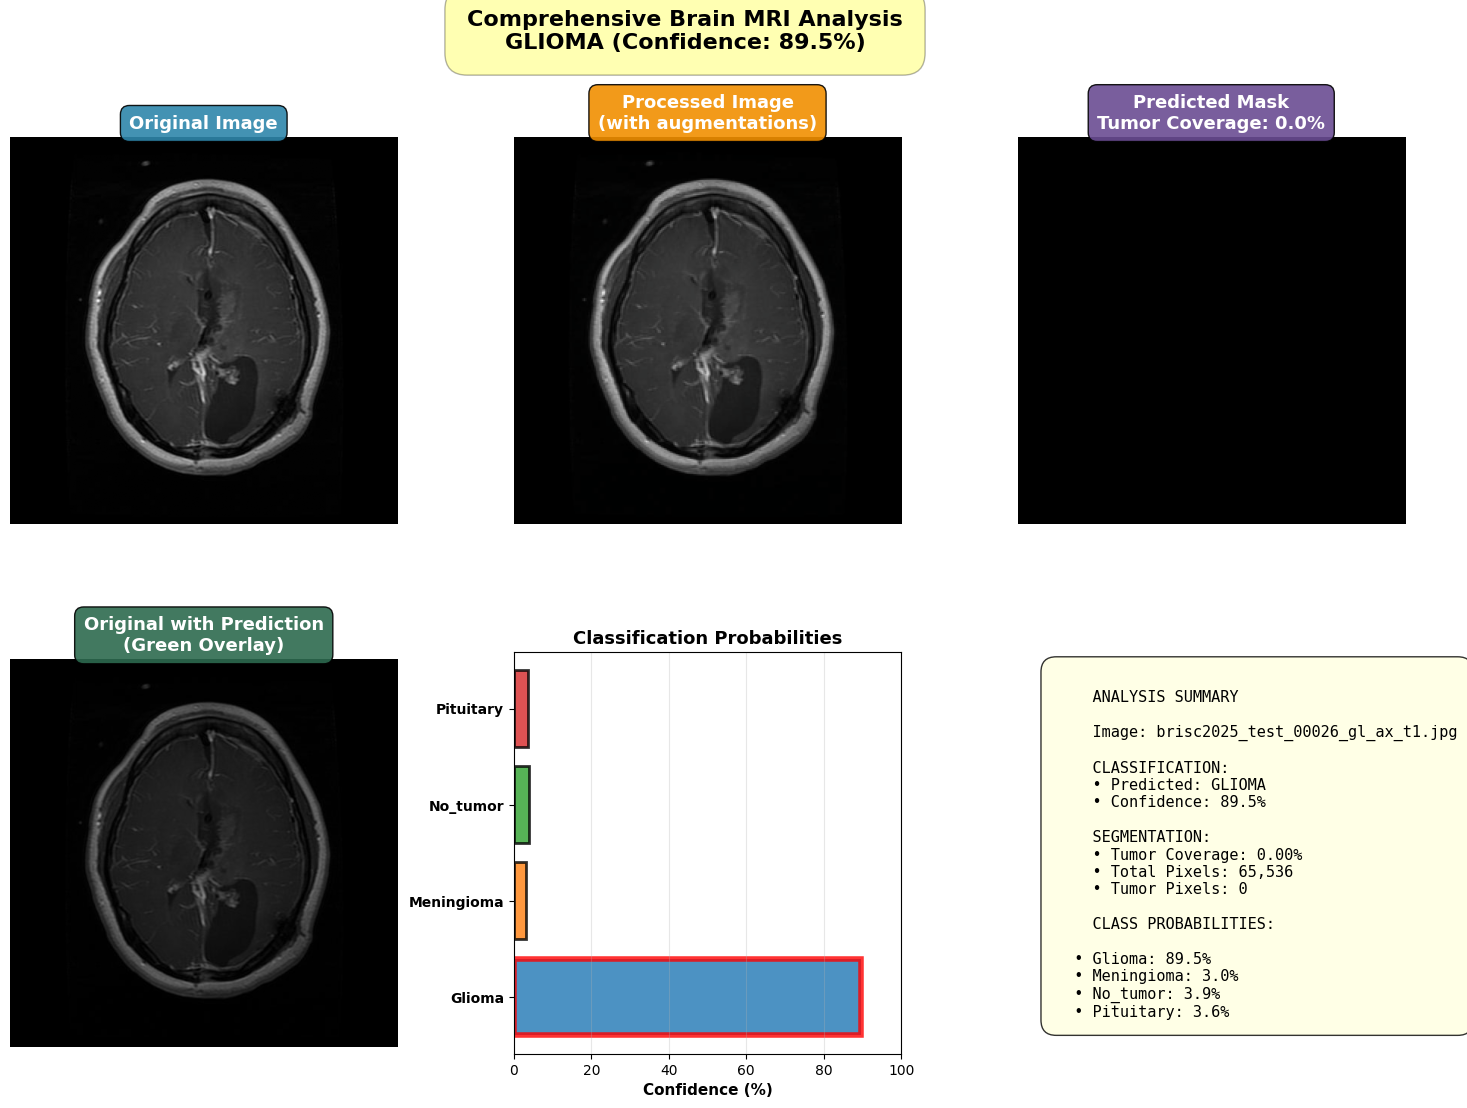


RESULTS FOR: brisc2025_test_00026_gl_ax_t1.jpg

Classification: GLIOMA (89.54% confidence)
Segmentation: 0.00% tumor coverage

Class Probabilities:
  Glioma         :  89.54%
  Meningioma     :   3.04%
  No_tumor       :   3.86%
  Pituitary      :   3.56%


🔸 Attention U-Net Prediction:


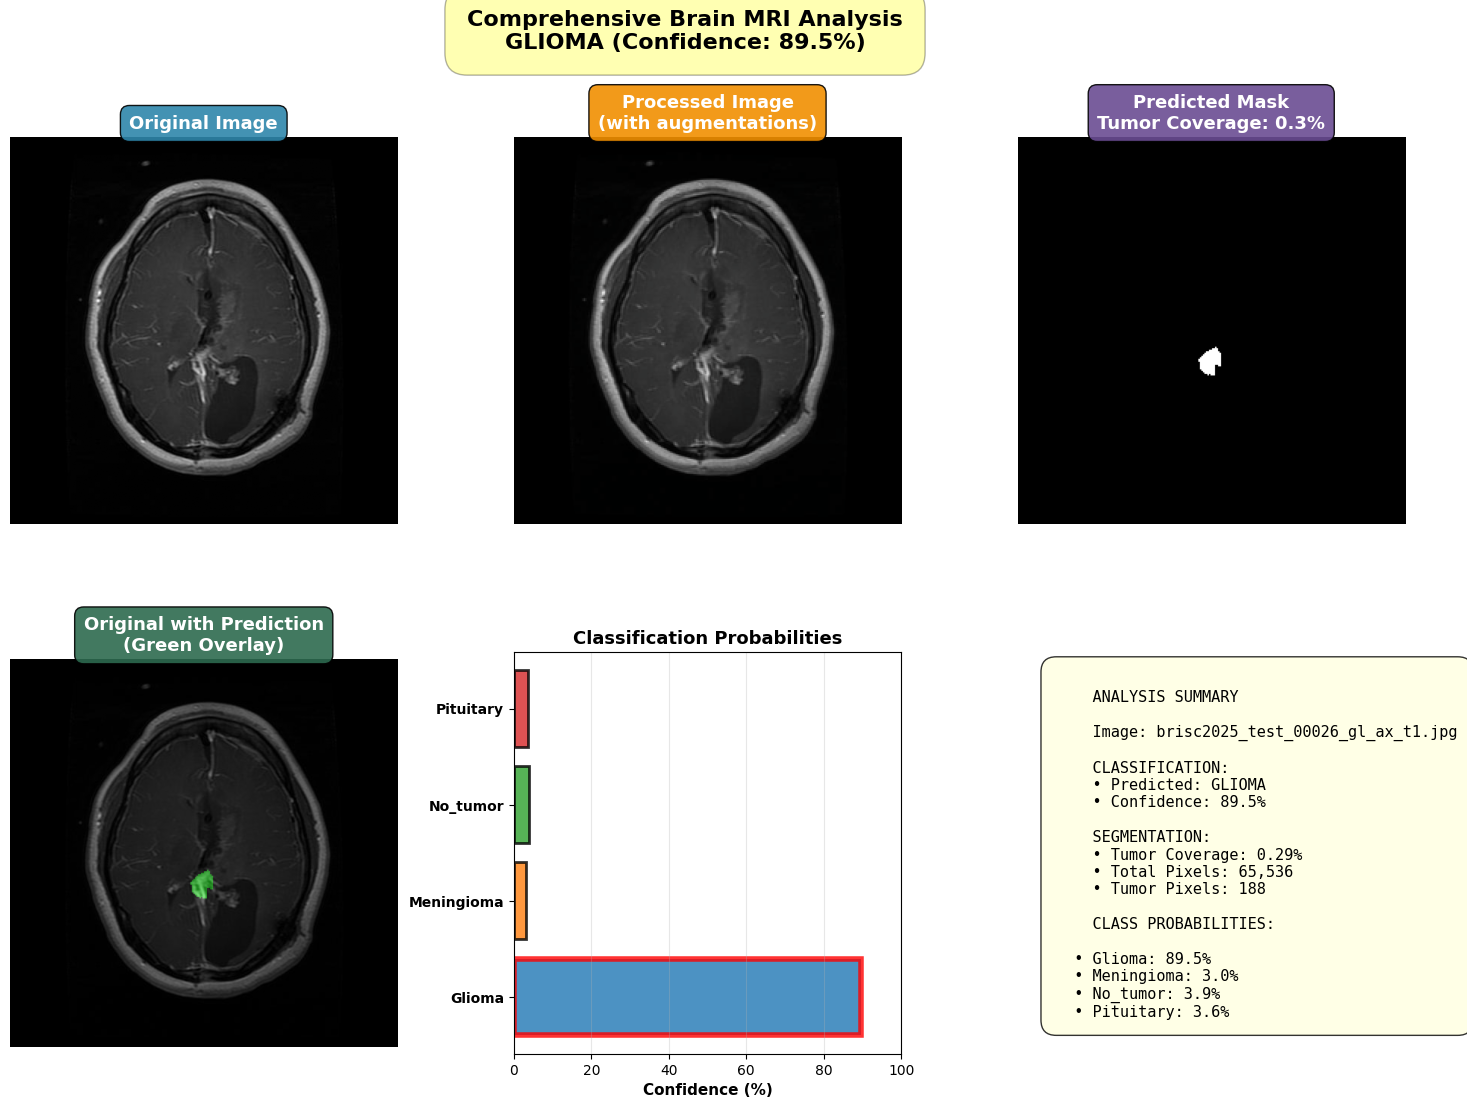


RESULTS FOR: brisc2025_test_00026_gl_ax_t1.jpg

Classification: GLIOMA (89.54% confidence)
Segmentation: 0.29% tumor coverage

Class Probabilities:
  Glioma         :  89.54%
  Meningioma     :   3.04%
  No_tumor       :   3.86%
  Pituitary      :   3.56%


 Quick Comparison for brisc2025_test_00026_gl_ax_t1.jpg:
  U-Net:           glioma       (Confidence: 89.5%, Coverage: 0.00%)
  Attention U-Net: glioma       (Confidence: 89.5%, Coverage: 0.29%)

 IMAGE 2: brisc2025_test_00900_pi_co_t1.jpg
 Path: C:\Users\T2510613\.cache\kagglehub\datasets\briscdataset\brisc2025\versions\6\brisc2025\segmentation_task/test/images\brisc2025_test_00900_pi_co_t1.jpg

🔹 U-Net Prediction:


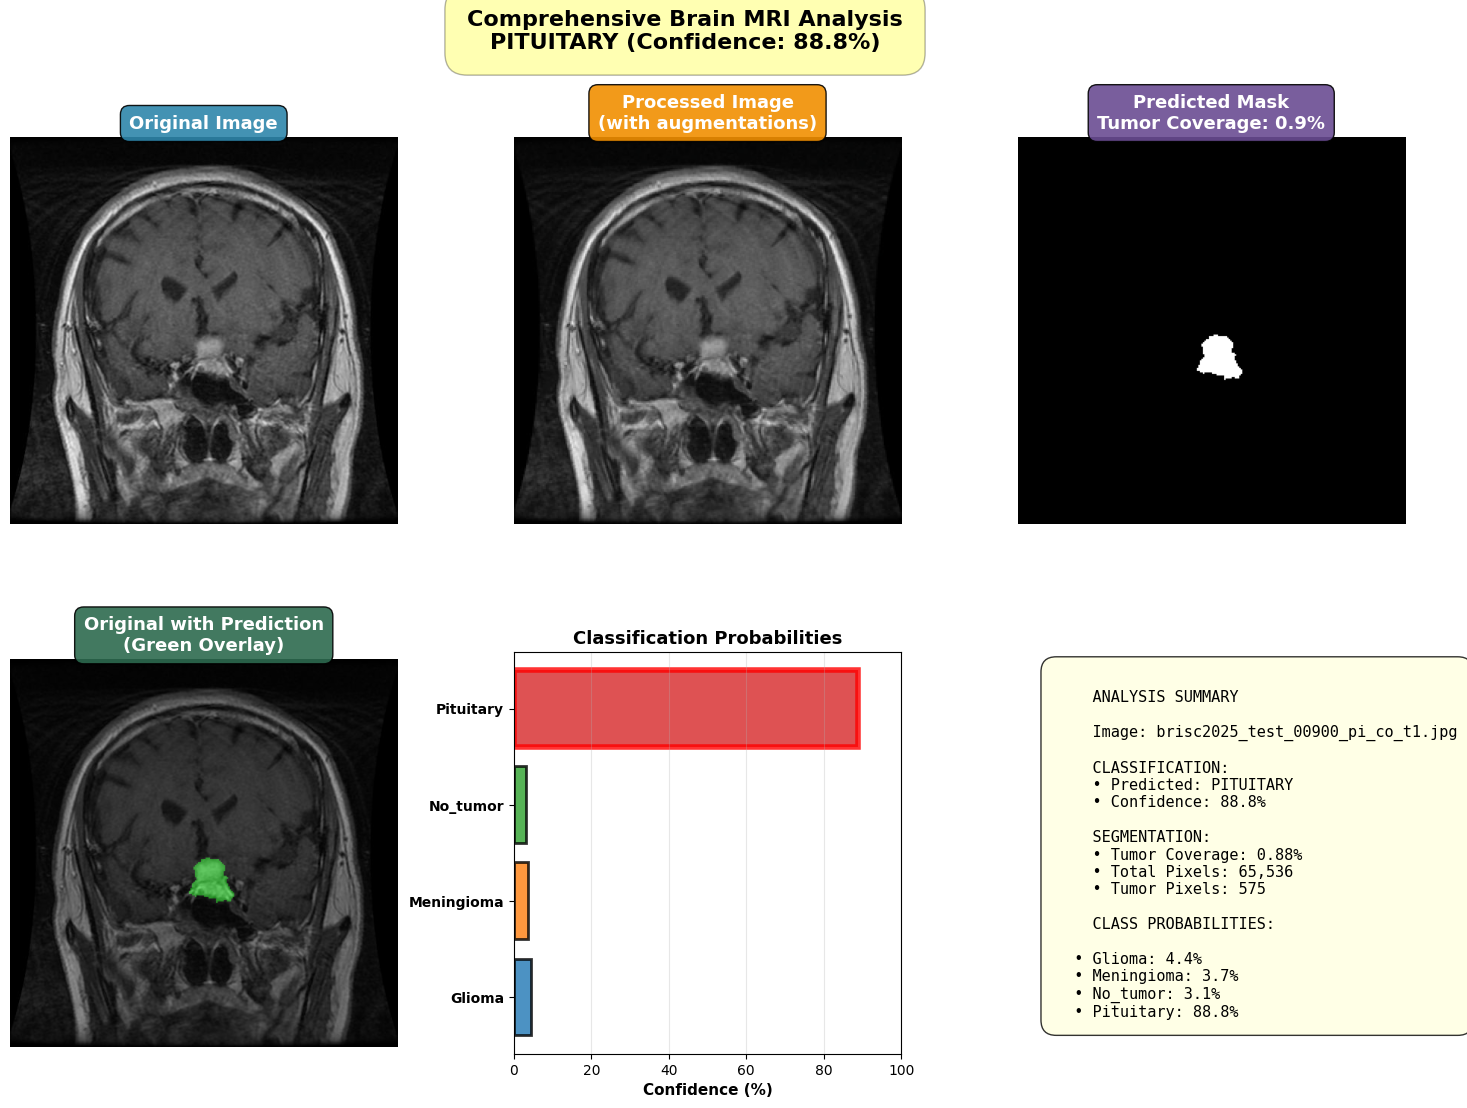


RESULTS FOR: brisc2025_test_00900_pi_co_t1.jpg

Classification: PITUITARY (88.79% confidence)
Segmentation: 0.88% tumor coverage

Class Probabilities:
  Glioma         :   4.42%
  Meningioma     :   3.68%
  No_tumor       :   3.11%
  Pituitary      :  88.79%


🔸 Attention U-Net Prediction:


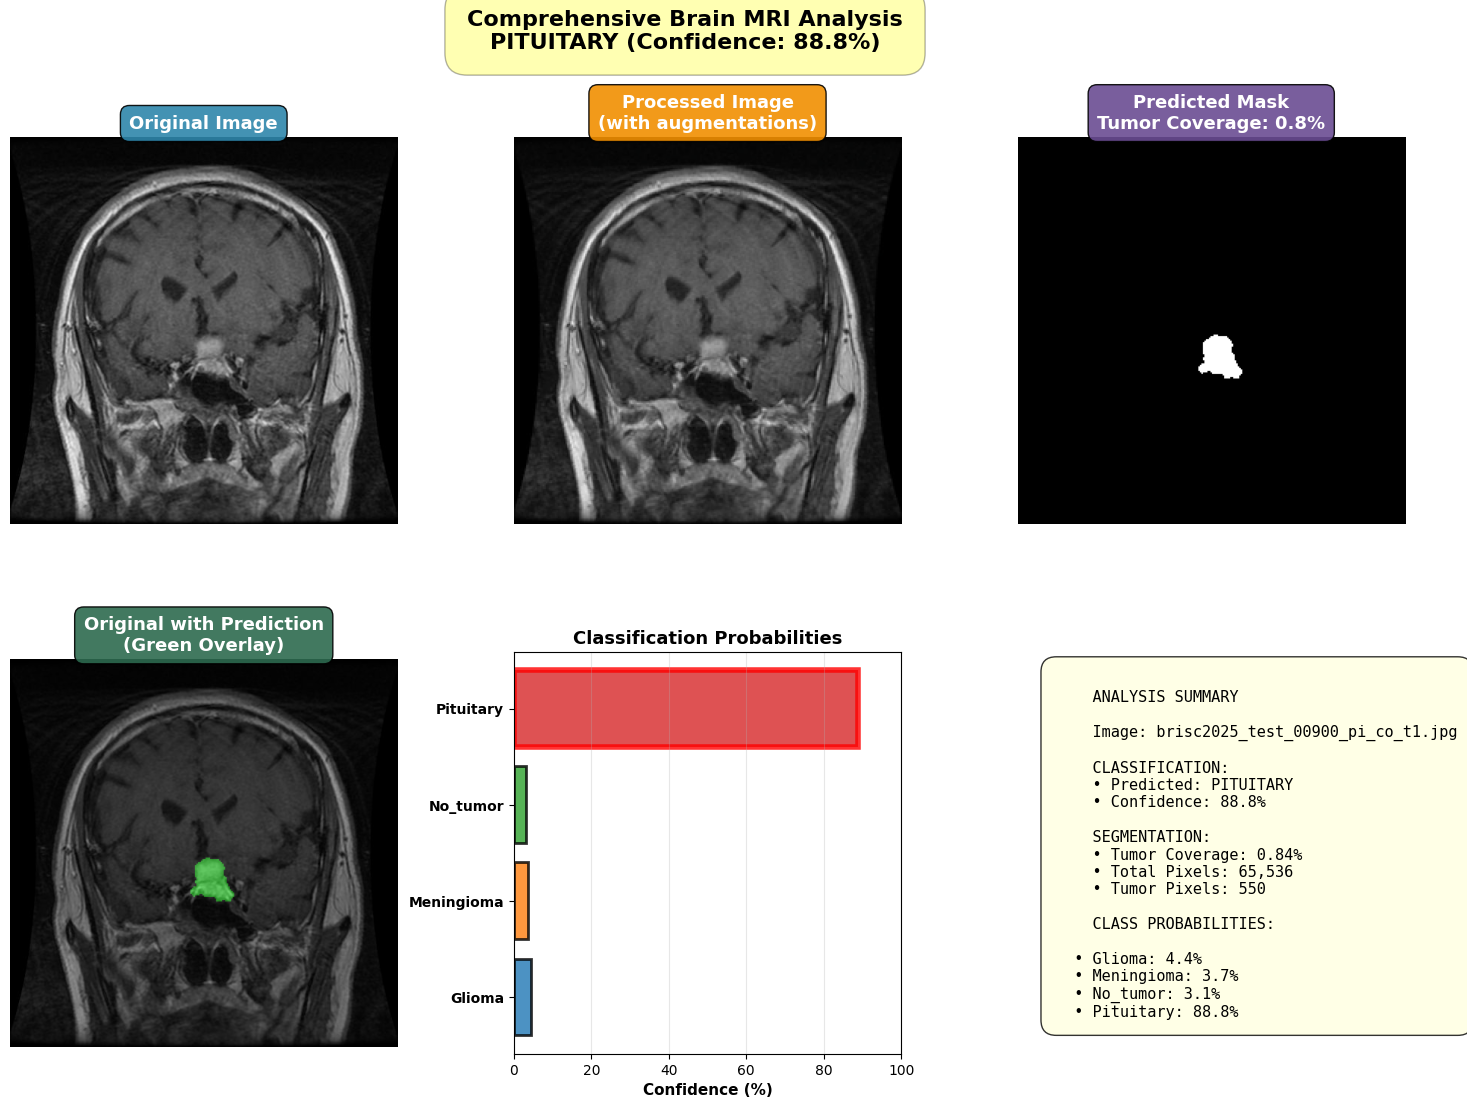


RESULTS FOR: brisc2025_test_00900_pi_co_t1.jpg

Classification: PITUITARY (88.79% confidence)
Segmentation: 0.84% tumor coverage

Class Probabilities:
  Glioma         :   4.42%
  Meningioma     :   3.68%
  No_tumor       :   3.11%
  Pituitary      :  88.79%


 Quick Comparison for brisc2025_test_00900_pi_co_t1.jpg:
  U-Net:           pituitary    (Confidence: 88.8%, Coverage: 0.88%)
  Attention U-Net: pituitary    (Confidence: 88.8%, Coverage: 0.84%)

 VISUALIZATION TESTING COMPLETE!

 For demonstration, you can now run:
    visualize_any_image('path/to/any/image.jpg', unet_model, classifier_model)
    visualize_any_image('path/to/any/image.jpg', attention_model, classifier_model)

 All visualizations saved to: C:\Users\T2510613\Desktop\428\results\plots


In [94]:
"""
CELL 26: Testing Visualization on Random Images
DEMONSTRATION-READY: Tests both models on same images
REQUIRES: Trained models (best_unet.pth, best_attention_unet.pth, best_classifier.pth)
"""

import random

print("="*70)
print(" TESTING VISUALIZATION FUNCTION")
print("="*70)

# Check if visualize_any_image is defined
if 'visualize_any_image' not in dir():
    print("\n ERROR: visualize_any_image function not defined!")
    print("Please run Cell 21 (visualize_any_image function) first!")
    raise NameError("visualize_any_image is not defined. Run Cell 21 first.")

# Re-initialize classifier model if needed
if 'classifier_model' not in dir():
    print("\n Initializing classifier model...")
    classifier_model = BrainTumorClassifier(num_classes=config.NUM_CLASSES_CLASSIFY).to(device)

# Load both best models
print("\n Loading trained models...")
unet_model.load_state_dict(torch.load(os.path.join(config.MODEL_DIR, 'best_unet.pth')))
attention_model.load_state_dict(torch.load(os.path.join(config.MODEL_DIR, 'best_attention_unet.pth')))
classifier_model.load_state_dict(torch.load(os.path.join(config.MODEL_DIR, 'best_classifier.pth')))
print(" All models loaded successfully!")

# Get ALL test images
test_img_dir = config.SEG_TEST_IMG
all_test_images = sorted([f for f in os.listdir(test_img_dir) if f.endswith(('.jpg', '.png', '.jpeg'))])

print(f"\n Found {len(all_test_images)} test images")

# Select 2 RANDOM images
if len(all_test_images) >= 2:
    test_images = random.sample(all_test_images, 2)
else:
    test_images = all_test_images

print(f" Randomly selected {len(test_images)} images for testing:")
for idx, img_name in enumerate(test_images, 1):
    print(f"   {idx}. {img_name}")


for idx, img_name in enumerate(test_images, 1):
    # Construct FULL path to the image
    img_path = os.path.join(test_img_dir, img_name)
    
    print(f"\n{'='*70}")
    print(f" IMAGE {idx}: {img_name}")
    print(f" Path: {img_path}")
    print('='*70)
    
    # Verify file exists
    if not os.path.exists(img_path):
        print(f" ERROR: Image not found at {img_path}")
        continue
    
    # Test with U-Net
    print("\n🔹 U-Net Prediction:")
    try:
        result_unet = visualize_any_image(img_path, unet_model, classifier_model)
    except Exception as e:
        print(f" Error with U-Net: {e}")
        continue
    
    # Test with Attention U-Net  
    print("\n🔸 Attention U-Net Prediction:")
    try:
        result_attention = visualize_any_image(img_path, attention_model, classifier_model)
    except Exception as e:
        print(f" Error with Attention U-Net: {e}")
        continue
    
    # Quick comparison
    print(f"\n Quick Comparison for {img_name}:")
    print(f"  U-Net:           {result_unet['predicted_class']:12s} (Confidence: {result_unet['confidence']:.1f}%, Coverage: {result_unet['tumor_percentage']:.2f}%)")
    print(f"  Attention U-Net: {result_attention['predicted_class']:12s} (Confidence: {result_attention['confidence']:.1f}%, Coverage: {result_attention['tumor_percentage']:.2f}%)")

print("\n" + "="*70)
print(" VISUALIZATION TESTING COMPLETE!")
print("="*70)
print("\n For demonstration, you can now run:")
print("    visualize_any_image('path/to/any/image.jpg', unet_model, classifier_model)")
print("    visualize_any_image('path/to/any/image.jpg', attention_model, classifier_model)")
print("\n All visualizations saved to:", config.PLOT_DIR)
print("="*70)

In [ ]:

"""
CELL 27
BONUS TASK #2: Alternative Classifier Architectures
"""

import torchvision.models as models

print("=" * 70)
print("BONUS TASK #2: TESTING DIFFERENT CLASSIFIER ARCHITECTURES")
print("=" * 70)


# 1. MobileNetV2 Classifier

class BrainTumorClassifier_MobileNetV2(nn.Module):
    """Lightweight classifier using MobileNetV2"""
    def __init__(self, num_classes=4):
        super(BrainTumorClassifier_MobileNetV2, self).__init__()

        # Load pretrained MobileNetV2
        mobilenet = models.mobilenet_v2(pretrained=True)

        # Extract features (remove classifier)
        self.features = mobilenet.features
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # Custom classifier head
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.2),
            nn.Linear(1280, 256),  # MobileNetV2 outputs 1280 features
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = self.classifier(x)
        return x

# --------------------------------------------------------------------
# 2. DenseNet121 Classifier
# --------------------------------------------------------------------

class BrainTumorClassifier_DenseNet121(nn.Module):
    """Classifier using DenseNet121 with dense connections"""
    def __init__(self, num_classes=4):
        super(BrainTumorClassifier_DenseNet121, self).__init__()

        # Load pretrained DenseNet121
        densenet = models.densenet121(pretrained=True)

        # Extract features
        self.features = densenet.features
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # Custom classifier head
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(1024, 256),  # DenseNet121 outputs 1024 features
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = self.classifier(x)
        return x

# 3. ResNet50 Classifier (Deeper than ResNet18)

class BrainTumorClassifier_ResNet50(nn.Module):
    """Deeper classifier using ResNet50"""
    def __init__(self, num_classes=4):
        super(BrainTumorClassifier_ResNet50, self).__init__()

        # Load pretrained ResNet50
        resnet = models.resnet50(pretrained=True)

        # Extract features (remove FC layer)
        self.features = nn.Sequential(*list(resnet.children())[:-1])

        # Custom classifier head
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(2048, 512),  # ResNet50 outputs 2048 features
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

print("\nAll classifier architectures defined!")
print("\nArchitectures available:")
print("  1. ResNet18 (Baseline) - Already trained")
print("  2. MobileNetV2 (Lightweight)")
print("  3. DenseNet121 (Dense connections)")
print("  4. ResNet50 (Deeper)")

In [ ]:
"""
CELL 28
BONUS TASK #2: Train All Classifiers and Compare
"""

def train_and_compare_classifiers():
    """Train multiple classifier architectures and compare performance"""

    print("\n" + "=" * 70)
    print("TRAINING MULTIPLE CLASSIFIER ARCHITECTURES")
    print("=" * 70)

    # Dictionary of models to train
    models_to_train = {
        'MobileNetV2': BrainTumorClassifier_MobileNetV2(num_classes=config.NUM_CLASSES_CLASSIFY),
        'DenseNet121': BrainTumorClassifier_DenseNet121(num_classes=config.NUM_CLASSES_CLASSIFY),
        'ResNet50': BrainTumorClassifier_ResNet50(num_classes=config.NUM_CLASSES_CLASSIFY),
    }

    results_comparison = {}

    # Add baseline ResNet18 results (already trained)
    try:
        history_baseline = np.load(os.path.join(config.SAVE_DIR, 'history_classifier.npy'),
                                   allow_pickle=True).item()

        # Load the trained model to get test metrics
        baseline_model = BrainTumorClassifier(num_classes=config.NUM_CLASSES_CLASSIFY).to(device)
        baseline_model.load_state_dict(torch.load(os.path.join(config.MODEL_DIR, 'best_classifier.pth')))
        baseline_model.eval()

        # Calculate test metrics for baseline
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for images, labels, _ in class_test_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = baseline_model(images)
                _, predicted = torch.max(outputs.data, 1)
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        baseline_test_acc = accuracy_score(all_labels, all_preds) * 100
        baseline_test_precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
        baseline_test_recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
        baseline_test_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

        results_comparison['ResNet18'] = {
            'best_val_acc': max(history_baseline['val_acc']),
            'final_train_acc': history_baseline['train_acc'][-1],
            'final_val_acc': history_baseline['val_acc'][-1],
            'test_accuracy': baseline_test_acc,
            'test_precision': baseline_test_precision,
            'test_recall': baseline_test_recall,
            'test_f1': baseline_test_f1,
            'history': history_baseline,
            'num_params': sum(p.numel() for p in baseline_model.parameters())
        }
        print("Baseline ResNet18 results loaded successfully!")
        print(f"  Test Accuracy: {baseline_test_acc:.2f}%")

    except Exception as e:
        print(f"WARNING: Could not load baseline ResNet18 results: {e}")

    # Train each new architecture
    for model_name, model in models_to_train.items():
        print(f"\n{'='*70}")
        print(f"Training {model_name}")
        print('='*70)

        model = model.to(device)
        num_params = sum(p.numel() for p in model.parameters())
        print(f"Model parameters: {num_params:,}")

        # Loss and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=config.LEARNING_RATE,
                              weight_decay=config.WEIGHT_DECAY)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max',
                                                         patience=5, factor=0.5)

        # Training history
        history = {
            'train_loss': [],
            'val_loss': [],
            'train_acc': [],
            'val_acc': []
        }

        # Early stopping parameters
        best_val_acc = 0.0
        patience = 10
        patience_counter = 0

        print(f"Starting training with early stopping (patience={patience})")

        # Training loop
        for epoch in range(config.NUM_EPOCHS):
            print(f"\nEpoch {epoch+1}/{config.NUM_EPOCHS}")

            # Train
            train_loss, train_acc, _, _ = train_classifier_epoch(
                model, class_train_loader, criterion, optimizer, device
            )

            # Validate
            val_loss, val_acc, _, _ = validate_classifier_epoch(
                model, class_test_loader, criterion, device
            )

            # Update scheduler
            scheduler.step(val_acc)

            # Store history
            history['train_loss'].append(train_loss)
            history['val_loss'].append(val_loss)
            history['train_acc'].append(train_acc)
            history['val_acc'].append(val_acc)

            print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
            print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

            # Early stopping logic
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                patience_counter = 0
                model_path = os.path.join(config.MODEL_DIR, f'best_{model_name.lower()}.pth')
                torch.save(model.state_dict(), model_path)
                print(f"✓ Best model saved! Acc: {best_val_acc:.2f}%")
            else:
                patience_counter += 1
                print(f"No improvement. Patience: {patience_counter}/{patience}")

                if patience_counter >= patience:
                    print(f"\n⚠️  Early stopping at epoch {epoch+1}")
                    print(f"Best validation accuracy: {best_val_acc:.2f}%")
                    break

        print(f"\n{model_name} training completed!")
        print(f"Epochs run: {len(history['train_loss'])}")

        # Load best model and test
        model.load_state_dict(torch.load(os.path.join(config.MODEL_DIR,
                                                      f'best_{model_name.lower()}.pth')))
        model.eval()

        # Calculate test metrics
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for images, labels, _ in class_test_loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)

                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        # Calculate metrics
        test_accuracy = accuracy_score(all_labels, all_preds) * 100
        test_precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
        test_recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
        test_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

        # Store results
        results_comparison[model_name] = {
            'best_val_acc': best_val_acc,
            'final_train_acc': history['train_acc'][-1],
            'final_val_acc': history['val_acc'][-1],
            'test_accuracy': test_accuracy,
            'test_precision': test_precision,
            'test_recall': test_recall,
            'test_f1': test_f1,
            'history': history,
            'num_params': num_params
        }

        # Save history
        np.save(os.path.join(config.SAVE_DIR, f'history_{model_name.lower()}.npy'), history)

        print(f"\nTest Accuracy: {test_accuracy:.2f}%")
        print(f"Test F1 Score: {test_f1:.4f}")

    return results_comparison


# Run the comparison
print("\nStarting classifier comparison training...")
print(f"Will train 3 additional architectures with {config.NUM_EPOCHS} epochs (max)")

results_comparison = train_and_compare_classifiers()

if results_comparison:
    print("\n" + "=" * 70)
    print("ALL CLASSIFIERS TRAINED SUCCESSFULLY!")
    print("=" * 70)

    # Quick summary
    print("\nQuick Results Summary:")
    for model_name, results in sorted(results_comparison.items(),
                                     key=lambda x: x[1]['test_accuracy'],
                                     reverse=True):
        print(f"  {model_name:15s}: {results['test_accuracy']:.2f}% "
              f"({results['num_params']/1e6:.1f}M params)")
else:
    print("\nTraining failed! Check errors above.")

In [ ]:

"""
CELL 29
BONUS TASK #2 : Visualization and Analysis
Generate comparison plots and analysis
"""

def plot_classifier_comparison(results_comparison):
    """Create comprehensive comparison visualizations"""

    print("\n" + "=" * 70)
    print("BONUS TASK #2: GENERATING COMPARISON VISUALIZATIONS")
    print("=" * 70)

    model_names = list(results_comparison.keys())

    # ================================================================
    # 1. Performance Metrics Bar Chart
    # ================================================================

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    metrics = ['test_accuracy', 'test_precision', 'test_recall', 'test_f1']
    metric_labels = ['Test Accuracy (%)', 'Test Precision', 'Test Recall', 'Test F1 Score']

    for idx, (metric, label) in enumerate(zip(metrics, metric_labels)):
        ax = axes[idx // 2, idx % 2]

        if metric == 'test_accuracy':
            values = [results_comparison[name].get(metric, 0) for name in model_names]
        else:
            values = [results_comparison[name].get(metric, 0) * 100 for name in model_names]

        colors = plt.cm.viridis(np.linspace(0, 1, len(model_names)))
        bars = ax.bar(model_names, values, color=colors, alpha=0.8, edgecolor='black', linewidth=2)

        # Add value labels
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.2f}%' if metric == 'test_accuracy' else f'{height:.2f}',
                   ha='center', va='bottom', fontsize=10, fontweight='bold')

        ax.set_ylabel(label, fontsize=12)
        ax.set_title(f'{label} Comparison', fontsize=14, fontweight='bold')
        ax.set_ylim([0, 105 if metric == 'test_accuracy' else 110])
        ax.grid(axis='y', alpha=0.3)
        ax.tick_params(axis='x', rotation=45)

    plt.suptitle('Bonus Task #2: Classifier Architecture Performance Comparison',
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(os.path.join(config.PLOT_DIR, 'bonus_task2_metrics_comparison.png'),
                dpi=150, bbox_inches='tight')
    plt.show()
    print("Metrics comparison plot saved!")


    # 2. Training Curves Comparison

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    colors = plt.cm.tab10(np.linspace(0, 1, len(model_names)))

    # Validation accuracy curves
    for idx, model_name in enumerate(model_names):
        history = results_comparison[model_name]['history']
        epochs = range(1, len(history['val_acc']) + 1)
        axes[0].plot(epochs, history['val_acc'],
                    label=model_name, color=colors[idx], linewidth=2, marker='o', markersize=3)

    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Validation Accuracy (%)', fontsize=12)
    axes[0].set_title('Validation Accuracy Progression', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=11, loc='lower right')
    axes[0].grid(True, alpha=0.3)

    # Validation loss curves
    for idx, model_name in enumerate(model_names):
        history = results_comparison[model_name]['history']
        epochs = range(1, len(history['val_loss']) + 1)
        axes[1].plot(epochs, history['val_loss'],
                    label=model_name, color=colors[idx], linewidth=2, marker='o', markersize=3)

    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Validation Loss', fontsize=12)
    axes[1].set_title('Validation Loss Progression', fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=11, loc='upper right')
    axes[1].grid(True, alpha=0.3)

    plt.suptitle('Training Progress Comparison Across Architectures',
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(os.path.join(config.PLOT_DIR, 'bonus_task2_training_curves.png'),
                dpi=150, bbox_inches='tight')
    plt.show()
    print("Training curves comparison saved!")

    # 3. Parameters vs Accuracy (Efficiency Analysis)

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))

    params = [results_comparison[name]['num_params'] / 1e6 for name in model_names]
    accuracies = [results_comparison[name].get('test_accuracy', 0) for name in model_names]

    scatter = ax.scatter(params, accuracies, s=300, c=range(len(model_names)),
                        cmap='viridis', alpha=0.7, edgecolors='black', linewidth=2)

    # Add labels
    for i, name in enumerate(model_names):
        ax.annotate(name, (params[i], accuracies[i]),
                   xytext=(10, 10), textcoords='offset points',
                   fontsize=11, fontweight='bold',
                   bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.6),
                   arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

    ax.set_xlabel('Model Parameters (Millions)', fontsize=13)
    ax.set_ylabel('Test Accuracy (%)', fontsize=13)
    ax.set_title('Model Complexity vs Performance\n(Efficiency Analysis)',
                fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(os.path.join(config.PLOT_DIR, 'bonus_task2_efficiency.png'),
                dpi=150, bbox_inches='tight')
    plt.show()
    print("Efficiency analysis plot saved!")

    # 4. Summary Table

    print("\n" + "=" * 70)
    print("COMPREHENSIVE RESULTS TABLE")
    print("=" * 70)

    summary_data = []
    for name in model_names:
        summary_data.append({
            'Model': name,
            'Parameters (M)': f"{results_comparison[name]['num_params']/1e6:.2f}",
            'Best Val Acc (%)': f"{results_comparison[name]['best_val_acc']:.2f}",
            'Test Acc (%)': f"{results_comparison[name].get('test_accuracy', 0):.2f}",
            'Precision': f"{results_comparison[name].get('test_precision', 0):.4f}",
            'Recall': f"{results_comparison[name].get('test_recall', 0):.4f}",
            'F1 Score': f"{results_comparison[name].get('test_f1', 0):.4f}"
        })

    summary_df = pd.DataFrame(summary_data)

    # Sort by test accuracy
    summary_df = summary_df.sort_values('Test Acc (%)', ascending=False)

    print("\n", summary_df.to_string(index=False))

    # Save to CSV
    summary_df.to_csv(os.path.join(config.SAVE_DIR, 'bonus_task2_comparison.csv'), index=False)
    print(f"\nSummary table saved!")


    # 5. Analysis and Recommendations

    print("\n" + "=" * 70)
    print("ANALYSIS AND RECOMMENDATIONS")
    print("=" * 70)

    # Find best model
    best_model = max(results_comparison.items(),
                    key=lambda x: x[1].get('test_accuracy', 0))

    # Find most efficient (best accuracy per parameter)
    efficiency_scores = {name: results_comparison[name].get('test_accuracy', 0) /
                        (results_comparison[name]['num_params'] / 1e6)
                        for name in model_names}
    most_efficient = max(efficiency_scores.items(), key=lambda x: x[1])

    # Find lightest model
    lightest = min(results_comparison.items(),
                  key=lambda x: x[1]['num_params'])

    print(f"\nBEST OVERALL PERFORMANCE:")
    print(f"  Model: {best_model[0]}")
    print(f"  Test Accuracy: {best_model[1].get('test_accuracy', 0):.2f}%")
    print(f"  Parameters: {best_model[1]['num_params']/1e6:.2f}M")

    print(f"\nMOST EFFICIENT (Accuracy per Million Parameters):")
    print(f"  Model: {most_efficient[0]}")
    print(f"  Efficiency Score: {most_efficient[1]:.2f}")
    print(f"  Test Accuracy: {results_comparison[most_efficient[0]].get('test_accuracy', 0):.2f}%")
    print(f"  Parameters: {results_comparison[most_efficient[0]]['num_params']/1e6:.2f}M")

    print(f"\nLIGHTEST MODEL (Fewest Parameters):")
    print(f"  Model: {lightest[0]}")
    print(f"  Parameters: {lightest[1]['num_params']/1e6:.2f}M")
    print(f"  Test Accuracy: {lightest[1].get('test_accuracy', 0):.2f}%")

    print("\nRECOMMENDATIONS:")
    if best_model[0] == most_efficient[0]:
        print(f"  - {best_model[0]} is BOTH the best performing AND most efficient")
        print(f"  - STRONGLY RECOMMENDED for deployment")
    else:
        print(f"  - For best accuracy: Use {best_model[0]}")
        print(f"  - For deployment efficiency: Use {most_efficient[0]}")

    print(f"  - For mobile/edge devices: Use {lightest[0]} (lightest model)")

# Generate all visualizations
plot_classifier_comparison(results_comparison)

print("\n" + "=" * 70)
print("BONUS TASK #2 COMPLETED!")
print("=" * 70)
print("\nGenerated files:")
print(f"  1. {config.SAVE_DIR}/bonus_task2_comparison.csv")
print(f"  2. {config.PLOT_DIR}/bonus_task2_metrics_comparison.png")
print(f"  3. {config.PLOT_DIR}/bonus_task2_training_curves.png")
print(f"  4. {config.PLOT_DIR}/bonus_task2_efficiency.png")
print("\nYou can now present these results for bonus marks!")

In [ ]:

"""
CELL 30: Training Function for Combined Model (Joint Training)
For Bonus Task #1: Train Segmentation + Classification Together
"""

def train_combined_epoch(model, dataloader, seg_criterion, class_criterion,
                         optimizer, device, seg_weight=0.5, class_weight=0.5):
    """
    Train combined model for one epoch (joint training)

    Args:
        model: UNetWithClassifier model
        dataloader: Should provide images, masks, and labels
        seg_criterion: Loss for segmentation
        class_criterion: Loss for classification
        optimizer: Optimizer
        device: Device
        seg_weight: Weight for segmentation loss
        class_weight: Weight for classification loss
    """
    model.train()

    running_seg_loss = 0.0
    running_class_loss = 0.0
    running_total_loss = 0.0

    seg_metrics = {'iou': [], 'dice': [], 'pixel_acc': []}

    class_correct = 0
    class_total = 0

    pbar = tqdm(dataloader, desc='Training (Combined)')
    for batch_idx, (images, masks, labels) in enumerate(pbar):
        images = images.to(device)
        masks = masks.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        seg_output, class_output = model(images)

        # Calculate losses
        seg_loss = seg_criterion(seg_output, masks)
        class_loss = class_criterion(class_output, labels)

        # Combined loss
        total_loss = seg_weight * seg_loss + class_weight * class_loss

        # Backward pass
        total_loss.backward()
        optimizer.step()

        # Track losses
        running_seg_loss += seg_loss.item()
        running_class_loss += class_loss.item()
        running_total_loss += total_loss.item()

        # Calculate segmentation metrics
        with torch.no_grad():
            preds = torch.sigmoid(seg_output)
            batch_metrics = calculate_metrics_batch(preds, masks)
            seg_metrics['iou'].append(batch_metrics['iou'])
            seg_metrics['dice'].append(batch_metrics['dice'])
            seg_metrics['pixel_acc'].append(batch_metrics['pixel_acc'])

        # Calculate classification accuracy
        _, predicted = torch.max(class_output.data, 1)
        class_total += labels.size(0)
        class_correct += (predicted == labels).sum().item()

        # Update progress bar
        pbar.set_postfix({
            'total_loss': f"{total_loss.item():.4f}",
            'seg_dice': f"{batch_metrics['dice']:.4f}",
            'class_acc': f"{100 * class_correct / class_total:.2f}%"
        })

    # Calculate epoch averages
    epoch_seg_loss = running_seg_loss / len(dataloader)
    epoch_class_loss = running_class_loss / len(dataloader)
    epoch_total_loss = running_total_loss / len(dataloader)

    epoch_seg_metrics = {k: np.mean(v) for k, v in seg_metrics.items()}
    epoch_class_acc = 100 * class_correct / class_total

    return {
        'total_loss': epoch_total_loss,
        'seg_loss': epoch_seg_loss,
        'class_loss': epoch_class_loss,
        'seg_metrics': epoch_seg_metrics,
        'class_acc': epoch_class_acc
    }


def validate_combined_epoch(model, dataloader, seg_criterion, class_criterion, device):
    """Validate combined model for one epoch"""
    model.eval()

    running_seg_loss = 0.0
    running_class_loss = 0.0

    seg_metrics = {'iou': [], 'dice': [], 'pixel_acc': []}

    class_correct = 0
    class_total = 0

    all_class_preds = []
    all_class_labels = []

    with torch.no_grad():
        pbar = tqdm(dataloader, desc='Validation (Combined)')
        for images, masks, labels in pbar:
            images = images.to(device)
            masks = masks.to(device)
            labels = labels.to(device)

            # Forward pass
            seg_output, class_output = model(images)

            # Calculate losses
            seg_loss = seg_criterion(seg_output, masks)
            class_loss = class_criterion(class_output, labels)

            running_seg_loss += seg_loss.item()
            running_class_loss += class_loss.item()

            # Segmentation metrics
            preds = torch.sigmoid(seg_output)
            batch_metrics = calculate_metrics_batch(preds, masks)
            seg_metrics['iou'].append(batch_metrics['iou'])
            seg_metrics['dice'].append(batch_metrics['dice'])
            seg_metrics['pixel_acc'].append(batch_metrics['pixel_acc'])

            # Classification metrics
            _, predicted = torch.max(class_output.data, 1)
            class_total += labels.size(0)
            class_correct += (predicted == labels).sum().item()

            all_class_preds.extend(predicted.cpu().numpy())
            all_class_labels.extend(labels.cpu().numpy())

            pbar.set_postfix({
                'seg_dice': f"{batch_metrics['dice']:.4f}",
                'class_acc': f"{100 * class_correct / class_total:.2f}%"
            })

    # Calculate epoch averages
    epoch_seg_loss = running_seg_loss / len(dataloader)
    epoch_class_loss = running_class_loss / len(dataloader)

    epoch_seg_metrics = {k: np.mean(v) for k, v in seg_metrics.items()}
    epoch_class_acc = 100 * class_correct / class_total

    # Classification metrics
    class_precision = precision_score(all_class_labels, all_class_preds, average='weighted', zero_division=0)
    class_recall = recall_score(all_class_labels, all_class_preds, average='weighted', zero_division=0)
    class_f1 = f1_score(all_class_labels, all_class_preds, average='weighted', zero_division=0)

    return {
        'seg_loss': epoch_seg_loss,
        'class_loss': epoch_class_loss,
        'seg_metrics': epoch_seg_metrics,
        'class_acc': epoch_class_acc,
        'class_precision': class_precision,
        'class_recall': class_recall,
        'class_f1': class_f1
    }


In [ ]:

# CELL 31: Create Combined Dataset for Joint Training

class CombinedDataset(Dataset):
    """Dataset that provides images, masks, AND labels for joint training"""

    def __init__(self, seg_image_dir, seg_mask_dir, class_root_dir, transform=None):
        self.transform = transform

        # Load segmentation dataset
        self.seg_dataset = BrainSegmentationDataset(seg_image_dir, seg_mask_dir, transform=None)

        # Load classification dataset
        self.class_dataset = BrainClassificationDataset(class_root_dir, transform=None)

        # Create mapping from image filename to class label
        self.image_to_label = {}

        # Build label mapping from classification dataset
        for img_path, label in zip(self.class_dataset.images, self.class_dataset.labels):
            img_name = os.path.basename(img_path)
            self.image_to_label[img_name] = label

        # Filter segmentation images to only those with labels
        valid_images = []
        for img_name in self.seg_dataset.images:
            if img_name in self.image_to_label:
                valid_images.append(img_name)

        self.images = valid_images
        print(f"Combined dataset: {len(self.images)} samples with both masks and labels")

        if len(self.images) == 0:
            print("WARNING: No overlapping samples between segmentation and classification!")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]

        # Get image and mask from segmentation dataset
        img_idx = self.seg_dataset.images.index(img_name)
        image, mask, _ = self.seg_dataset[img_idx]

        # Get label
        label = self.image_to_label[img_name]
        label = torch.tensor(label, dtype=torch.long)

        # Apply transform if provided
        if self.transform:
            # Convert back to numpy for albumentations
            if isinstance(image, torch.Tensor):
                image_np = image.permute(1, 2, 0).numpy()
                mask_np = mask.squeeze().numpy()
            else:
                image_np = image
                mask_np = mask

            augmented = self.transform(image=image_np, mask=mask_np)
            image = augmented['image']
            mask = augmented['mask']

            if len(mask.shape) == 2:
                mask = mask.unsqueeze(0)

        return image, mask, label

In [ ]:
# CELL 32: Train Combined Model (For Bonus Task #1)

print("\n" + "=" * 70)
print("TRAINING COMBINED MODEL (JOINT TRAINING)")
print("For Bonus Task #1: Separate vs Joint Training Comparison")
print("=" * 70)

# Create combined model
combined_model = UNetWithClassifier(
    n_channels=3,
    n_seg_classes=1,
    n_classify_classes=config.NUM_CLASSES_CLASSIFY,
    use_attention=False  # Set True for Attention U-Net version
).to(device)

print(f"\nModel parameters: {sum(p.numel() for p in combined_model.parameters()):,}")

# Create combined dataset
try:
    combined_train_dataset = CombinedDataset(
        config.SEG_TRAIN_IMG,
        config.SEG_TRAIN_MASK,
        config.CLASS_TRAIN,
        transform=get_training_augmentation()
    )

    combined_val_dataset = CombinedDataset(
        config.SEG_TRAIN_IMG,
        config.SEG_TRAIN_MASK,
        config.CLASS_TRAIN,
        transform=get_validation_augmentation()
    )

    # Split into train/val
    all_indices = list(range(len(combined_train_dataset)))
    val_size = int(len(all_indices) * config.VAL_SPLIT)
    train_indices = all_indices[:-val_size]
    val_indices = all_indices[-val_size:]

    train_subset = torch.utils.data.Subset(combined_train_dataset, train_indices)
    val_subset = torch.utils.data.Subset(combined_val_dataset, val_indices)

    combined_train_loader = DataLoader(
        train_subset,
        batch_size=config.BATCH_SIZE,
        shuffle=True,
        num_workers=config.NUM_WORKERS,
        pin_memory=True
    )

    combined_val_loader = DataLoader(
        val_subset,
        batch_size=config.BATCH_SIZE,
        shuffle=False,
        num_workers=config.NUM_WORKERS,
        pin_memory=True
    )

    print(f"\nDataloaders created:")
    print(f"  Training batches: {len(combined_train_loader)}")
    print(f"  Validation batches: {len(combined_val_loader)}")

except Exception as e:
    print(f"\nERROR creating combined dataset: {e}")
    print("Cannot proceed with joint training.")
    combined_train_loader = None
    combined_val_loader = None

# Only train if dataloaders were created successfully
if combined_train_loader is not None:
    # Loss functions
    seg_criterion = CombinedLoss(weight_bce=0.5, weight_dice=0.5)
    class_criterion = nn.CrossEntropyLoss()

    # Optimizer
    optimizer = optim.Adam(combined_model.parameters(),
                          lr=config.LEARNING_RATE,
                          weight_decay=config.WEIGHT_DECAY)

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

    # Training history
    history_combined = {
        'train_total_loss': [],
        'train_seg_loss': [],
        'train_class_loss': [],
        'val_seg_loss': [],
        'val_class_loss': [],
        'train_dice': [],
        'val_dice': [],
        'train_class_acc': [],
        'val_class_acc': []
    }

    # Early stopping parameters
    best_val_dice = 0.0
    patience = 10
    patience_counter = 0

    print(f"\nStarting training for {config.NUM_EPOCHS} epochs (max)")
    print(f"Early stopping patience: {patience} epochs")

    # Training loop
    for epoch in range(config.NUM_EPOCHS):
        print(f"\nEpoch {epoch+1}/{config.NUM_EPOCHS}")
        print("-" * 70)

        # Train
        train_results = train_combined_epoch(
            combined_model, combined_train_loader,
            seg_criterion, class_criterion,
            optimizer, device,
            seg_weight=0.5, class_weight=0.5
        )

        # Validate
        val_results = validate_combined_epoch(
            combined_model, combined_val_loader,
            seg_criterion, class_criterion, device
        )

        # Update scheduler
        scheduler.step(train_results['total_loss'])

        # Store history
        history_combined['train_total_loss'].append(train_results['total_loss'])
        history_combined['train_seg_loss'].append(train_results['seg_loss'])
        history_combined['train_class_loss'].append(train_results['class_loss'])
        history_combined['val_seg_loss'].append(val_results['seg_loss'])
        history_combined['val_class_loss'].append(val_results['class_loss'])
        history_combined['train_dice'].append(train_results['seg_metrics']['dice'])
        history_combined['val_dice'].append(val_results['seg_metrics']['dice'])
        history_combined['train_class_acc'].append(train_results['class_acc'])
        history_combined['val_class_acc'].append(val_results['class_acc'])

        # Print results
        print(f"\nResults:")
        print(f"  Total Loss: {train_results['total_loss']:.4f}")
        print(f"  Seg - Train Dice: {train_results['seg_metrics']['dice']:.4f} | Val Dice: {val_results['seg_metrics']['dice']:.4f}")
        print(f"  Class - Train Acc: {train_results['class_acc']:.2f}% | Val Acc: {val_results['class_acc']:.2f}%")

        # Early stopping logic
        if val_results['seg_metrics']['dice'] > best_val_dice:
            best_val_dice = val_results['seg_metrics']['dice']
            patience_counter = 0
            torch.save(combined_model.state_dict(),
                      os.path.join(config.MODEL_DIR, 'best_combined_model.pth'))
            print(f"  ✓ Best model saved! Dice: {best_val_dice:.4f}")
        else:
            patience_counter += 1
            print(f"  No improvement. Patience: {patience_counter}/{patience}")

            if patience_counter >= patience:
                print(f"\n{'='*70}")
                print(f"⚠️  EARLY STOPPING TRIGGERED AT EPOCH {epoch+1}")
                print(f"{'='*70}")
                print(f"Best validation Dice: {best_val_dice:.4f}")
                print(f"Training stopped to prevent overfitting.")
                break

    print("\n" + "=" * 70)
    print("COMBINED MODEL TRAINING COMPLETED!")
    print("=" * 70)
    print(f"Epochs run: {len(history_combined['train_total_loss'])}")
    print(f"Best validation Dice: {best_val_dice:.4f}")

    # Save history
    np.save(os.path.join(config.SAVE_DIR, 'history_combined.npy'), history_combined)
    print(f"Training history saved!")

else:
    print("\nSkipping combined training due to dataset creation error.")
    print("You may need to ensure segmentation and classification images overlap.")

In [ ]:

"""
CELL 33: COMPARISON - Separate vs Joint Training (Bonus Task #1)
"""

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

print("=" * 70)
print("BONUS TASK #1: SEPARATE VS JOINT TRAINING COMPARISON")
print("=" * 70)

# Load all training histories
try:
    history_unet = np.load(os.path.join(config.SAVE_DIR, 'history_unet.npy'), allow_pickle=True).item()
    history_attention = np.load(os.path.join(config.SAVE_DIR, 'history_attention.npy'), allow_pickle=True).item()
    history_classifier = np.load(os.path.join(config.SAVE_DIR, 'history_classifier.npy'), allow_pickle=True).item()
    history_combined = np.load(os.path.join(config.SAVE_DIR, 'history_combined.npy'), allow_pickle=True).item()

    print("All training histories loaded successfully!")
except Exception as e:
    print(f"ERROR loading histories: {e}")
    print("Make sure you've trained all models first!")

# 1. COMPARISON TABLE

print("\n" + "=" * 70)
print("FINAL RESULTS COMPARISON")
print("=" * 70)

comparison_data = {
    'Model': [
        'U-Net (Separate)',
        'Attention U-Net (Separate)',
        'Classifier (Separate)',
        'Combined (Joint Training)'
    ],
    'Task': [
        'Segmentation',
        'Segmentation',
        'Classification',
        'Both'
    ],
    'Final Train Dice': [
        f"{history_unet['train_dice'][-1]:.4f}",
        f"{history_attention['train_dice'][-1]:.4f}",
        'N/A',
        f"{history_combined['train_dice'][-1]:.4f}"
    ],
    'Final Val Dice': [
        f"{history_unet['val_dice'][-1]:.4f}",
        f"{history_attention['val_dice'][-1]:.4f}",
        'N/A',
        f"{history_combined['val_dice'][-1]:.4f}"
    ],
    'Final Train Acc': [
        'N/A',
        'N/A',
        f"{history_classifier['train_acc'][-1]:.2f}%",
        f"{history_combined['train_class_acc'][-1]:.2f}%"
    ],
    'Final Val Acc': [
        'N/A',
        'N/A',
        f"{history_classifier['val_acc'][-1]:.2f}%",
        f"{history_combined['val_class_acc'][-1]:.2f}%"
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print("\n", comparison_df.to_string(index=False))

# Save comparison table
comparison_df.to_csv(os.path.join(config.SAVE_DIR, 'bonus_task1_comparison.csv'), index=False)
print(f"\nComparison table saved to: {config.SAVE_DIR}/bonus_task1_comparison.csv")

# 2. SEGMENTATION PERFORMANCE COMPARISON

print("\n" + "=" * 70)
print("SEGMENTATION PERFORMANCE: Separate vs Joint")
print("=" * 70)

# Compare best validation Dice scores
separate_best_dice = max(history_unet['val_dice'])
attention_best_dice = max(history_attention['val_dice'])
joint_best_dice = max(history_combined['val_dice'])

print(f"\nBest Validation Dice Scores:")
print(f"  U-Net (Separate):          {separate_best_dice:.4f}")
print(f"  Attention U-Net (Separate): {attention_best_dice:.4f}")
print(f"  Combined (Joint):          {joint_best_dice:.4f}")

if joint_best_dice > separate_best_dice:
    improvement = ((joint_best_dice - separate_best_dice) / separate_best_dice) * 100
    print(f"\n  Joint training IMPROVED segmentation by {improvement:.2f}%")
else:
    degradation = ((separate_best_dice - joint_best_dice) / separate_best_dice) * 100
    print(f"\n  Joint training DEGRADED segmentation by {degradation:.2f}%")

# 3. CLASSIFICATION PERFORMANCE COMPARISON
print("\n" + "=" * 70)
print("CLASSIFICATION PERFORMANCE: Separate vs Joint")
print("=" * 70)

# Compare best validation accuracy
separate_class_best_acc = max(history_classifier['val_acc'])
joint_class_best_acc = max(history_combined['val_class_acc'])

print(f"\nBest Validation Accuracy:")
print(f"  Classifier (Separate): {separate_class_best_acc:.2f}%")
print(f"  Combined (Joint):      {joint_class_best_acc:.2f}%")

if joint_class_best_acc > separate_class_best_acc:
    improvement = joint_class_best_acc - separate_class_best_acc
    print(f"\n  Joint training IMPROVED classification by {improvement:.2f}%")
else:
    degradation = separate_class_best_acc - joint_class_best_acc
    print(f"\n  Joint training DEGRADED classification by {degradation:.2f}%")

# 4. VISUALIZATION: Training Curves Comparison

print("\n" + "=" * 70)
print("GENERATING COMPARISON PLOTS")
print("=" * 70)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Segmentation Dice - Training
axes[0, 0].plot(history_unet['train_dice'], label='U-Net (Separate)', linewidth=2)
axes[0, 0].plot(history_combined['train_dice'], label='Combined (Joint)', linewidth=2, linestyle='--')
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Dice Coefficient', fontsize=12)
axes[0, 0].set_title('Segmentation: Training Dice Score', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Segmentation Dice - Validation
axes[0, 1].plot(history_unet['val_dice'], label='U-Net (Separate)', linewidth=2)
axes[0, 1].plot(history_combined['val_dice'], label='Combined (Joint)', linewidth=2, linestyle='--')
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('Dice Coefficient', fontsize=12)
axes[0, 1].set_title('Segmentation: Validation Dice Score', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Classification Accuracy - Training
axes[1, 0].plot(history_classifier['train_acc'], label='Classifier (Separate)', linewidth=2)
axes[1, 0].plot(history_combined['train_class_acc'], label='Combined (Joint)', linewidth=2, linestyle='--')
axes[1, 0].set_xlabel('Epoch', fontsize=12)
axes[1, 0].set_ylabel('Accuracy (%)', fontsize=12)
axes[1, 0].set_title('Classification: Training Accuracy', fontsize=14, fontweight='bold')
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Classification Accuracy - Validation
axes[1, 1].plot(history_classifier['val_acc'], label='Classifier (Separate)', linewidth=2)
axes[1, 1].plot(history_combined['val_class_acc'], label='Combined (Joint)', linewidth=2, linestyle='--')
axes[1, 1].set_xlabel('Epoch', fontsize=12)
axes[1, 1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1, 1].set_title('Classification: Validation Accuracy', fontsize=14, fontweight='bold')
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle('Bonus Task #1: Separate vs Joint Training Comparison',
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(config.PLOT_DIR, 'bonus_task1_comparison.png'),
            dpi=150, bbox_inches='tight')
plt.show()

print("Comparison plots saved!")

# 5. BAR CHART: Final Performance Comparison

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Segmentation comparison
seg_models = ['U-Net\n(Separate)', 'Attention U-Net\n(Separate)', 'Combined\n(Joint)']
seg_scores = [separate_best_dice, attention_best_dice, joint_best_dice]
colors_seg = ['#2E86AB', '#A23B72', '#F18F01']

bars_seg = axes[0].bar(seg_models, seg_scores, color=colors_seg, alpha=0.8, edgecolor='black', linewidth=2)
axes[0].set_ylabel('Dice Coefficient', fontsize=12)
axes[0].set_title('Segmentation Performance Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylim([0, 1])
axes[0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars_seg:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom', fontsize=11, fontweight='bold')

# Classification comparison
class_models = ['Classifier\n(Separate)', 'Combined\n(Joint)']
class_scores = [separate_class_best_acc, joint_class_best_acc]
colors_class = ['#2E86AB', '#F18F01']

bars_class = axes[1].bar(class_models, class_scores, color=colors_class, alpha=0.8, edgecolor='black', linewidth=2)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].set_title('Classification Performance Comparison', fontsize=14, fontweight='bold')
axes[1].set_ylim([0, 100])
axes[1].grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars_class:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}%',
                ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.suptitle('Bonus Task #1: Final Performance Comparison', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(config.PLOT_DIR, 'bonus_task1_bar_comparison.png'),
            dpi=150, bbox_inches='tight')
plt.show()

print("Bar chart comparison saved!")

# 6. CONCLUSION AND ANALYSIS

print("\n" + "=" * 70)
print("BONUS TASK #1 ANALYSIS - CONCLUSIONS")
print("=" * 70)

print("\n1. SEGMENTATION TASK:")
if joint_best_dice > separate_best_dice:
    print("   Joint training IMPROVED segmentation performance.")
    print("   Possible reasons:")
    print("   - Shared encoder learned better features from both tasks")
    print("   - Classification task acted as regularization")
elif joint_best_dice < separate_best_dice:
    print("   Separate training PERFORMED BETTER for segmentation.")
    print("   Possible reasons:")
    print("   - Task interference - classification hurt segmentation learning")
    print("   - Need different loss weights to balance tasks")
else:
    print("   Both approaches achieved SIMILAR performance.")

print("\n2. CLASSIFICATION TASK:")
if joint_class_best_acc > separate_class_best_acc:
    print("   Joint training IMPROVED classification performance.")
    print("   Possible reasons:")
    print("   - Segmentation task helped learn better spatial features")
    print("   - More informative features from shared encoder")
elif joint_class_best_acc < separate_class_best_acc:
    print("   Separate training PERFORMED BETTER for classification.")
    print("   Possible reasons:")
    print("   - Task interference - segmentation hurt classification")
    print("   - Classifier benefited from dedicated training")
else:
    print("   Both approaches achieved SIMILAR performance.")

print("\n3. OVERALL RECOMMENDATION:")
if (joint_best_dice >= separate_best_dice * 0.98 and
    joint_class_best_acc >= separate_class_best_acc * 0.98):
    print("   Joint training is RECOMMENDED:")
    print("   - Comparable performance on both tasks")
    print("   - Single model deployment (more efficient)")
    print("   - Faster inference")
else:
    print("   Separate training is RECOMMENDED:")
    print("   - Better task-specific performance")
    print("   - More control over each task")
    print("   - Less risk of task interference")

print("\n" + "=" * 70)
print("BONUS TASK #1 COMPLETED!")
print("=" * 70)
print("\nGenerated files:")
print(f"  1. {config.SAVE_DIR}/bonus_task1_comparison.csv")
print(f"  2. {config.PLOT_DIR}/bonus_task1_comparison.png")
print(f"  3. {config.PLOT_DIR}/bonus_task1_bar_comparison.png")
print("\nYou can now present these results for bonus marks!")

In [ ]:
"""
CELL 34: Hyperparameter Testing Framework
BONUS TASK #3 - Part 1 of 5
"""

import copy
from itertools import product

print("=" * 70)
print("BONUS TASK #3: HYPERPARAMETER OPTIMIZATION")
print("=" * 70)

class HyperparameterTester:
    """Framework for testing different hyperparameters"""

    def __init__(self, model_class, train_loader, val_loader, device,
                 criterion, num_epochs=5):
        self.model_class = model_class
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.criterion = criterion
        self.num_epochs = num_epochs
        self.results = {}

    def test_configuration(self, config_name, lr, optimizer_name, batch_size=None):
        """Test a single hyperparameter configuration"""

        print(f"\n{'='*70}")
        print(f"Testing: {config_name}")
        print(f"  Learning Rate: {lr}")
        print(f"  Optimizer: {optimizer_name}")
        if batch_size:
            print(f"  Batch Size: {batch_size}")
        print('='*70)

        # Create fresh model
        model = self.model_class(n_channels=3, n_classes=1).to(self.device)

        # Create optimizer
        if optimizer_name == 'Adam':
            optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=config.WEIGHT_DECAY)
        elif optimizer_name == 'AdamW':
            optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=config.WEIGHT_DECAY)
        elif optimizer_name == 'SGD':
            optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9,
                                 weight_decay=config.WEIGHT_DECAY)
        else:
            raise ValueError(f"Unknown optimizer: {optimizer_name}")

        # Scheduler
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max',
                                                         patience=3, factor=0.5)

        # Training history
        history = {
            'train_loss': [],
            'val_loss': [],
            'train_dice': [],
            'val_dice': [],
        }

        best_val_dice = 0.0

        # Training loop
        for epoch in range(self.num_epochs):
            # Train
            model.train()
            train_loss = 0.0
            train_dice_scores = []

            for images, masks, _ in self.train_loader:
                images = images.to(self.device)
                masks = masks.to(self.device)

                optimizer.zero_grad()
                outputs = model(images)
                loss = self.criterion(outputs, masks)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()

                # Calculate dice
                with torch.no_grad():
                    preds = torch.sigmoid(outputs)
                    dice = calculate_dice(preds, masks)
                    train_dice_scores.append(dice)

            train_loss /= len(self.train_loader)
            train_dice = np.mean(train_dice_scores)

            # Validate
            model.eval()
            val_loss = 0.0
            val_dice_scores = []

            with torch.no_grad():
                for images, masks, _ in self.val_loader:
                    images = images.to(self.device)
                    masks = masks.to(self.device)

                    outputs = model(images)
                    loss = self.criterion(outputs, masks)
                    val_loss += loss.item()

                    preds = torch.sigmoid(outputs)
                    dice = calculate_dice(preds, masks)
                    val_dice_scores.append(dice)

            val_loss /= len(self.val_loader)
            val_dice = np.mean(val_dice_scores)

            # Update scheduler
            scheduler.step(val_dice)

            # Store history
            history['train_loss'].append(train_loss)
            history['val_loss'].append(val_loss)
            history['train_dice'].append(train_dice)
            history['val_dice'].append(val_dice)

            # Track best
            if val_dice > best_val_dice:
                best_val_dice = val_dice

            # Print progress every 2 epochs
            if (epoch + 1) % 2 == 0:
                print(f"Epoch {epoch+1}/{self.num_epochs} - "
                      f"Train Loss: {train_loss:.4f}, Val Dice: {val_dice:.4f}")

        # Store results
        self.results[config_name] = {
            'lr': lr,
            'optimizer': optimizer_name,
            'batch_size': batch_size,
            'best_val_dice': best_val_dice,
            'final_train_dice': history['train_dice'][-1],
            'final_val_dice': history['val_dice'][-1],
            'history': history
        }

        print(f"\nBest Val Dice: {best_val_dice:.4f}")

        return history

print("\nHyperparameterTester class defined!")
print("Ready to test different hyperparameters")

In [ ]:
"""
CELL 35: Test Different Learning Rates
BONUS TASK #3 - Part 2 of 5
"""

print("\n" + "=" * 70)
print("PHASE 1: TESTING LEARNING RATES")
print("=" * 70)

# Create tester
lr_tester = HyperparameterTester(
    model_class=UNet,
    train_loader=seg_train_loader,
    val_loader=seg_val_loader,
    device=device,
    criterion=CombinedLoss(weight_bce=0.5, weight_dice=0.5),
    num_epochs=10
)

# Test different learning rates with Adam optimizer
learning_rates = [1e-5, 1e-4, 5e-4, 1e-3]

print(f"\nTesting {len(learning_rates)} learning rates with Adam optimizer")
print(f"Each test: 10 epochs (~15-20 minutes)")
print(f"Total estimated time: ~1.5-2 hours\n")

lr_results = {}

for lr in learning_rates:
    config_name = f"Adam_LR_{lr:.0e}"
    lr_tester.test_configuration(config_name, lr=lr, optimizer_name='Adam')

lr_results = lr_tester.results

print("\n" + "=" * 70)
print("LEARNING RATE TESTING COMPLETED")
print("=" * 70)

# Quick summary
print("\nResults Summary:")
for config_name, results in sorted(lr_results.items(),
                                  key=lambda x: x[1]['best_val_dice'],
                                  reverse=True):
    print(f"  {config_name:20s}: Dice = {results['best_val_dice']:.4f}")

# Save results
np.save(os.path.join(config.SAVE_DIR, 'hyperparams_lr_results.npy'), lr_results)
print(f"\nResults saved to: {config.SAVE_DIR}/hyperparams_lr_results.npy")

In [ ]:
"""
CELL 36: Test Different Optimizers
BONUS TASK #3 - Part 3 of 5
"""

print("\n" + "=" * 70)
print("PHASE 2: TESTING OPTIMIZERS")
print("=" * 70)

# Use best learning rate from previous test
best_lr_config = max(lr_results.items(), key=lambda x: x[1]['best_val_dice'])
best_lr = best_lr_config[1]['lr']

print(f"\nUsing best learning rate from Phase 1: {best_lr:.0e}")

# Create new tester
optimizer_tester = HyperparameterTester(
    model_class=UNet,
    train_loader=seg_train_loader,
    val_loader=seg_val_loader,
    device=device,
    criterion=CombinedLoss(weight_bce=0.5, weight_dice=0.5),
    num_epochs=10
)

# Test different optimizers
optimizers = ['Adam', 'AdamW', 'SGD']

print(f"\nTesting {len(optimizers)} optimizers with LR={best_lr:.0e}")
print(f"Each test: 10 epochs (~15-20 minutes)")
print(f"Total estimated time: ~45-60 minutes\n")

for opt_name in optimizers:
    config_name = f"{opt_name}_LR_{best_lr:.0e}"
    optimizer_tester.test_configuration(config_name, lr=best_lr, optimizer_name=opt_name)

optimizer_results = optimizer_tester.results

print("\n" + "=" * 70)
print("OPTIMIZER TESTING COMPLETED")
print("=" * 70)

# Quick summary
print("\nResults Summary:")
for config_name, results in sorted(optimizer_results.items(),
                                  key=lambda x: x[1]['best_val_dice'],
                                  reverse=True):
    print(f"  {config_name:25s}: Dice = {results['best_val_dice']:.4f}")

# Save results
np.save(os.path.join(config.SAVE_DIR, 'hyperparams_optimizer_results.npy'), optimizer_results)
print(f"\nResults saved to: {config.SAVE_DIR}/hyperparams_optimizer_results.npy")

In [ ]:
"""
CELL 37: Test Different Batch Sizes
BONUS TASK #3 - Part 4 of 5
"""

print("\n" + "=" * 70)
print("PHASE 3: TESTING BATCH SIZES")
print("=" * 70)

# Use best optimizer and LR from previous tests
best_opt_config = max(optimizer_results.items(), key=lambda x: x[1]['best_val_dice'])
best_optimizer = best_opt_config[1]['optimizer']

print(f"\nUsing best configuration from Phases 1-2:")
print(f"  Learning Rate: {best_lr:.0e}")
print(f"  Optimizer: {best_optimizer}")

# Test different batch sizes
batch_sizes = [4, 8, 16]
batch_results = {}

print(f"\nTesting {len(batch_sizes)} batch sizes")
print(f"Each test: 10 epochs (~15-30 minutes)")
print(f"Total estimated time: ~1-1.5 hours\n")

for batch_size in batch_sizes:
    print(f"\n{'='*70}")
    print(f"Testing Batch Size: {batch_size}")
    print('='*70)

    # Create new dataloaders with different batch size
    temp_train_loader = DataLoader(
        seg_train_loader.dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=config.NUM_WORKERS,
        pin_memory=True
    )

    temp_val_loader = DataLoader(
        seg_val_loader.dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=config.NUM_WORKERS,
        pin_memory=True
    )

    # Create tester with new batch size
    batch_tester = HyperparameterTester(
        model_class=UNet,
        train_loader=temp_train_loader,
        val_loader=temp_val_loader,
        device=device,
        criterion=CombinedLoss(weight_bce=0.5, weight_dice=0.5),
        num_epochs=10
    )

    config_name = f"BS_{batch_size}_{best_optimizer}_LR_{best_lr:.0e}"
    batch_tester.test_configuration(config_name, lr=best_lr,
                                   optimizer_name=best_optimizer,
                                   batch_size=batch_size)

    batch_results.update(batch_tester.results)

print("\n" + "=" * 70)
print("BATCH SIZE TESTING COMPLETED")
print("=" * 70)

# Quick summary
print("\nResults Summary:")
for config_name, results in sorted(batch_results.items(),
                                  key=lambda x: x[1]['best_val_dice'],
                                  reverse=True):
    print(f"  {config_name:35s}: Dice = {results['best_val_dice']:.4f}")

# Save results
np.save(os.path.join(config.SAVE_DIR, 'hyperparams_batch_results.npy'), batch_results)
print(f"\nResults saved to: {config.SAVE_DIR}/hyperparams_batch_results.npy")

In [ ]:
"""
CELL 38: Comprehensive Visualization and Analysis
BONUS TASK #3 - Part 5 of 5
"""

print("\n" + "=" * 70)
print("GENERATING COMPREHENSIVE HYPERPARAMETER ANALYSIS")
print("=" * 70)

# Combine all results
all_results = {**lr_results, **optimizer_results, **batch_results}

# 1. Learning Rate Comparison Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

colors = plt.cm.viridis(np.linspace(0, 1, len(learning_rates)))

for idx, lr in enumerate(learning_rates):
    config_name = f"Adam_LR_{lr:.0e}"
    history = lr_results[config_name]['history']
    epochs = range(1, len(history['val_dice']) + 1)

    axes[0].plot(epochs, history['val_dice'], label=f'LR={lr:.0e}',
                color=colors[idx], linewidth=2.5, marker='o', markersize=4)
    axes[1].plot(epochs, history['val_loss'], label=f'LR={lr:.0e}',
                color=colors[idx], linewidth=2.5, marker='o', markersize=4)

axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Validation Dice Score', fontsize=12)
axes[0].set_title('Learning Rate Comparison - Dice Score', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Validation Loss', fontsize=12)
axes[1].set_title('Learning Rate Comparison - Loss', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.suptitle('Bonus Task #3: Learning Rate Impact Analysis', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(config.PLOT_DIR, 'bonus_task3_learning_rates.png'), dpi=150)
plt.show()

# 2. Optimizer Comparison Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

colors = plt.cm.Set2(np.linspace(0, 1, len(optimizers)))

for idx, opt in enumerate(optimizers):
    config_name = f"{opt}_LR_{best_lr:.0e}"
    history = optimizer_results[config_name]['history']
    epochs = range(1, len(history['val_dice']) + 1)

    axes[0].plot(epochs, history['val_dice'], label=opt,
                color=colors[idx], linewidth=2.5, marker='s', markersize=5)
    axes[1].plot(epochs, history['val_loss'], label=opt,
                color=colors[idx], linewidth=2.5, marker='s', markersize=5)

axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Validation Dice Score', fontsize=12)
axes[0].set_title('Optimizer Comparison - Dice Score', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Validation Loss', fontsize=12)
axes[1].set_title('Optimizer Comparison - Loss', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.suptitle('Bonus Task #3: Optimizer Impact Analysis', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(config.PLOT_DIR, 'bonus_task3_optimizers.png'), dpi=150)
plt.show()

# 3. Batch Size Comparison Plot
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

colors = plt.cm.Accent(np.linspace(0, 1, len(batch_sizes)))

for idx, bs in enumerate(batch_sizes):
    config_name = f"BS_{bs}_{best_optimizer}_LR_{best_lr:.0e}"
    history = batch_results[config_name]['history']
    epochs = range(1, len(history['val_dice']) + 1)

    ax.plot(epochs, history['val_dice'], label=f'Batch Size={bs}',
           color=colors[idx], linewidth=2.5, marker='D', markersize=5)

ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Validation Dice Score', fontsize=12)
ax.set_title('Batch Size Impact on Performance', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.suptitle('Bonus Task #3: Batch Size Analysis', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(config.PLOT_DIR, 'bonus_task3_batch_sizes.png'), dpi=150)
plt.show()

# 4. Summary Bar Chart
fig, ax = plt.subplots(1, 1, figsize=(14, 7))

# Collect best dice scores
config_names = []
dice_scores = []

# Learning rates
for lr in learning_rates:
    name = f"LR={lr:.0e}"
    config_names.append(name)
    dice_scores.append(lr_results[f"Adam_LR_{lr:.0e}"]['best_val_dice'])

# Optimizers
for opt in optimizers:
    name = f"{opt}"
    config_names.append(name)
    dice_scores.append(optimizer_results[f"{opt}_LR_{best_lr:.0e}"]['best_val_dice'])

# Batch sizes
for bs in batch_sizes:
    name = f"BS={bs}"
    config_names.append(name)
    dice_scores.append(batch_results[f"BS_{bs}_{best_optimizer}_LR_{best_lr:.0e}"]['best_val_dice'])

# Create bar chart
colors_bar = ['#1f77b4']*len(learning_rates) + ['#ff7f0e']*len(optimizers) + ['#2ca02c']*len(batch_sizes)
bars = ax.bar(range(len(config_names)), dice_scores, color=colors_bar, alpha=0.7, edgecolor='black', linewidth=2)

# Highlight best in each category
best_lr_idx = np.argmax(dice_scores[:len(learning_rates)])
best_opt_idx = len(learning_rates) + np.argmax(dice_scores[len(learning_rates):len(learning_rates)+len(optimizers)])
best_bs_idx = len(learning_rates) + len(optimizers) + np.argmax(dice_scores[len(learning_rates)+len(optimizers):])

bars[best_lr_idx].set_edgecolor('red')
bars[best_lr_idx].set_linewidth(4)
bars[best_opt_idx].set_edgecolor('red')
bars[best_opt_idx].set_linewidth(4)
bars[best_bs_idx].set_edgecolor('red')
bars[best_bs_idx].set_linewidth(4)

# Add value labels
for i, (bar, score) in enumerate(zip(bars, dice_scores)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
           f'{score:.4f}',
           ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_xticks(range(len(config_names)))
ax.set_xticklabels(config_names, rotation=45, ha='right')
ax.set_ylabel('Best Validation Dice Score', fontsize=13)
ax.set_title('Hyperparameter Comparison Summary\n(Red border = best in category)',
            fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, max(dice_scores) * 1.1])

# Add category labels
ax.axvline(len(learning_rates) - 0.5, color='gray', linestyle='--', linewidth=2, alpha=0.5)
ax.axvline(len(learning_rates) + len(optimizers) - 0.5, color='gray', linestyle='--', linewidth=2, alpha=0.5)

ax.text(len(learning_rates)/2 - 0.5, ax.get_ylim()[1] * 0.95, 'Learning Rates',
       ha='center', fontsize=11, fontweight='bold', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
ax.text(len(learning_rates) + len(optimizers)/2 - 0.5, ax.get_ylim()[1] * 0.95, 'Optimizers',
       ha='center', fontsize=11, fontweight='bold', bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.5))
ax.text(len(learning_rates) + len(optimizers) + len(batch_sizes)/2 - 0.5, ax.get_ylim()[1] * 0.95, 'Batch Sizes',
       ha='center', fontsize=11, fontweight='bold', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))

plt.tight_layout()
plt.savefig(os.path.join(config.PLOT_DIR, 'bonus_task3_summary.png'), dpi=150, bbox_inches='tight')
plt.show()

# 5. Comprehensive Results Table
print("\n" + "=" * 70)
print("COMPREHENSIVE RESULTS TABLE")
print("=" * 70)

summary_data = []

# Learning rates
print("\n1. LEARNING RATE COMPARISON (Optimizer: Adam):")
for lr in learning_rates:
    config_name = f"Adam_LR_{lr:.0e}"
    result = lr_results[config_name]
    summary_data.append({
        'Category': 'Learning Rate',
        'Configuration': f'{lr:.0e}',
        'Best Val Dice': f"{result['best_val_dice']:.4f}",
        'Final Val Dice': f"{result['final_val_dice']:.4f}"
    })
    print(f"  LR={lr:.0e}: Best Dice = {result['best_val_dice']:.4f}")

# Optimizers
print(f"\n2. OPTIMIZER COMPARISON (LR: {best_lr:.0e}):")
for opt in optimizers:
    config_name = f"{opt}_LR_{best_lr:.0e}"
    result = optimizer_results[config_name]
    summary_data.append({
        'Category': 'Optimizer',
        'Configuration': opt,
        'Best Val Dice': f"{result['best_val_dice']:.4f}",
        'Final Val Dice': f"{result['final_val_dice']:.4f}"
    })
    print(f"  {opt}: Best Dice = {result['best_val_dice']:.4f}")

# Batch sizes
print(f"\n3. BATCH SIZE COMPARISON (Optimizer: {best_optimizer}, LR: {best_lr:.0e}):")
for bs in batch_sizes:
    config_name = f"BS_{bs}_{best_optimizer}_LR_{best_lr:.0e}"
    result = batch_results[config_name]
    summary_data.append({
        'Category': 'Batch Size',
        'Configuration': str(bs),
        'Best Val Dice': f"{result['best_val_dice']:.4f}",
        'Final Val Dice': f"{result['final_val_dice']:.4f}"
    })
    print(f"  Batch Size={bs}: Best Dice = {result['best_val_dice']:.4f}")

# Save to CSV
summary_df = pd.DataFrame(summary_data)
summary_df.to_csv(os.path.join(config.SAVE_DIR, 'bonus_task3_hyperparameter_summary.csv'), index=False)
print(f"\nSummary table saved!")

# 6. Best Configuration Recommendation
print("\n" + "=" * 70)
print("OPTIMAL HYPERPARAMETER CONFIGURATION")
print("=" * 70)

best_lr_config = max(lr_results.items(), key=lambda x: x[1]['best_val_dice'])
best_opt_config = max(optimizer_results.items(), key=lambda x: x[1]['best_val_dice'])
best_bs_config = max(batch_results.items(), key=lambda x: x[1]['best_val_dice'])

print("\nBest Learning Rate:")
print(f"  Value: {best_lr_config[1]['lr']:.0e}")
print(f"  Best Dice: {best_lr_config[1]['best_val_dice']:.4f}")

print("\nBest Optimizer:")
print(f"  Type: {best_opt_config[1]['optimizer']}")
print(f"  Best Dice: {best_opt_config[1]['best_val_dice']:.4f}")

print("\nBest Batch Size:")
print(f"  Size: {best_bs_config[1]['batch_size']}")
print(f"  Best Dice: {best_bs_config[1]['best_val_dice']:.4f}")

print("\n" + "=" * 70)
print("RECOMMENDED CONFIGURATION FOR PRODUCTION:")
print("=" * 70)
print(f"  Learning Rate: {best_lr_config[1]['lr']:.0e}")
print(f"  Optimizer: {best_opt_config[1]['optimizer']}")
print(f"  Batch Size: {best_bs_config[1]['batch_size']}")
print(f"\nExpected Performance: Dice Score ~ {max(best_lr_config[1]['best_val_dice'], best_opt_config[1]['best_val_dice'], best_bs_config[1]['best_val_dice']):.4f}")

print("\n" + "=" * 70)
print("BONUS TASK #3 COMPLETED!")
print("=" * 70)
print("\nGenerated files:")
print(f"  1. {config.SAVE_DIR}/bonus_task3_hyperparameter_summary.csv")
print(f"  2. {config.PLOT_DIR}/bonus_task3_learning_rates.png")
print(f"  3. {config.PLOT_DIR}/bonus_task3_optimizers.png")
print(f"  4. {config.PLOT_DIR}/bonus_task3_batch_sizes.png")
print(f"  5. {config.PLOT_DIR}/bonus_task3_summary.png")
print("\nYou can now present these results for bonus marks!")


TESTING Brain Tumor Classifier


Testing: 100%|██████████| 125/125 [00:03<00:00, 38.27it/s]



Test Results for Brain Tumor Classifier:
  Accuracy: 99.00%
  Precision: 0.9900
  Recall: 0.9900
  F1 Score: 0.9900

Classification Report:
              precision    recall  f1-score   support

      glioma       0.99      0.98      0.99       254
  meningioma       0.99      0.98      0.99       306
    no_tumor       0.98      1.00      0.99       140
   pituitary       1.00      1.00      1.00       300

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000



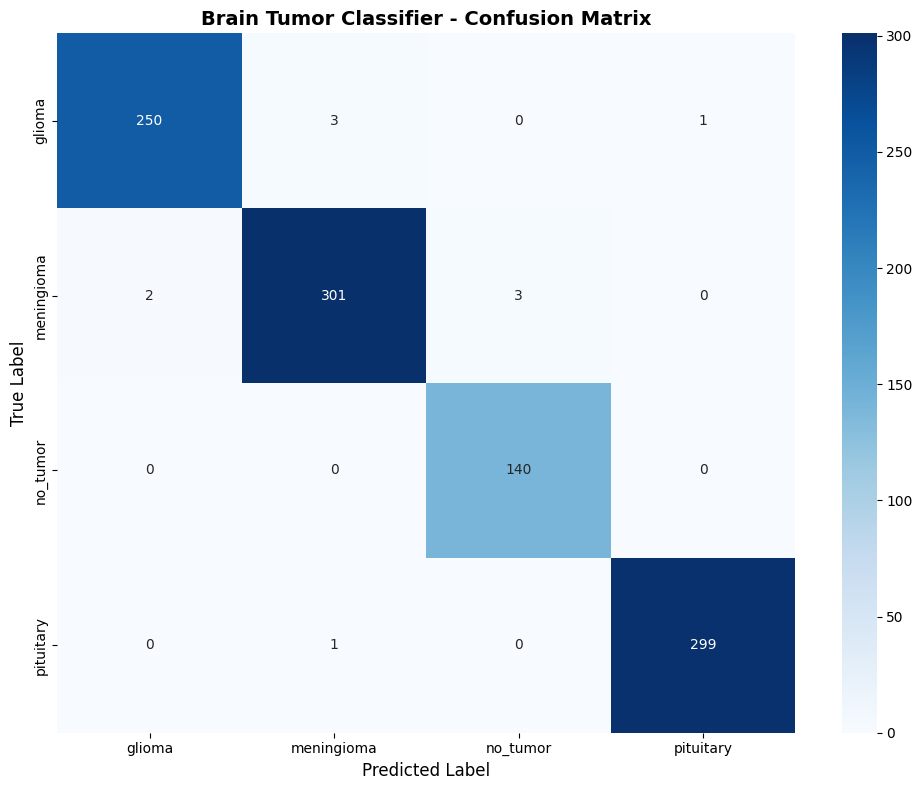

In [ ]:
"""
CELL 39: Test Classifier and Generate Comprehensive Analysis
- Adds ROC Curves, Per-Class Accuracy, Comprehensive Summary
REQUIRES: class_test_loader (Cell 23), classifier_model (Cell 25), trained best_classifier.pth
"""

# Check dependencies
if 'class_test_loader' not in dir():
    print(" ERROR: class_test_loader not defined!")
    print("Please run Cell 27 (Classification DataLoaders) first!")
    raise NameError("class_test_loader is not defined.")

if 'classifier_model' not in dir():
    print(" Initializing classifier model...")
    classifier_model = BrainTumorClassifier(num_classes=config.NUM_CLASSES_CLASSIFY).to(device)

def test_classifier(model, model_name):
    """Test classifier and generate detailed metrics with comprehensive visualizations"""

    print(f"\n{'=' * 70}")
    print(f"TESTING {model_name}")
    print('=' * 70)

    model.eval()

    all_preds = []
    all_labels = []
    all_probs = []  # NEW: Store probabilities for ROC curves

    with torch.no_grad():
        for images, labels, _ in tqdm(class_test_loader, desc='Testing'):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)

            # Get probabilities for ROC curves
            probs = torch.softmax(outputs, dim=1)
            all_probs.extend(probs.cpu().numpy())

            _, predicted = torch.max(outputs.data, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_probs = np.array(all_probs)
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f"\nTest Results for {model_name}:")
    print(f"  Accuracy: {accuracy*100:.2f}%")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1 Score: {f1:.4f}")

    # Classification report
    print(f"\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=config.CLASS_NAMES))

    # ========================================================================
    # 1. CONFUSION MATRIX (Enhanced)
    # ========================================================================
    print("\n" + "=" * 70)
    print("1. CONFUSION MATRIX")
    print("=" * 70)

    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[cls.capitalize() for cls in config.CLASS_NAMES],
                yticklabels=[cls.capitalize() for cls in config.CLASS_NAMES],
                cbar_kws={'label': 'Count'})
    plt.title(f'{model_name} - Confusion Matrix\n(Rows: True Label, Columns: Predicted)',
             fontsize=16, fontweight='bold', pad=20)
    plt.ylabel('True Label', fontsize=13, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=13, fontweight='bold')

    # Add accuracy as text
    plt.text(0.5, -0.15, f'Overall Accuracy: {accuracy*100:.2f}%',
            ha='center', va='top', transform=plt.gca().transAxes,
            fontsize=12, fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))

    plt.tight_layout()
    plt.savefig(os.path.join(config.PLOT_DIR, f'{model_name.lower().replace(" ", "_")}_confusion_matrix.png'),
               dpi=150, bbox_inches='tight')
    plt.show()

    print("✓ Confusion matrix saved!")

    # ========================================================================
    # 2. PER-CLASS ACCURACY BAR CHART
    # ========================================================================
    print("\n" + "=" * 70)
    print("2. PER-CLASS ACCURACY ANALYSIS")
    print("=" * 70)

    # Calculate per-class accuracy
    per_class_acc = []
    test_counts = []

    for i in range(len(config.CLASS_NAMES)):
        if cm[i].sum() > 0:
            class_acc = 100 * cm[i, i] / cm[i].sum()
            per_class_acc.append(class_acc)
            test_counts.append(cm[i].sum())
            print(f"  {config.CLASS_NAMES[i].capitalize():15s}: {class_acc:.2f}% ({cm[i, i]}/{cm[i].sum()} correct)")
        else:
            per_class_acc.append(0)
            test_counts.append(0)

    # Plot per-class accuracy
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    colors = plt.cm.viridis(np.linspace(0, 1, len(config.CLASS_NAMES)))

    # Per-class accuracy bar chart
    bars = axes[0].bar([cls.capitalize() for cls in config.CLASS_NAMES],
                       per_class_acc, color=colors, alpha=0.8,
                       edgecolor='black', linewidth=2)

    for bar in bars:
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1f}%', ha='center', va='bottom',
                    fontsize=11, fontweight='bold')

    axes[0].set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
    axes[0].set_title('Per-Class Accuracy', fontsize=14, fontweight='bold')
    axes[0].set_ylim([0, 105])
    axes[0].grid(axis='y', alpha=0.3)
    axes[0].tick_params(axis='x', rotation=45)

    # Test set distribution
    bars2 = axes[1].bar([cls.capitalize() for cls in config.CLASS_NAMES],
                        test_counts, color=colors, alpha=0.8,
                        edgecolor='black', linewidth=2)

    for bar in bars2:
        height = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height)}', ha='center', va='bottom',
                    fontsize=11, fontweight='bold')

    axes[1].set_ylabel('Number of Samples', fontsize=12, fontweight='bold')
    axes[1].set_title('Test Set Distribution', fontsize=14, fontweight='bold')
    axes[1].grid(axis='y', alpha=0.3)
    axes[1].tick_params(axis='x', rotation=45)

    plt.suptitle(f'{model_name} - Per-Class Performance',
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(os.path.join(config.PLOT_DIR, f'{model_name.lower().replace(" ", "_")}_per_class_accuracy.png'),
               dpi=150, bbox_inches='tight')
    plt.show()

    print("✓ Per-class accuracy bar chart saved!")

    # ========================================================================
    # 3. ROC CURVES
    # ========================================================================
    print("\n" + "=" * 70)
    print("3. ROC CURVES & AUC SCORES")
    print("=" * 70)

    from sklearn.preprocessing import label_binarize
    from sklearn.metrics import roc_curve, auc

    # Binarize labels for multi-class ROC
    y_test_bin = label_binarize(all_labels, classes=range(len(config.CLASS_NAMES)))

    # Calculate ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(len(config.CLASS_NAMES)):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], all_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), all_probs.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plot ROC curves
    fig, ax = plt.subplots(figsize=(12, 10))

    # Plot micro-average
    ax.plot(fpr["micro"], tpr["micro"],
           label=f'Micro-average (AUC = {roc_auc["micro"]:.3f})',
           color='deeppink', linestyle=':', linewidth=4)

    # Plot each class
    colors_roc = ['blue', 'red', 'green', 'orange', 'purple', 'brown']
    for i, class_name in enumerate(config.CLASS_NAMES):
        ax.plot(fpr[i], tpr[i], color=colors_roc[i % len(colors_roc)], lw=2.5,
               label=f'{class_name.capitalize()} (AUC = {roc_auc[i]:.3f})')

    # Plot diagonal
    ax.plot([0, 1], [0, 1], 'k--', lw=2, label='Random (AUC = 0.50)')

    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize=13, fontweight='bold')
    ax.set_ylabel('True Positive Rate', fontsize=13, fontweight='bold')
    ax.set_title(f'{model_name} - ROC Curves (Multi-Class)',
                fontsize=16, fontweight='bold', pad=20)
    ax.legend(loc="lower right", fontsize=11, framealpha=0.9)
    ax.grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig(os.path.join(config.PLOT_DIR, f'{model_name.lower().replace(" ", "_")}_roc_curves.png'),
               dpi=150, bbox_inches='tight')
    plt.show()

    print("✓ ROC curves saved!")
    print("\nAUC Scores:")
    print(f"  Micro-average: {roc_auc['micro']:.4f}")
    for i, class_name in enumerate(config.CLASS_NAMES):
        print(f"  {class_name.capitalize():15s}: {roc_auc[i]:.4f}")

    # ========================================================================
    # 4. COMPREHENSIVE SUMMARY
    # ========================================================================
    print("\n" + "=" * 70)
    print("4. COMPREHENSIVE SUMMARY")
    print("=" * 70)

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # Top-left: Accuracy by class
    axes[0, 0].barh([cls.capitalize() for cls in config.CLASS_NAMES], per_class_acc,
                   color=colors, alpha=0.8, edgecolor='black', linewidth=2)
    axes[0, 0].set_xlabel('Accuracy (%)', fontsize=11, fontweight='bold')
    axes[0, 0].set_title('Per-Class Accuracy', fontsize=13, fontweight='bold')
    axes[0, 0].set_xlim([0, 105])
    axes[0, 0].grid(axis='x', alpha=0.3)

    # Top-right: AUC by class
    auc_values = [roc_auc[i] for i in range(len(config.CLASS_NAMES))]
    axes[0, 1].barh([cls.capitalize() for cls in config.CLASS_NAMES], auc_values,
                   color=colors, alpha=0.8, edgecolor='black', linewidth=2)
    axes[0, 1].set_xlabel('AUC Score', fontsize=11, fontweight='bold')
    axes[0, 1].set_title('Per-Class AUC Score', fontsize=13, fontweight='bold')
    axes[0, 1].set_xlim([0, 1.05])
    axes[0, 1].grid(axis='x', alpha=0.3)

    # Bottom-left: Sample counts
    axes[1, 0].bar([cls.capitalize() for cls in config.CLASS_NAMES], test_counts,
                  color=colors, alpha=0.8, edgecolor='black', linewidth=2)
    for i, v in enumerate(test_counts):
        axes[1, 0].text(i, v, str(v), ha='center', va='bottom',
                       fontsize=10, fontweight='bold')
    axes[1, 0].set_ylabel('Samples', fontsize=11, fontweight='bold')
    axes[1, 0].set_title('Test Set Distribution', fontsize=13, fontweight='bold')
    axes[1, 0].tick_params(axis='x', rotation=45)
    axes[1, 0].grid(axis='y', alpha=0.3)

    # Bottom-right: Metrics table
    metrics_data = []
    for i, class_name in enumerate(config.CLASS_NAMES):
        metrics_data.append([
            class_name.capitalize(),
            f"{per_class_acc[i]:.1f}%",
            f"{roc_auc[i]:.3f}",
            f"{test_counts[i]}"
        ])

    table = axes[1, 1].table(cellText=metrics_data,
                            colLabels=['Class', 'Accuracy', 'AUC', 'Samples'],
                            cellLoc='center', loc='center', bbox=[0, 0, 1, 1])
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1, 2)

    # Style table
    for i in range(len(config.CLASS_NAMES) + 1):
        for j in range(4):
            if i == 0:
                table[(i, j)].set_facecolor('#4472C4')
                table[(i, j)].set_text_props(weight='bold', color='white')
            else:
                table[(i, j)].set_facecolor('#E7E6E6' if i % 2 == 0 else 'white')

    axes[1, 1].axis('off')
    axes[1, 1].set_title('Performance Metrics', fontsize=13, fontweight='bold', pad=10)

    plt.suptitle(f'{model_name} - Comprehensive Performance Summary',
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(os.path.join(config.PLOT_DIR, f'{model_name.lower().replace(" ", "_")}_comprehensive_summary.png'),
               dpi=150, bbox_inches='tight')
    plt.show()

    print("✓ Comprehensive summary saved!")

    # ========================================================================
    # FINAL SUMMARY
    # ========================================================================
    print("\n" + "=" * 70)
    print("TESTING COMPLETE!")
    print("=" * 70)
    print(f"\n✓ Overall Accuracy: {accuracy*100:.2f}%")
    print(f"✓ Micro-Average AUC: {roc_auc['micro']:.4f}")
    best_idx = np.argmax(per_class_acc)
    worst_idx = np.argmin(per_class_acc)
    print(f"✓ Best Class: {config.CLASS_NAMES[best_idx].capitalize()} ({per_class_acc[best_idx]:.2f}%)")
    print(f"✓ Most Challenging: {config.CLASS_NAMES[worst_idx].capitalize()} ({per_class_acc[worst_idx]:.2f}%)")
    print(f"\n✓ All visualizations saved to: {config.PLOT_DIR}")

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc_scores': roc_auc,
        'per_class_accuracy': per_class_acc,
        'predictions': all_preds,
        'labels': all_labels,
        'probabilities': all_probs
    }

# Load best model and test
classifier_model.load_state_dict(torch.load(os.path.join(config.MODEL_DIR, 'best_classifier.pth')))
classifier_test_results = test_classifier(classifier_model, "Brain Tumor Classifier")

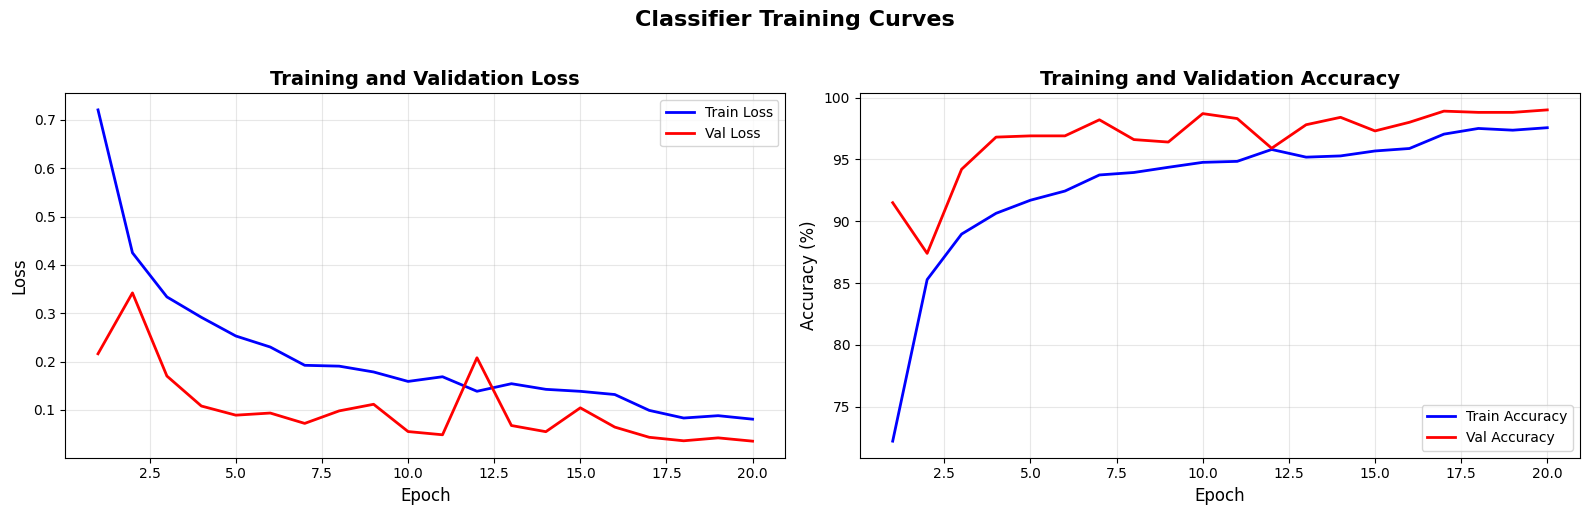

In [ ]:
"""
CELL 40: Plot Classification Training Curves
"""

def plot_classifier_training_curves(history):
    """Plot training curves for classifier"""

    fig, axes = plt.subplots(1, 2, figsize=(16, 5))

    epochs = range(1, len(history['train_loss']) + 1)

    # Loss curve
    axes[0].plot(epochs, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
    axes[0].plot(epochs, history['val_loss'], 'r-', label='Val Loss', linewidth=2)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=10)
    axes[0].grid(True, alpha=0.3)

    # Accuracy curve
    axes[1].plot(epochs, history['train_acc'], 'b-', label='Train Accuracy', linewidth=2)
    axes[1].plot(epochs, history['val_acc'], 'r-', label='Val Accuracy', linewidth=2)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Accuracy (%)', fontsize=12)
    axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=10)
    axes[1].grid(True, alpha=0.3)

    plt.suptitle('Classifier Training Curves', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig(os.path.join(config.PLOT_DIR, 'classifier_training_curves.png'), dpi=150, bbox_inches='tight')
    plt.show()

# Plot classifier training curves
plot_classifier_training_curves(history_classifier)

In [ ]:
"""
CELL 41: Final Results Summary
REQUIRES: unet_test_results, attention_test_results, classifier_test_results
"""

def create_results_summary():
    """Create comprehensive results summary"""

    print("\n" + "=" * 70)
    print("FINAL RESULTS SUMMARY")
    print("=" * 70)

    # Check if required variables exist
    missing_vars = []
    if 'unet_test_results' not in dir():
        missing_vars.append('unet_test_results')
    if 'attention_test_results' not in dir():
        missing_vars.append('attention_test_results')
    if 'classifier_test_results' not in dir():
        missing_vars.append('classifier_test_results')
    
    if missing_vars:
        print(f"\n WARNING: Missing variables: {missing_vars}")
        print("Please run the test cells for each model first!")
        return

    # Segmentation Results
    print("\n### SEGMENTATION RESULTS ###\n")
    print("U-Net (Test Set):")
    print(f"  - Mean IoU: {unet_test_results['iou']:.4f}")
    print(f"  - Mean Dice Coefficient: {unet_test_results['dice']:.4f}")
    print(f"  - Mean Pixel Accuracy: {unet_test_results['pixel_acc']:.4f}")

    print("\nAttention U-Net (Test Set):")
    print(f"  - Mean IoU: {attention_test_results['iou']:.4f}")
    print(f"  - Mean Dice Coefficient: {attention_test_results['dice']:.4f}")
    print(f"  - Mean Pixel Accuracy: {attention_test_results['pixel_acc']:.4f}")

    print(f"\nImprovement from Attention Mechanism:")
    print(f"  - IoU: +{(attention_test_results['iou'] - unet_test_results['iou'])*100:.2f}%")
    print(f"  - Dice: +{(attention_test_results['dice'] - unet_test_results['dice'])*100:.2f}%")
    print(f"  - Pixel Acc: +{(attention_test_results['pixel_acc'] - unet_test_results['pixel_acc'])*100:.2f}%")

    # Classification Results
    print("\n### CLASSIFICATION RESULTS ###\n")
    print("Classifier (Test Set):")
    print(f"  - Accuracy: {classifier_test_results['accuracy']*100:.2f}%")
    print(f"  - Precision: {classifier_test_results['precision']:.4f}")
    print(f"  - Recall: {classifier_test_results['recall']:.4f}")
    print(f"  - F1 Score: {classifier_test_results['f1']:.4f}")

    print("\n" + "=" * 70)

    # Create summary table
    summary_data = {
        'Model': ['U-Net', 'Attention U-Net', 'Classifier'],
        'Task': ['Segmentation', 'Segmentation', 'Classification'],
        'Primary Metric': [
            f"Dice: {unet_test_results['dice']:.4f}",
            f"Dice: {attention_test_results['dice']:.4f}",
            f"Acc: {classifier_test_results['accuracy']*100:.2f}%"
        ],
        'IoU/Precision': [
            f"{unet_test_results['iou']:.4f}",
            f"{attention_test_results['iou']:.4f}",
            f"{classifier_test_results['precision']:.4f}"
        ],
        'Pixel Acc/Recall': [
            f"{unet_test_results['pixel_acc']:.4f}",
            f"{attention_test_results['pixel_acc']:.4f}",
            f"{classifier_test_results['recall']:.4f}"
        ]
    }

    summary_df = pd.DataFrame(summary_data)
    print("\nResults Summary Table:")
    print(summary_df.to_string(index=False))

    # Save summary to CSV
    summary_df.to_csv(os.path.join(config.SAVE_DIR, 'results_summary.csv'), index=False)

    print(f"\n✓ Results saved to: {config.SAVE_DIR}")

# Generate final summary
create_results_summary()


FINAL RESULTS SUMMARY

### SEGMENTATION RESULTS ###

U-Net (Test Set):
  - Mean IoU: 0.6747
  - Mean Dice Coefficient: 0.7442
  - Mean Pixel Accuracy: 0.9942

Attention U-Net (Test Set):
  - Mean IoU: 0.6642
  - Mean Dice Coefficient: 0.7423
  - Mean Pixel Accuracy: 0.9930

Improvement from Attention Mechanism:
  - IoU: +-1.05%
  - Dice: +-0.19%
  - Pixel Acc: +-0.12%

### CLASSIFICATION RESULTS ###

Classifier (Test Set):
  - Accuracy: 99.00%
  - Precision: 0.9900
  - Recall: 0.9900
  - F1 Score: 0.9900


Results Summary Table:
          Model           Task Primary Metric IoU/Precision Pixel Acc/Recall
          U-Net   Segmentation   Dice: 0.7442        0.6747           0.9942
Attention U-Net   Segmentation   Dice: 0.7423        0.6642           0.9930
     Classifier Classification    Acc: 99.00%        0.9900           0.9900

✓ Results saved to: /kaggle/working/results


In [ ]:
"""
CELL 42: Save All Results and Models
"""

print("\n" + "=" * 70)
print("SAVING ALL RESULTS")
print("=" * 70)

# Save training histories
np.save(os.path.join(config.SAVE_DIR, 'history_unet.npy'), history_unet)
np.save(os.path.join(config.SAVE_DIR, 'history_attention.npy'), history_attention)
np.save(os.path.join(config.SAVE_DIR, 'history_classifier.npy'), history_classifier)

print(f"\n✓ Training histories saved to: {config.SAVE_DIR}")
print(f"✓ Models saved to: {config.MODEL_DIR}")
print(f"✓ Plots saved to: {config.PLOT_DIR}")

print("\n" + "=" * 70)
print("PROJECT COMPLETED SUCCESSFULLY!")
print("=" * 70)

print("\nSaved Files:")
print(f"  - Models: best_unet.pth, best_attention_unet.pth, best_classifier.pth")
print(f"  - Results: results_summary.csv")
print(f"  - Plots: All training curves and visualizations")
print(f"  - Histories: Training history numpy files")

print("\nYou can now:")
print("  1. Present your results using the generated plots")
print("  2. Use predict_on_image() for inference on new images")
print("  3. Load saved models for further evaluation")
print("  4. Access all metrics from the test results")


SAVING ALL RESULTS

✓ Training histories saved to: /kaggle/working/results
✓ Models saved to: /kaggle/working/results/models
✓ Plots saved to: /kaggle/working/results/plots

PROJECT COMPLETED SUCCESSFULLY!

Saved Files:
  - Models: best_unet.pth, best_attention_unet.pth, best_classifier.pth
  - Results: results_summary.csv
  - Plots: All training curves and visualizations
  - Histories: Training history numpy files

You can now:
  1. Present your results using the generated plots
  2. Use predict_on_image() for inference on new images
  3. Load saved models for further evaluation
  4. Access all metrics from the test results
